# Dipsacales Angiosperm353 stats
In this notebook I'll walk through the statistical analyses related to target capture in 

Lee, Aaron K., I. S. Gilman, M. Srivastav, A. Lerner, M. J. Donoghue, W. L. Clement. (*Accepted*) **Reconstructing Dipsacales phylogeny using Angiosperms353: Issues and insights**. American Journal of Botany.

All analyses were done by Ian S. Gilman.

## 0. Set up
First I'll import the modules needed and define any functions.

In [1]:
# Core
import re, os, glob, sys, string, random
import pandas as pd
from pathlib import Path
from itertools import cycle, islice, combinations
import numpy as np
from collections import deque
# Plotting
%matplotlib inline
%config InlineBackend.figure_format ='retina'
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.lines as mlines
from matplotlib import colors as mcolors
from matplotlib import colorbar
import seaborn as sns
# Stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.cluster import KMeans
import scipy.stats as stats
import scipy.cluster as cluster
import spm1d as spm
import scikit_posthocs as skph
import pingouin as pg
# Bio
import toytree, toyplot

/Users/iangilman/miniconda3/envs/python3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.4, the latest is 0.3.8.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


Typically I would not recommend suppressing warnings with the code block below, however, for readability I'll turn them off for now.

In [2]:
import warnings
warnings.filterwarnings('ignore')

The normal test below is just a convenient way of printing the results of normality testing, it doesn't do anything special.

In [3]:
def normal_test(x, alpha, log=False):   
    if log:
        x = np.log(x)
    k2, p = stats.normaltest(x)
    print("p = {:g}".format(p))
    if p < alpha:
         print("The null hypothesis can be rejected. Data are not-normal.")
    else:
         print("The null hypothesis cannot be rejected. Data are normal.")
    return k2, p

The next function is from StackExchange and creates a newick string from a scipy dendrogram. This might be useful for manipulating plots later as you cannot rotate dendrogram nodes in scipy.

In [4]:
def getNewick(node, newick, parentdist, leaf_names):
    if node.is_leaf():
        return "%s:%.2f%s" % (leaf_names[node.id], parentdist - node.dist, newick)
    else:
        if len(newick) > 0:
            newick = "):%.2f%s" % (parentdist - node.dist, newick)
        else:
            newick = ");"
        newick = getNewick(node.get_left(), newick, node.dist, leaf_names)
        newick = getNewick(node.get_right(), ",%s" % (newick), node.dist, leaf_names)
        newick = "(%s" % (newick)
        return newick

## 1. Data import and wrangle data
I'll start with the length statistics. These come from [HybPiper's `get_seq_lengths.py`](https://github.com/mossmatters/HybPiper/wiki/Tutorial#visualizing-results).

In [5]:
raw_353 = pd.read_csv("../Data/HybPiper/Dipsacales_seq_lengths.txt", sep='\t')
raw_353.columns = ["species"] + ["locus{}".format(c) for c in pd.read_csv("../Data/HybPiper/Dipsacales_seq_lengths.txt", sep="\t").columns[1:]]
meanlen = raw_353.iloc[0]
raw_353 = raw_353.iloc[1:]
raw_353 = raw_353.sort_values(by="species")
raw_353 = raw_353.reset_index(drop=True)
raw_353["species"] = [s.replace("_", " ") for s in raw_353["species"]]
raw_353.head()

species  locus6528  locus5821  locus5822  \
0                       Abelia uniflora        282        228        150   
1  Acanthocalyx nepalensis ssp delevaya        291        297         96   
2                   Adoxa moschatellina        207        165        495   
3                   Bassecoia siamensis          0        168        234   
4                     Centranthus ruber          0        240          0   

   locus5980  locus5981  locus6955  locus6150  locus5460  locus5463  ...  \
0          0          0          0          0        258          0  ...   
1        444        699          0        249        411        408  ...   
2        393          0          0        141        327        291  ...   
3        291          0          0        309        261        153  ...   
4        396        474          0        333          0        174  ...   

   locus6782  locus5733  locus6544  locus5639  locus6540  locus6460  \
0        366          0        150        174        135          0   
1        432          0       1284        738        135          0   
2        255          0        747          0        393        657   
3          0        108       1170        420        213        195   
4        432        147       1500        522        261        639   

   locus6462  locus7583  locus4992  locus6238  
0        246        183        939        507  
1        261        123       1743        171  
2        198          0       1431        690  
3        171          0       1038        735  
4        171        207       1134        318  

[5 rows x 354 columns]

Now I'll make a copy of the dataframe as a fraction of the expected length.

In [6]:
percent_353 = raw_353[[c for c in raw_353.columns if c.startswith("locus")]]/list(meanlen[1:])
percent_353.index = raw_353["species"]
percent_353.head()

locus6528  locus5821  locus5822  \
species                                                                 
Abelia uniflora                        0.658879   0.367150   0.208914   
Acanthocalyx nepalensis ssp delevaya   0.679907   0.478261   0.133705   
Adoxa moschatellina                    0.483645   0.265700   0.689415   
Bassecoia siamensis                    0.000000   0.270531   0.325905   
Centranthus ruber                      0.000000   0.386473   0.000000   

                                      locus5980  locus5981  locus6955  \
species                                                                 
Abelia uniflora                        0.000000   0.000000        0.0   
Acanthocalyx nepalensis ssp delevaya   0.713826   0.800687        0.0   
Adoxa moschatellina                    0.631833   0.000000        0.0   
Bassecoia siamensis                    0.467846   0.000000        0.0   
Centranthus ruber                      0.636656   0.542955        0.0   

                                      locus6150  locus5460  locus5463  \
species                                                                 
Abelia uniflora                        0.000000      0.688   0.000000   
Acanthocalyx nepalensis ssp delevaya   0.383077      1.096   0.904656   
Adoxa moschatellina                    0.216923      0.872   0.645233   
Bassecoia siamensis                    0.475385      0.696   0.339246   
Centranthus ruber                      0.512308      0.000   0.385809   

                                      locus5464  ...  locus6782  locus5733  \
species                                          ...                         
Abelia uniflora                        0.000000  ...   0.903704   0.000000   
Acanthocalyx nepalensis ssp delevaya   0.185455  ...   1.066667   0.000000   
Adoxa moschatellina                    0.123636  ...   0.629630   0.000000   
Bassecoia siamensis                    0.269091  ...   0.000000   0.210938   
Centranthus ruber                      0.298182  ...   1.066667   0.287109   

                                      locus6544  locus5639  locus6540  \
species                                                                 
Abelia uniflora                        0.067537   0.205431   0.221675   
Acanthocalyx nepalensis ssp delevaya   0.578118   0.871311   0.221675   
Adoxa moschatellina                    0.336335   0.000000   0.645320   
Bassecoia siamensis                    0.526790   0.495868   0.349754   
Centranthus ruber                      0.675371   0.616293   0.428571   

                                      locus6460  locus6462  locus7583  \
species                                                                 
Abelia uniflora                        0.000000   0.340249   0.552870   
Acanthocalyx nepalensis ssp delevaya   0.000000   0.360996   0.371601   
Adoxa moschatellina                    0.714130   0.273859   0.000000   
Bassecoia siamensis                    0.211957   0.236515   0.000000   
Centranthus ruber                      0.694565   0.236515   0.625378   

                                      locus4992  locus6238  
species                                                     
Abelia uniflora                        0.527528   0.551687  
Acanthocalyx nepalensis ssp delevaya   0.979213   0.186072  
Adoxa moschatellina                    0.803933   0.750816  
Bassecoia siamensis                    0.583146   0.799782  
Centranthus ruber                      0.637079   0.346028  

[5 rows x 353 columns]

Next I'll import some of the the quality metrics that we assessed during the lab work. This first data frame lists the initial sample concentration and DNA mass.

In [7]:
concentration_norm = pd.read_csv("../Data/LabWork/02_Concentration_normalization.csv")
concentration_norm["species"] = sorted(percent_353.index)
concentration_norm = concentration_norm[["species", "Concentration (ng/uL)", "Total mass (ng)", "Genus"]]
concentration_norm.columns = ["species", "initial_concentration", "initial_ng_DNA", "genus"]
concentration_norm["species"] = [s.replace("_", " ") for s in concentration_norm["species"]]
concentration_norm.head()

species  initial_concentration  \
0                       Abelia uniflora                    4.3   
1  Acanthocalyx nepalensis ssp delevaya                   95.0   
2                   Adoxa moschatellina                  101.0   
3                   Bassecoia siamensis                    2.6   
4                     Centranthus ruber                   11.6   

   initial_ng_DNA         genus  
0          225.75        Abelia  
1         9500.00  Acanthocalyx  
2        43430.00         Adoxa  
3           26.00     Bassecoia  
4          754.00   Centranthus

The second contains information about the number of PCR cycles, post-amplification sample mass, and hybridization pool assignment.

In [8]:
post_amp = pd.read_csv("../Data/LabWork/04_Post-amplification_quantification.csv")
post_amp["species"] = post_amp[["Genus", "Species"]].agg("_".join, axis=1)
post_amp["species"] = post_amp["species"].str.replace(".", "")
post_amp["species"] = post_amp["species"].str.replace(" ", "_")
post_amp = post_amp[["species", "Cycles", "Total DNA (ng).1", "Pool Number"]]
post_amp.columns = ["species", "cycles", "post_amp_ng_DNA", "pool"]
post_amp["species"] = [s.replace("_", " ") for s in post_amp["species"]]
post_amp.head()

species  cycles post_amp_ng_DNA  pool
0           Lonicera henryi      12          1022.2     1
1  Lonicera quinquelocuaris      12           950.0     1
2       Lonicera floribunda      12           923.4     1
3         Lonicera tatarica      12           904.4     1
4          Lonicera maackii      12           801.8     1

Finally, I'll merge the above data frames.

In [9]:
raw_353 = raw_353.merge(concentration_norm, on="species")
raw_353 = raw_353.merge(post_amp, on="species")
raw_353.head()

species  locus6528  locus5821  locus5822  \
0                       Abelia uniflora        282        228        150   
1  Acanthocalyx nepalensis ssp delevaya        291        297         96   
2                   Adoxa moschatellina        207        165        495   
3                   Bassecoia siamensis          0        168        234   
4                     Centranthus ruber          0        240          0   

   locus5980  locus5981  locus6955  locus6150  locus5460  locus5463  ...  \
0          0          0          0          0        258          0  ...   
1        444        699          0        249        411        408  ...   
2        393          0          0        141        327        291  ...   
3        291          0          0        309        261        153  ...   
4        396        474          0        333          0        174  ...   

   locus6462  locus7583  locus4992  locus6238  initial_concentration  \
0        246        183        939        507                    4.3   
1        261        123       1743        171                   95.0   
2        198          0       1431        690                  101.0   
3        171          0       1038        735                    2.6   
4        171        207       1134        318                   11.6   

   initial_ng_DNA         genus  cycles  post_amp_ng_DNA  pool  
0          225.75        Abelia      12            197.6     6  
1         9500.00  Acanthocalyx      12            934.8     8  
2        43430.00         Adoxa      12           1615.0     4  
3           26.00     Bassecoia      16            207.1     8  
4          754.00   Centranthus      12             1976     8  

[5 rows x 360 columns]

Now use Ward hierarchical clustering to identify quality groups. The cut distance is set to 50% the longest distance in the affinity matrix.

In [10]:
locus_cols = [l for l in percent_353.columns if l.startswith("locus")]

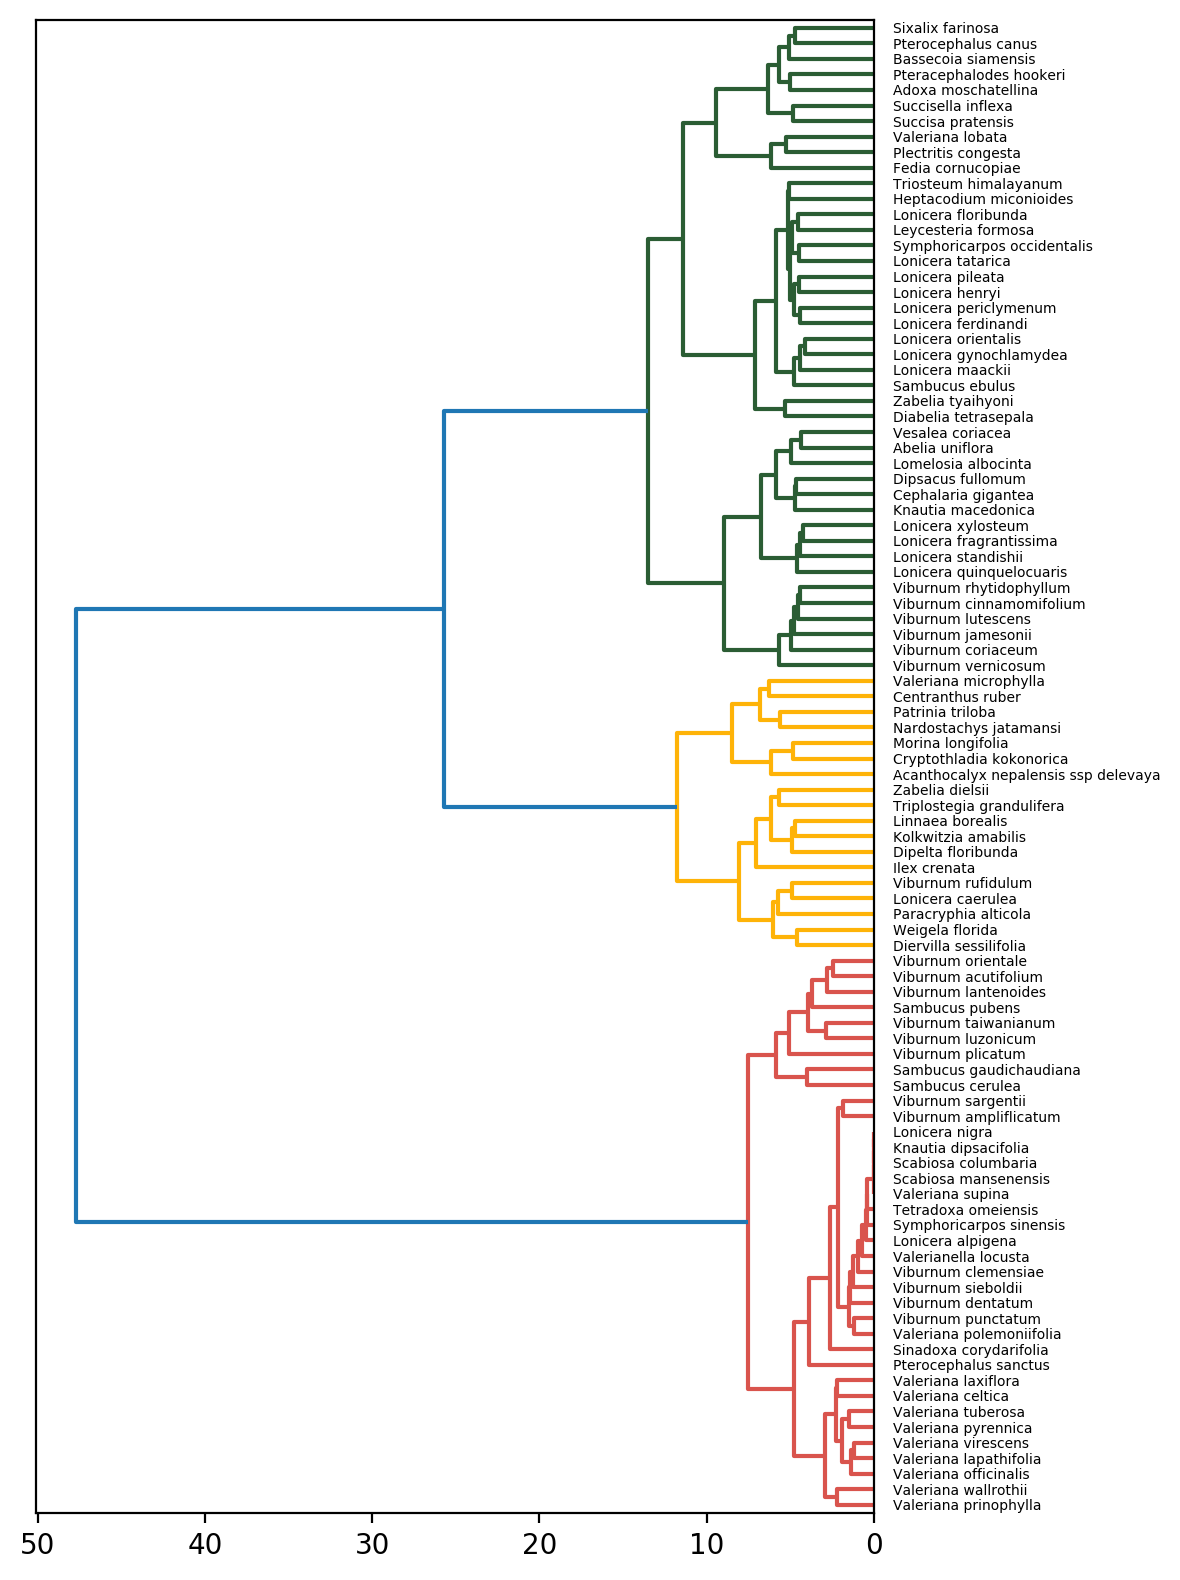

In [11]:
plt.style.use('default')
fig, ax = plt.subplots(figsize=(6, 8))

cluster.hierarchy.set_link_color_palette(["xkcd:pale red", "xkcd:amber", "xkcd:pine"])
Z = cluster.hierarchy.linkage(percent_353[locus_cols], method  = "ward")
ward_dendro = cluster.hierarchy.dendrogram(Z, color_threshold=0.5*max(Z[:,2]), orientation="left", 
                                           labels = list(percent_353.index), ax = ax)

plt.tight_layout()
plt.savefig('../Figures/Heatmap-taxon-dendrogram.pdf', format='pdf', transparent=True, dpi=300, bbox_to_inches="tight")
plt.savefig('../Figures/Heatmap-taxon-dendrogram.lowres.png', format='png', transparent=True, dpi=300, bbox_to_inches="tight")

Now I'll reindex the data frame so that it matches the dendrogram.

In [12]:
percent_353 = percent_353.reindex(ward_dendro['ivl'])

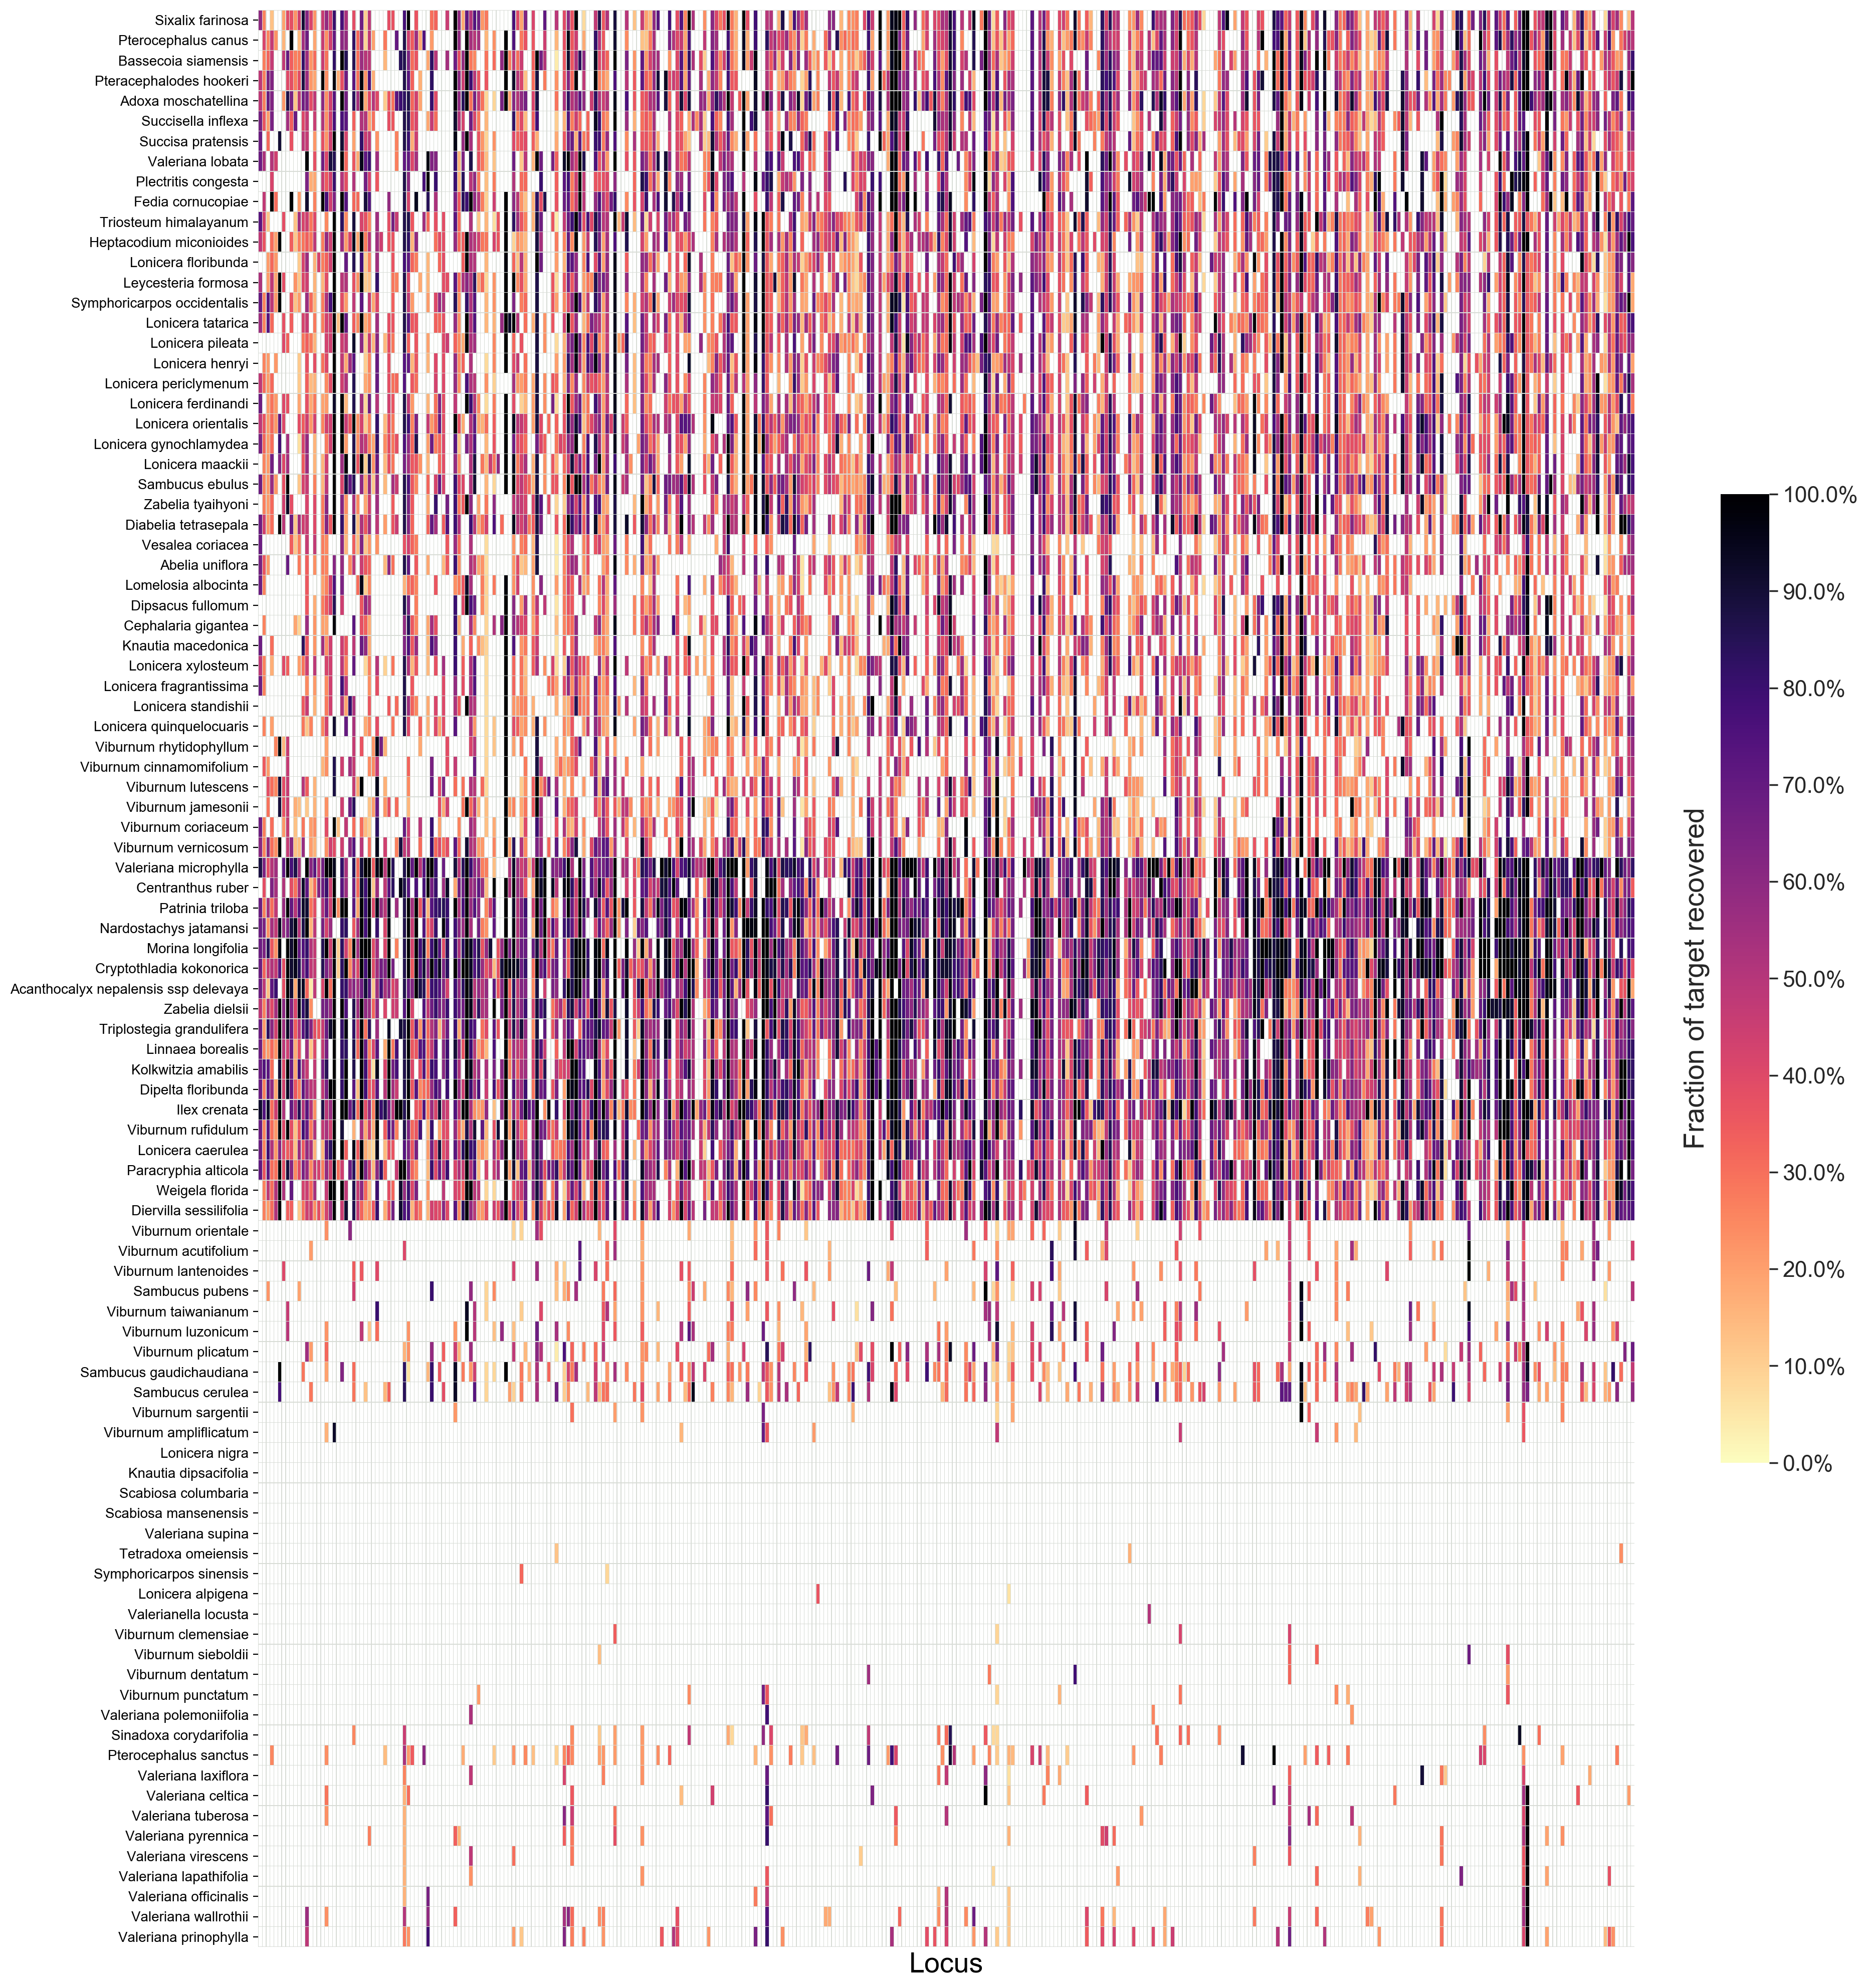

In [13]:
fig, ax = plt.subplots(figsize=(20,20))
sns.set(font_scale=1)
mask = percent_353[locus_cols].isnull()
heatmap = sns.heatmap(data=percent_353[locus_cols].replace(to_replace=0, value=np.nan), 
                      linecolor="xkcd:light grey", mask=mask, cmap='magma_r', 
                      vmin=0.0, vmax=1.0, linewidths=0.10,
            cbar_kws = {"ticks":np.linspace(start=0.0, stop = 1.0, num=11), "shrink": 0.50})

heatmap.set_ylim([0, 96])

heatmap.set_xticks([])
heatmap.set_xticklabels([])

heatmap.set_yticklabels([s.replace("_", " ") for s in percent_353.index])

heatmap.set_xlabel("Locus", size=20)
heatmap.set_ylabel("")

cbar = heatmap.collections[0].colorbar
cbar.set_ticklabels(["{}%".format(t) for t in np.linspace(0, 100, 11)])
cbar.ax.tick_params(labelsize=16)
cbar.set_label(label='Fraction of target recovered', labelpad = -125.0, y = 0.50, size=20)

plt.tight_layout()

More reorganization to highlight which loci we kept for analyses. First I'll check to make sure the loci for each dataset are the same.

In [14]:
exon_loci = ["locus{}".format(l) for l in [5357,6432,6947,6383,6732,6458,5464,5990,5899,6221,6226,4793,6130,6139,6689,5354,4471,6494,5733,5404,6933,5421,5639,5815,5941,6601,6462,4796,6961,7128,7241,5664,6366,6785,7583,6119,4992,4691,6216,7361,7136,6652,6848,5716,6552,6572,6320,5422,4744,5090,6978,5273,5562,5843,6050,7602,6679,5599,6389,5398,5188,6318,6995,5200,6454,6064,5138,5950,5296,5945,5104,5260,6792,5018,7279,6265,6527,6540,5406,6373,7273,5366,5866,5918,4848,7141,6299,5859,7111,5116,6378,6363,6029,5634,6398,6487,6238,6258,5531,5477,5841,7021,7135,6685,5348,6274,6859,6483,5770,6649,5921,6270,5772,5299,6198,7628,6924,6227,7325,6449,5981,6865,5703,7028,6036,6496,6457,6459,6914,5721,6946,6298,5339,6098,6779,6544,5913,6407,5596,4954,5968,5551,5123,6056,5791,6550,5333,5922,5502,6393,5536,5893,6746,6404,5163,6713,5489,6164,5038,6791,6038,5131,6016,6563,4893,5162,6882,5528,6175,5977,6893,5865,6405,5264,5822,6854,6631,6460,5670,4942,5857,4932,4889,4724,6968,6148,5943,5842,6660,5347,5699,5335,6977,7331,5858,6150,5949,5614,7013,6864,6557,5980,7324,6639,6488,5933,6500,6041,5578,7572,5849,5513,6958,6406,5816,5974,5894,6420,5034,6282,6526,6176,5168,6528,5642,5257,6384]]
sc_loci = ["locus{}".format(l) for l in [6198,5670,7628,6649,4932,6483,5857,4942,6270,5981,6865,6227,6449,7325,6036,6496,7028,4796,5822,6924,5264,4744,6946,6914,6298,5335,6457,6459,5699,5347,6407,6056,6544,6779,4691,6098,5842,5943,5578,5933,6393,5513,6550,5849,6713,5614,5949,5858,6404,6746,6882,6563,5168,6175,5034,6164,5257,6016,4471,6038,6791,5642,4793,5894,5977,6893,5816,6854,5703,4848,6405,5299,5772,5921,5770,6631,6460,5913,6660,6148,5123,5551,6968,5968,4954,5596,6977,5339,5721,5163,7324,6639,6864,6557,5980,5893,5536,6150,7331,5489,7013,5922,5333,5791,6488,5502,7572,6500,6041,6406,6420,5974,5865,6958,5131,5038,6384,6526,6176,5528,6282,6528,5162,5188,5398,6432,5200,6732,5562,5273,5990,6458,5599,6947,6383,5843,6130,6139,5296,6226,5260,5104,6221,5945,5138,6933,4893,6689,5950,6494,5918,5866,6462,5366,6961,6601,5018,7241,7128,6119,5406,7583,6366,6785,6652,6848,7361,7136,5841,5477,5531,6552,6572,5348,6216,5116,5859,6320,5634,6679,6050,7602,6389,5464,6978,6995,6318,5357,5733,5354,5639,6454,6064,5421,5404,6792,5899,6540,6527,5664,4724,4889,7279,6265,5941,5815,7141,7273,6373,6029,6363,6258,6238,6398,6487,6299,5090,5422,6378,7111,4992,6859,6274,7021,5716,7135,6685]]
exon_sc_loci = ["locus{}".format(l) for l in [6198,5670,7628,6649,4932,6483,5857,4942,6270,5981,6865,6227,6449,7325,6036,6496,7028,4796,5822,6924,5264,4744,6946,6914,6298,5335,6457,6459,5699,5347,6407,6056,6544,6779,4691,6098,5842,5943,5578,5933,6393,5513,6550,5849,6713,5614,5949,5858,6404,6746,6882,6563,5168,6175,5034,6164,5257,6016,4471,6038,6791,5642,4793,5894,5977,6893,5816,6854,5703,4848,6405,5299,5772,5921,5770,6631,6460,5913,6660,6148,5123,5551,6968,5968,4954,5596,6977,5339,5721,5163,7324,6639,6864,6557,5980,5893,5536,6150,7331,5489,7013,5922,5333,5791,6488,5502,7572,6500,6041,6406,6420,5974,5865,6958,5131,5038,6384,6526,6176,5528,6282,6528,5162,5188,5398,6432,5200,6732,5562,5273,5990,6458,5599,6947,6383,5843,6130,6139,5296,6226,5260,5104,6221,5945,5138,6933,4893,6689,5950,6494,5918,5866,6462,5366,6961,6601,5018,7241,7128,6119,5406,7583,6366,6785,6652,6848,7361,7136,5841,5477,5531,6552,6572,5348,6216,5116,5859,6320,5634,6679,6050,7602,6389,5464,6978,6995,6318,5357,5733,5354,5639,6454,6064,5421,5404,6792,5899,6540,6527,5664,4724,4889,7279,6265,5941,5815,7141,7273,6373,6029,6363,6258,6238,6398,6487,6299,5090,5422,6378,7111,4992,6859,6274,7021,5716,7135,6685]] 

In [15]:
set(exon_loci) == set(exon_sc_loci) == set(sc_loci)

True

I'll start by clustering the loci by percent length.

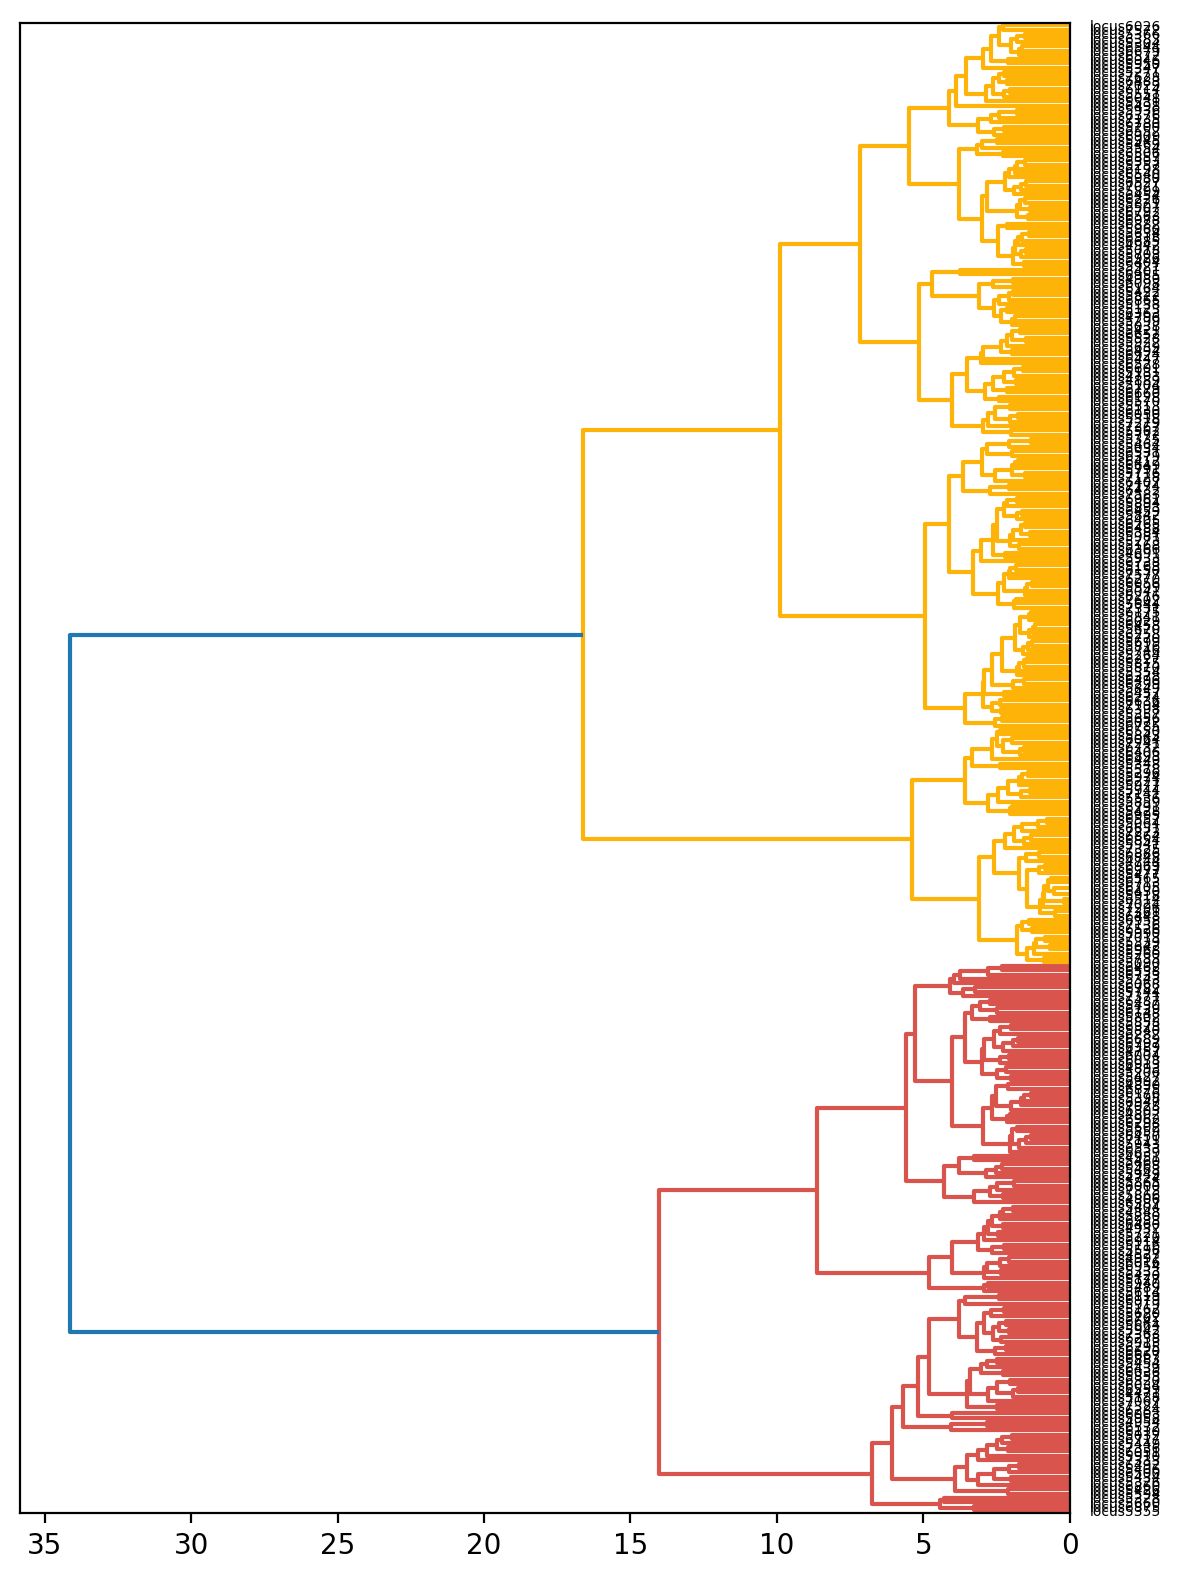

In [16]:
plt.style.use('default')
fig, ax = plt.subplots(figsize=(6, 8))

cluster.hierarchy.set_link_color_palette(["xkcd:pale red", "xkcd:amber", "xkcd:pine"])
locusZ = cluster.hierarchy.linkage(percent_353[locus_cols].T, method  = "ward")
locus_ward_dendro = cluster.hierarchy.dendrogram(locusZ, color_threshold=0.5*max(Z[:,2]), orientation="left", 
                                                 labels = list(percent_353[locus_cols].T.index), ax = ax)
plt.tight_layout()

In [17]:
percent_353 = percent_353[locus_ward_dendro['ivl']]
locus_cols = [c for c in percent_353.columns if c.startswith("locus")]

**Remember** that the `labels` parameter of `cluster.hierarchy.dendrogram` should be the original order of the columns that created `Z`, which in this case are the original indices of `percent_353`, all of the species in alphabetical order. For this reason, I'll recalculate `Z` below.

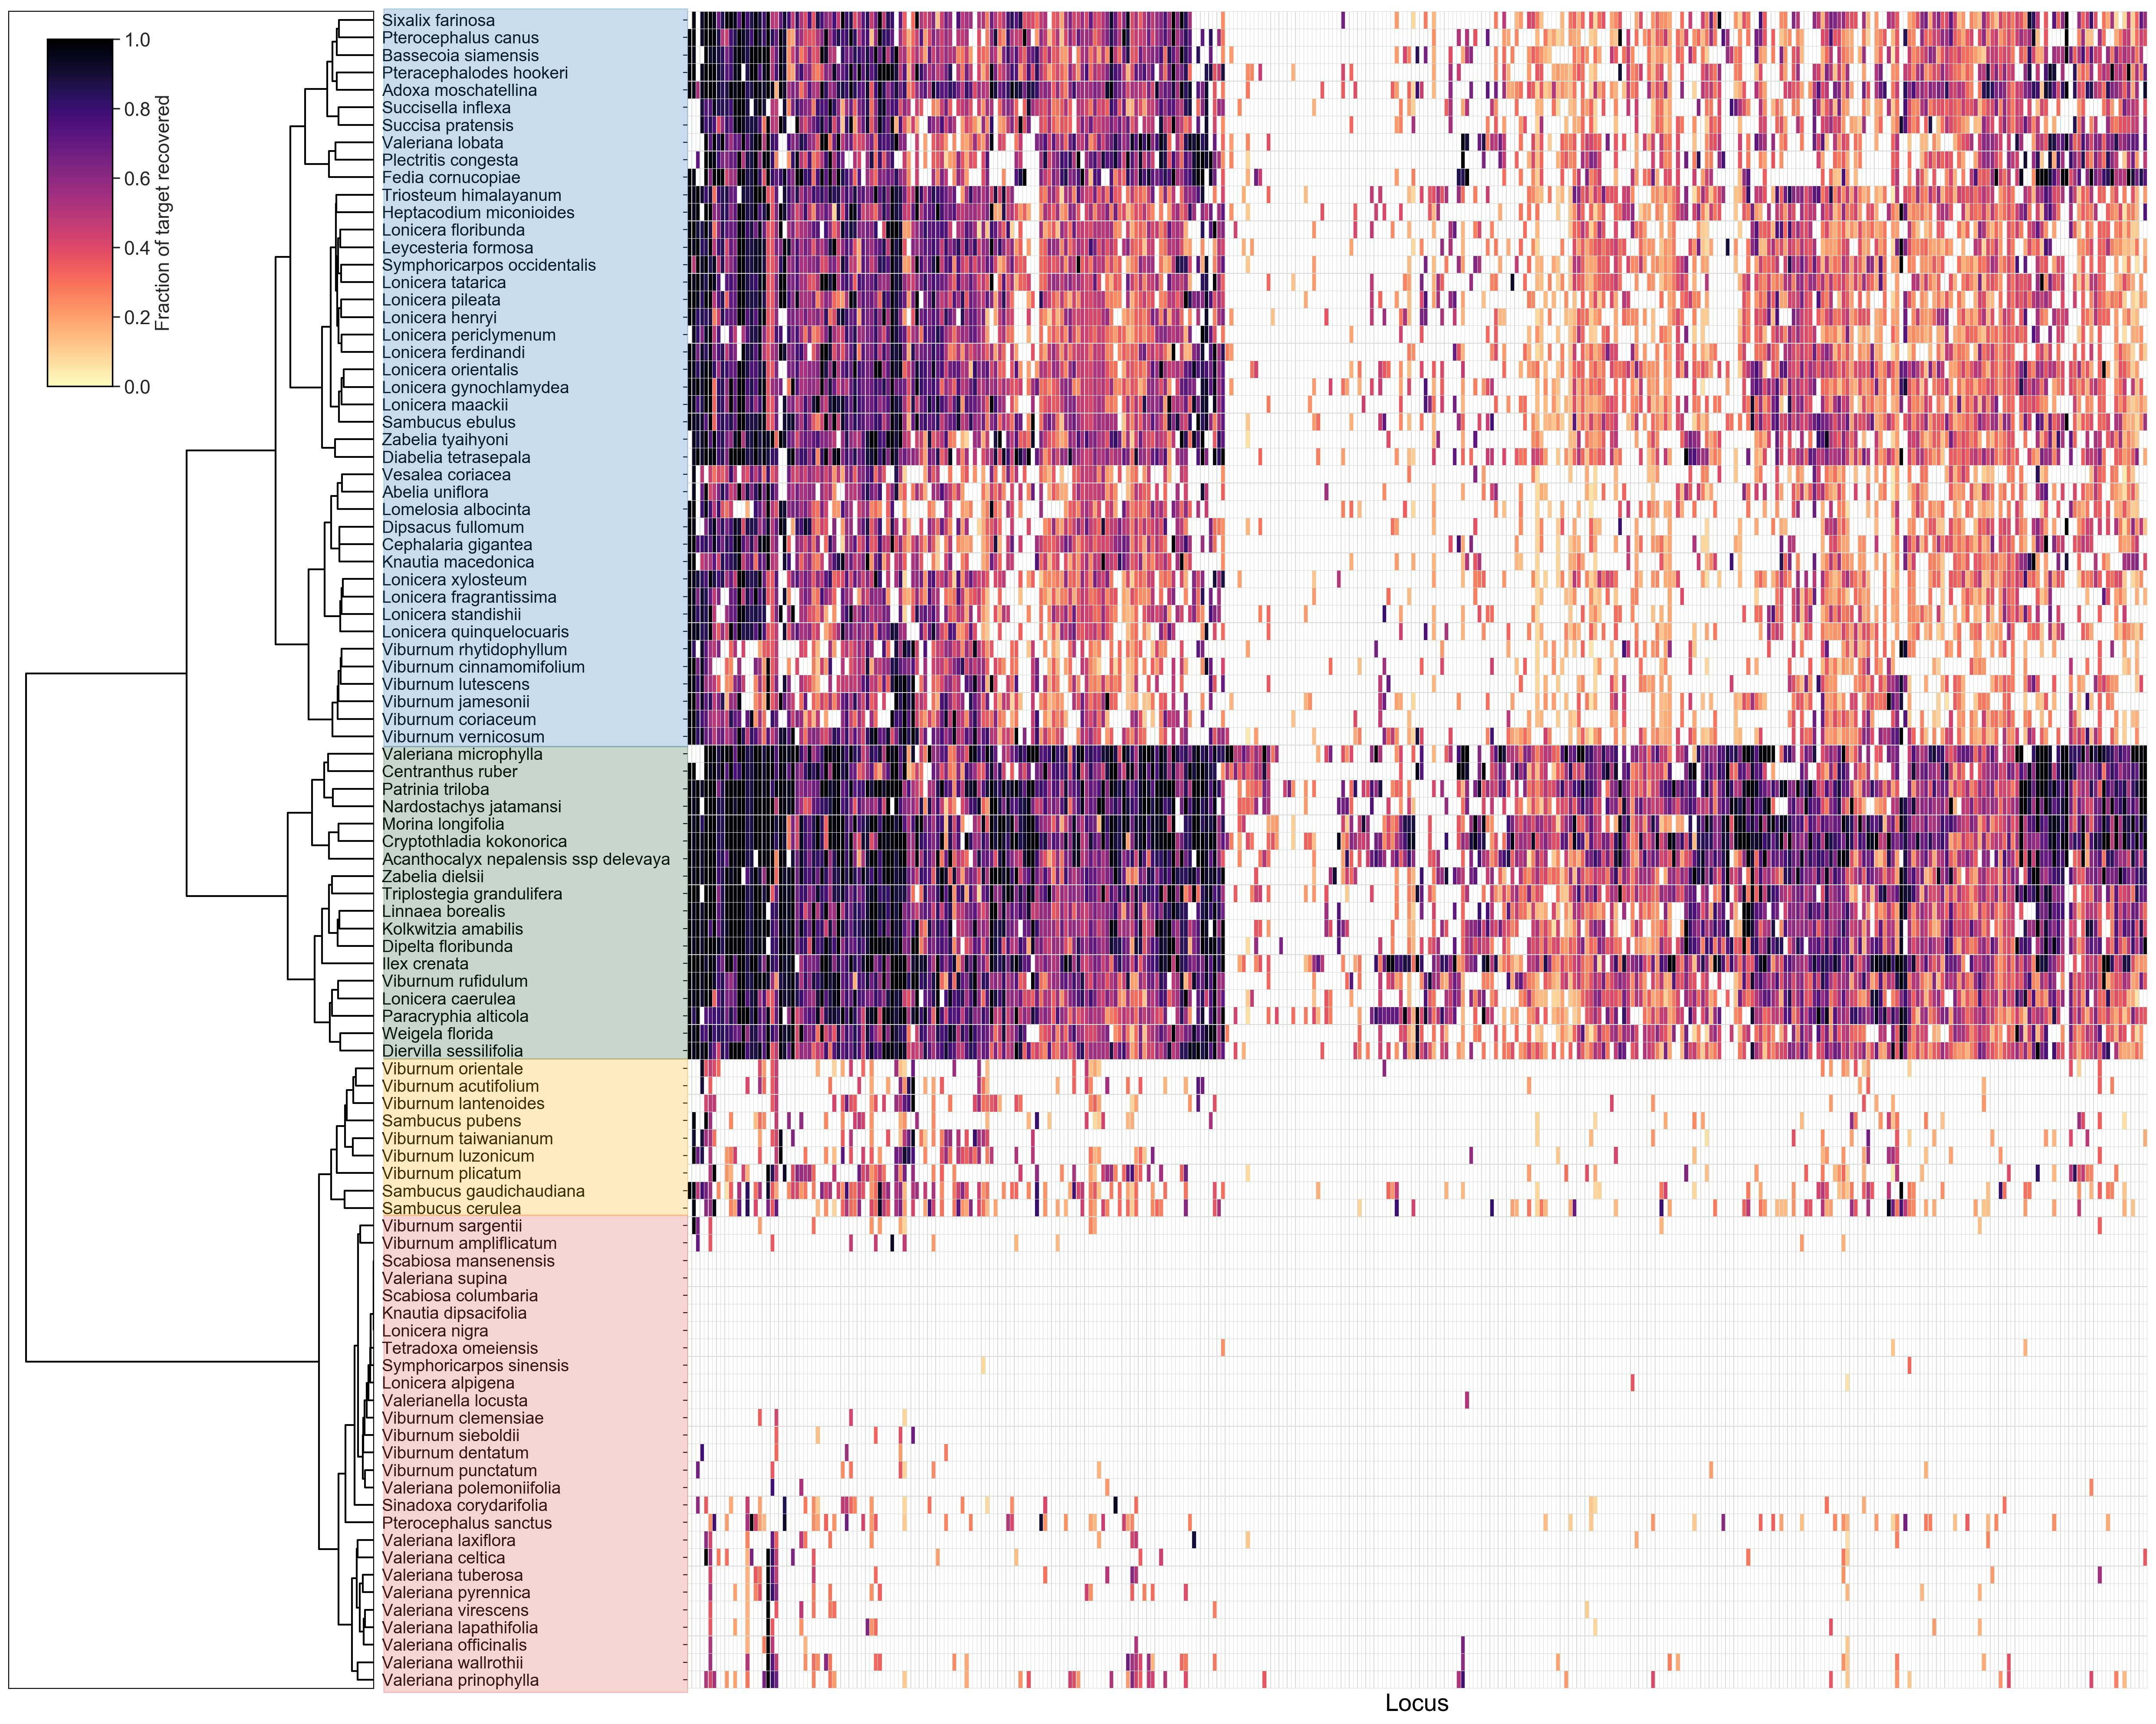

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25,20), gridspec_kw={'width_ratios': [1, 4]})

fig.patches.extend([plt.Rectangle((0.18, 0.0225), 0.14, 0.275, edgecolor=None,
                                  fill=True, color='xkcd:pale red', alpha=0.25, zorder=1000,
                                  transform=fig.transFigure, figure=fig)])
fig.patches.extend([plt.Rectangle((0.18, 0.0225+0.275), 0.14, 0.09,
                                  fill=True, color='xkcd:amber', alpha=0.25, zorder=1000,
                                  transform=fig.transFigure, figure=fig)])
fig.patches.extend([plt.Rectangle((0.18, 0.0225+0.275+0.09), 0.14, 0.18,
                                  fill=True, color='xkcd:pine', alpha=0.25, zorder=1000,
                                  transform=fig.transFigure, figure=fig)])
fig.patches.extend([plt.Rectangle((0.18, 0.0225+0.275+0.09+0.18), 0.14, 0.425,
                                  fill=True, color='xkcd:bluish', alpha=0.25, zorder=1000,
                                  transform=fig.transFigure, figure=fig)])

plt.style.use('default')
cluster.hierarchy.set_link_color_palette(["black", "black", "black"])
Z = cluster.hierarchy.linkage(percent_353[locus_cols], method  = "ward")
cluster.hierarchy.dendrogram(Z, color_threshold=0.5*max(Z[:,2]), orientation="left", 
                             leaf_font_size=14, ax=ax[0], labels=list(percent_353.index),
                             above_threshold_color="black")


sns.set(font_scale=1)
mask = percent_353[locus_cols].isnull()
heatmap = sns.heatmap(data=percent_353[locus_cols].replace(to_replace=0, value=np.nan), 
                      linecolor="xkcd:light grey", mask=mask, cmap='magma_r', vmin=0.0, vmax=1.0, 
                      linewidths=0.10, ax=ax[1], cbar=False,
            cbar_kws = {"ticks":np.linspace(start=0.0, stop = 1.0, num=11), "shrink": 0.50})

heatmap.set_ylim([0, 96])

heatmap.set_xticks([])
heatmap.set_xticklabels([])
heatmap.set_yticklabels([])

heatmap.set_xlabel("Locus", size=20)
heatmap.set_ylabel("")

cmap = plt.cm.magma_r
norm = mcolors.Normalize(vmin=0.0, vmax=1.0)
cax = fig.add_axes([0.025, 0.775, 0.03, 0.20]) # [x0, y0, width, height]
cbar = colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='vertical')
cbar.outline.set_edgecolor('black')
cbar.ax.tick_params(labelsize=16)
cbar.set_label("Fraction of target recovered", size=16)

ax[0].grid(False)
ax[0].patch.set_visible(False)
ax[0].set_facecolor('white')
ax[0].set_xticks([])
ax[0].set_xticklabels([])

ax[1].set_facecolor('white')

plt.tight_layout()

Now I'll use a grid layout to add additional plots around the outside that show taxon and locus occupancy, which taxa were excluded from parts of analyses, and which loci were used. First I'll use the species tree to figure out which taxa in the data frame were included.

In [20]:
dips = toytree.tree("../Data/Concordance_analysis/Dipsacales-species-tree.BS33.rooted.tre")
species_tree_tips = dips.get_tip_labels()
species_tree_tips = [s.replace("_", " ") for s in species_tree_tips]

In [21]:
in_tree = []
for i in percent_353.index:
    if i in species_tree_tips:
        in_tree.append(True)
    else:
        in_tree.append(False)
percent_353["intree"] = in_tree

Now count how many taxa each locus contains, and how many loci were recovered for each taxon.

In [22]:
locus_counts = 353-(percent_353[locus_cols] == 0.000000).astype(float).sum(axis=1)
taxon_counts = 96-(percent_353[locus_cols] == 0.000000).astype(float).sum(axis=0)

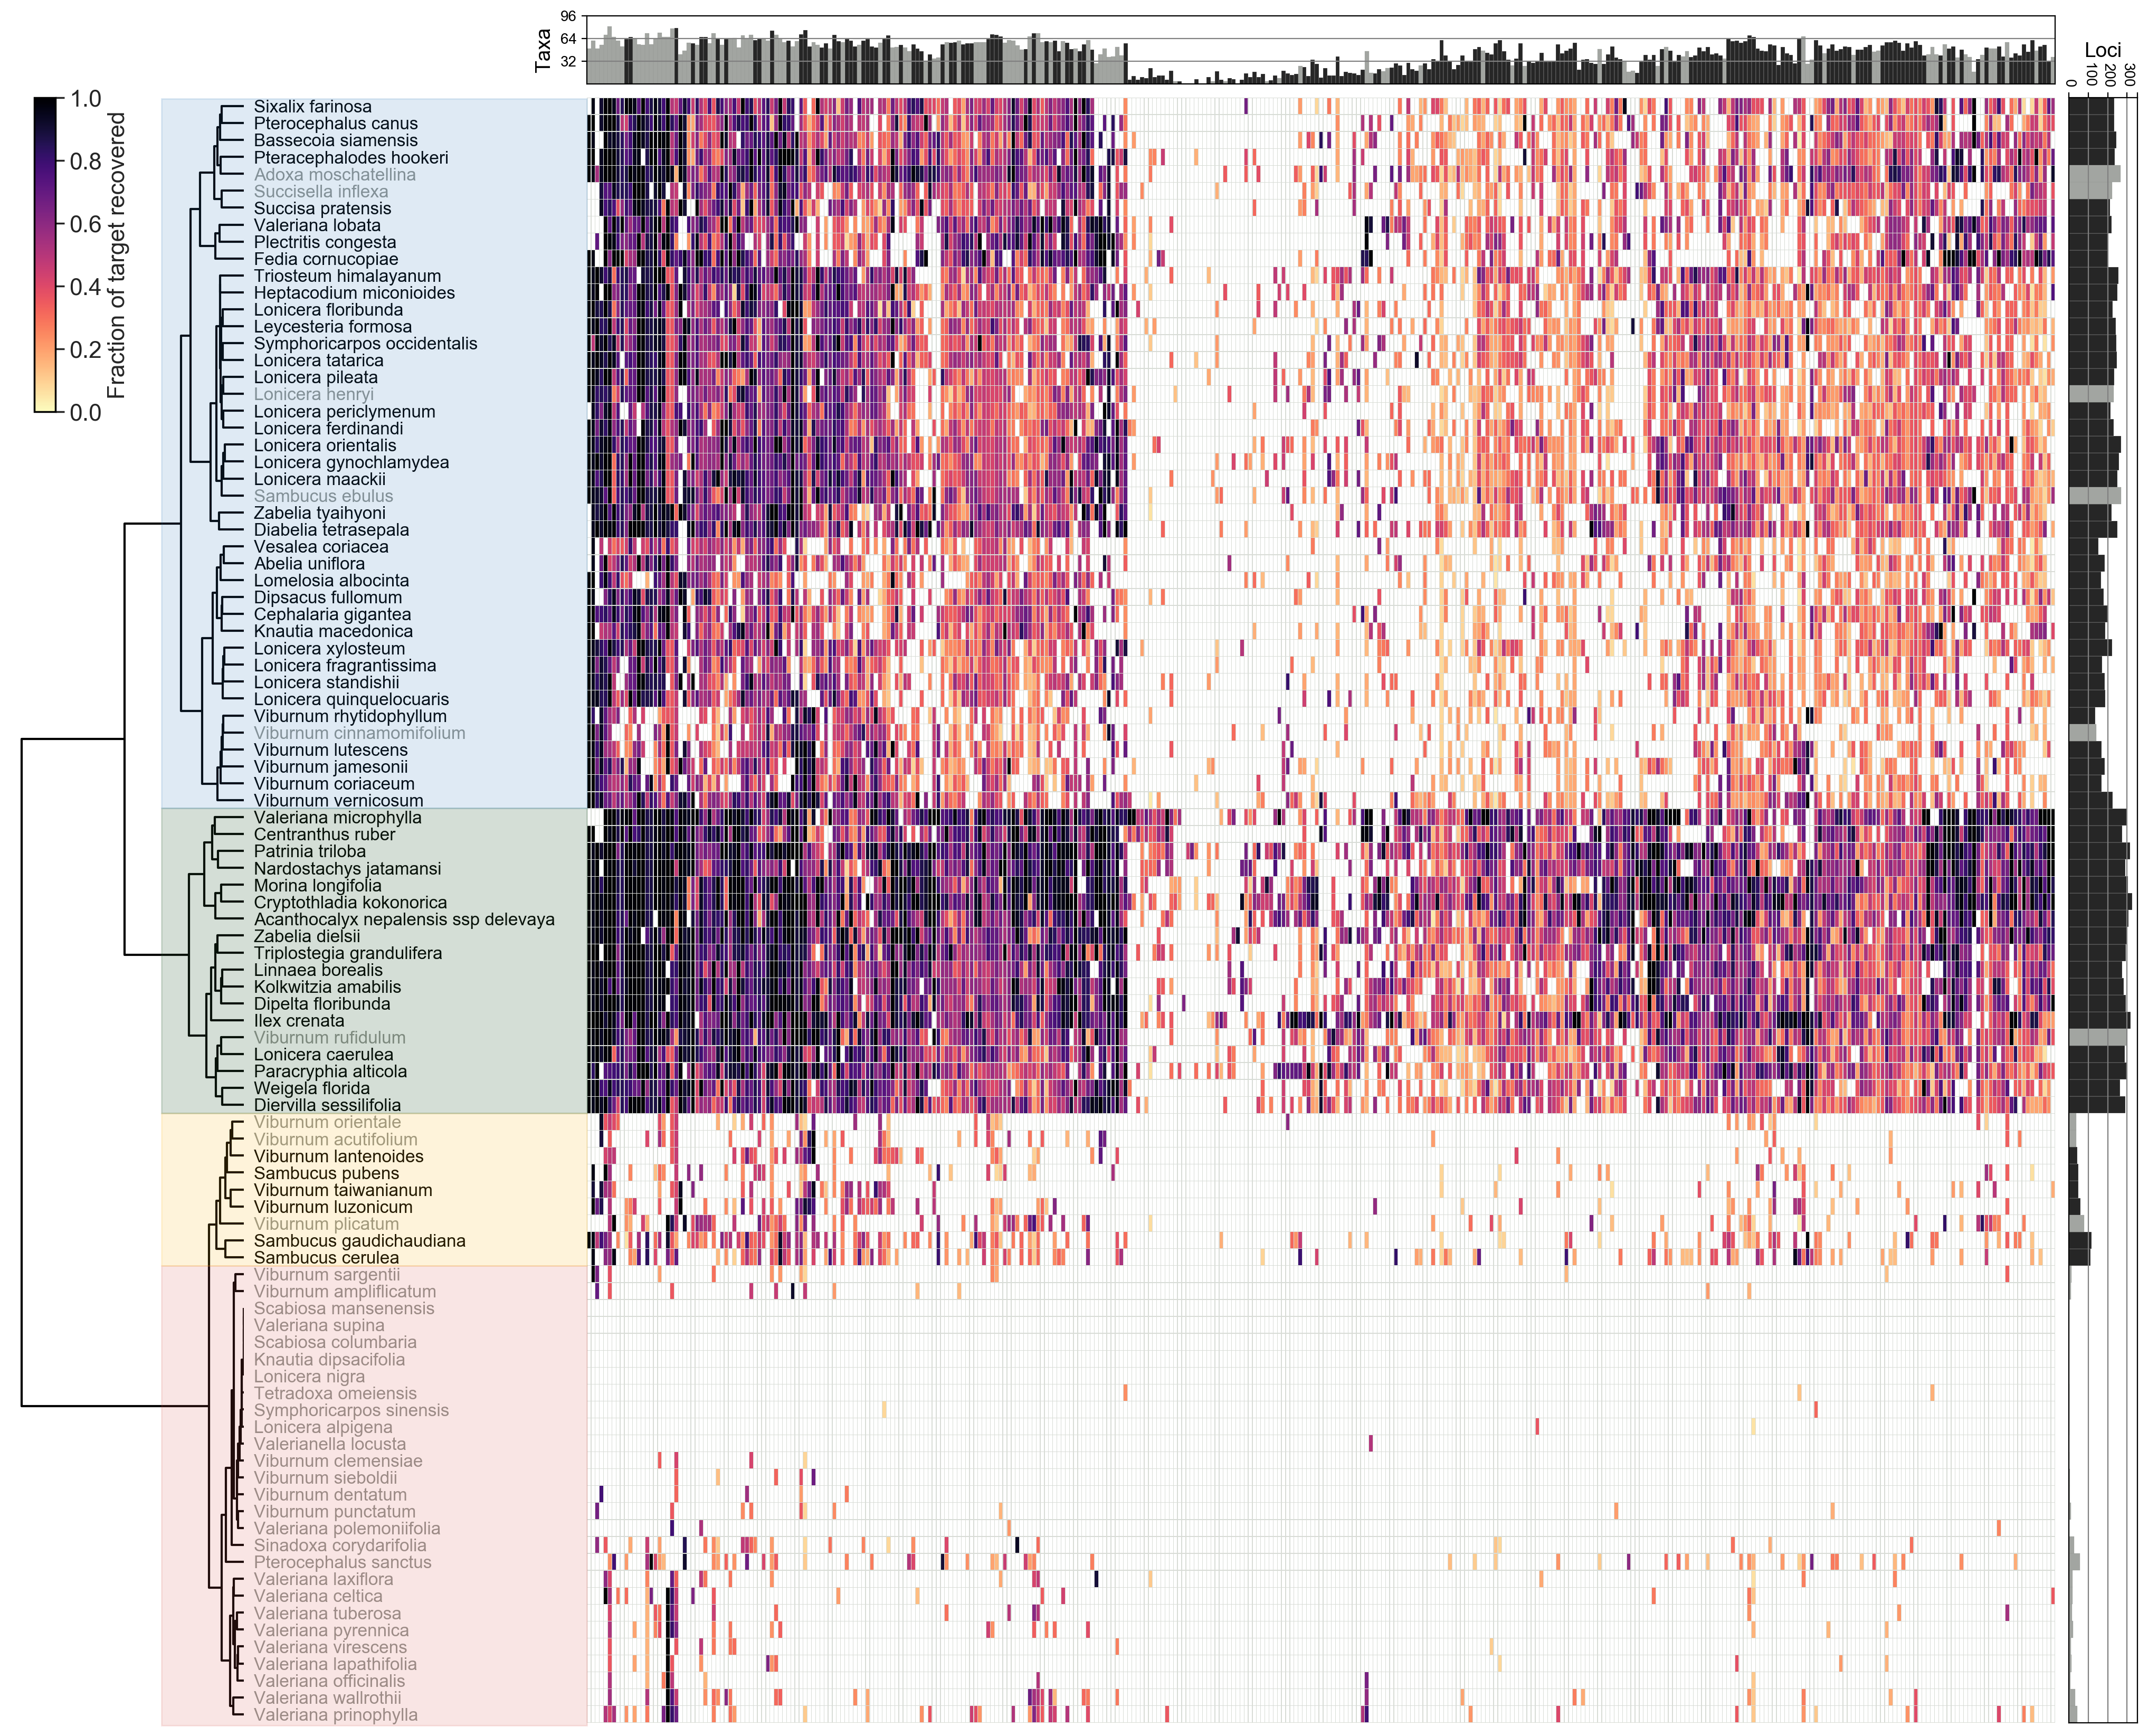

In [23]:
plt.style.use('default')
fig = plt.figure(constrained_layout=False, figsize=(26,21))

# Create grid
gs = fig.add_gridspec(21, 26)
# Add dendrogram, bar plot, and heat map axes
ax_dg = fig.add_subplot(gs[1:, :3])
ax_tp = fig.add_subplot(gs[0, 7:-1])
ax_lp = fig.add_subplot(gs[1:, -1])
ax_hm = fig.add_subplot(gs[1:, 7:-1])

# Add taxon bar chart and color by inclusion
tpbar = ax_tp.bar(x=range(353), height=taxon_counts, color="xkcd:black", width=1.0, alpha=0.85, 
          edgecolor="white", linewidth=0.10, align='edge')
counts=0
for i, locus in enumerate(percent_353[locus_cols].columns):
    if locus not in exon_loci:
        tpbar[i].set_color('xkcd:grey')
    else:
        counts+=1
# Add locus bar chart
lpbar = ax_lp.barh(y=range(96), width=locus_counts, color="xkcd:black", height=1.0, alpha=0.85, 
               align='edge',  edgecolor="white", linewidth=0.10)

ax_tp.set_xticks([])
ax_tp.set_xticklabels([])
ax_tp.set_yticks([32, 64, 96])
ax_tp.set_yticklabels([32, 64, 96])
ax_tp.set_xlim(0, 353)
ax_tp.set_ylim(0, 96)
ax_tp.grid(axis="y", color="gray")
ax_tp.set_ylabel("Taxa", size=14)

ax_lp.xaxis.tick_top()
ax_lp.xaxis.set_label_position("top")
ax_lp.set_yticks([])
ax_lp.set_yticklabels([])
ax_lp.set_xlim(0, 353)
ax_lp.set_ylim(0, 96)
ax_lp.set_xticks([0,100, 200, 300, 353])
ax_lp.set_xticklabels([0, 100, 200, 300], rotation=-90)
ax_lp.grid(axis="x", color="gray")
ax_lp.set_xlabel("Loci", size=14)

# Add cluster background colors
fig.patches.extend([plt.Rectangle((0.18, 0.10875), 0.155, 0.2075, fill=True, color='xkcd:pale red', 
                                  alpha=0.15, transform=fig.transFigure, figure=fig)])
fig.patches.extend([plt.Rectangle((0.18, 0.10875+0.2075), 0.155, 0.06875, fill=True, color='xkcd:amber', 
                                  alpha=0.15, transform=fig.transFigure, figure=fig)])
fig.patches.extend([plt.Rectangle((0.18, 0.11+0.205+0.07), 0.155, 0.1375, fill=True, color='xkcd:pine', 
                                  alpha=0.2, transform=fig.transFigure, figure=fig)])
fig.patches.extend([plt.Rectangle((0.18, 0.11+0.205+0.07+0.1375), 0.155, 0.32, fill=True, color='xkcd:bluish',
                                  alpha=0.15, transform=fig.transFigure, figure=fig)])

# Add dendrogram and color labels by inclusion
cluster.hierarchy.set_link_color_palette(["black", "black", "black"])
cluster.hierarchy.dendrogram(Z, color_threshold=0.5*max(Z[:,2]), orientation="left", 
                             leaf_font_size=12, ax=ax_dg, labels=ward_dendro['ivl'],
                             above_threshold_color="black", )

for i, lbl in enumerate(ax_dg.get_ymajorticklabels()):
    if not percent_353.loc[lbl.get_text(), "intree"]:
        lbl.set_color("xkcd:grey")
        lpbar[i].set_color('xkcd:grey')
        
ax_dg.grid(False)
ax_dg.set_facecolor('white')
ax_dg.set_xticks([])
ax_dg.set_xticklabels([])
for s in ['right', 'left', 'top', 'bottom']:
    ax_dg.spines[s].set_visible(False)

# Add heat map
sns.set(font_scale=1)
mask = percent_353[locus_cols].isnull()
heatmap = sns.heatmap(data=percent_353[locus_cols].replace(to_replace=0, value=np.nan), 
                      linecolor="xkcd:light grey", mask=mask, cmap='magma_r', vmin=0.0, vmax=1.0, 
                      linewidths=0.10, ax=ax_hm, cbar=False,
            cbar_kws = {"ticks":np.linspace(start=0.0, stop = 1.0, num=11), "shrink": 0.50})

ax_hm.set_facecolor('white')
ax_hm.set_ylim([0, 96])
ax_hm.set_xticks([])
ax_hm.set_xticklabels([])
ax_hm.set_yticklabels([])
ax_hm.axis('off')

ax_hm.set_xlabel("Locus", size=20)
ax_hm.set_ylabel("")

# Add color bar
cmap = plt.cm.magma_r
norm = mcolors.Normalize(vmin=0.0, vmax=1.0)
cax = fig.add_subplot(gs[1:5, 0])
cbar = colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='vertical')
cbar.ax.set_aspect(15)
cbar.outline.set_edgecolor('black')
cbar.ax.tick_params(labelsize=16)
cbar.set_label("Fraction of target recovered", size=16)

plt.tight_layout()

Finally, I'll reorder columns to group loci we did and didn't use.

In [24]:
locus_presence_grouping = deque()
for l in locus_cols:
    if l in exon_loci:
        locus_presence_grouping.appendleft(l)
    else:
        locus_presence_grouping.append(l)

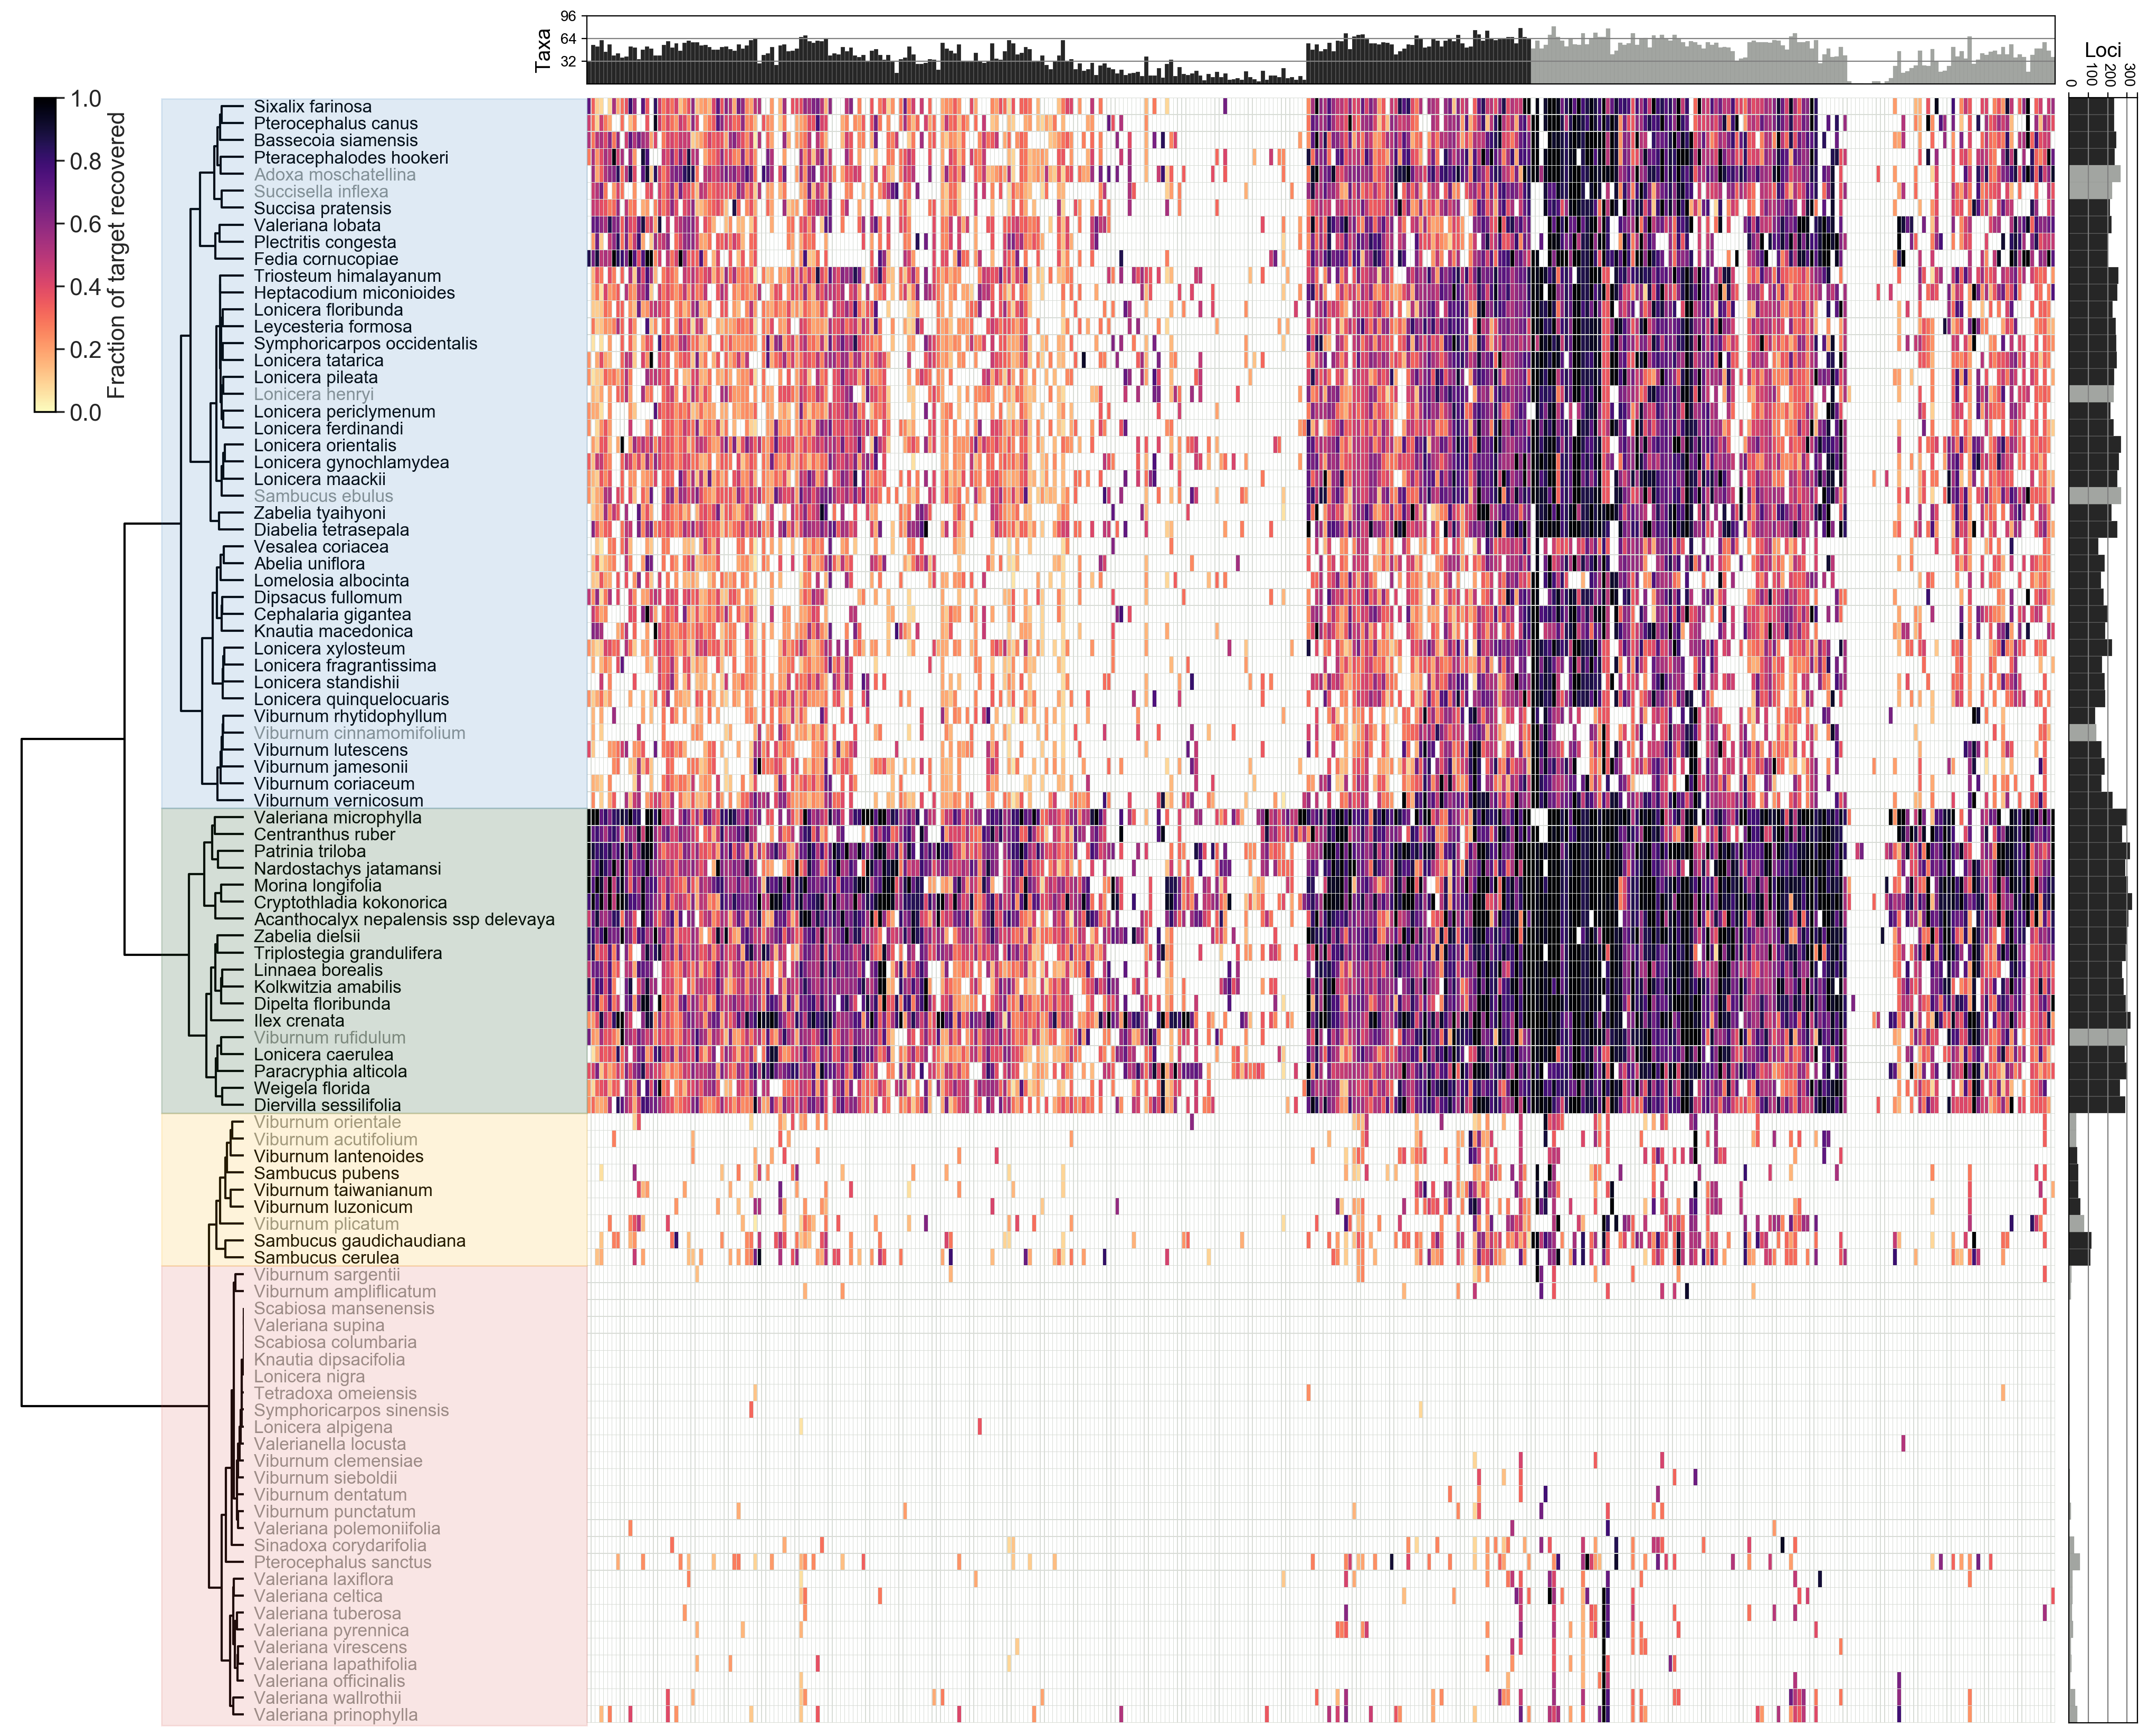

In [25]:
plt.style.use('default')
fig = plt.figure(constrained_layout=False, figsize=(26,21))

# Create grid
gs = fig.add_gridspec(21, 26)
# Add dendrogram, bar plot, and heat map axes
ax_dg = fig.add_subplot(gs[1:, :3])
ax_tp = fig.add_subplot(gs[0, 7:-1])
ax_lp = fig.add_subplot(gs[1:, -1])
ax_hm = fig.add_subplot(gs[1:, 7:-1])

# Add taxon bar chart and color by inclusion
taxon_counts = 96-(percent_353[locus_presence_grouping] == 0.000000).astype(float).sum(axis=0)
tpbar = ax_tp.bar(x=range(353), height=taxon_counts, color="xkcd:black", width=1.0, alpha=0.85, 
          edgecolor="white", linewidth=0.10, align='edge')
counts=0
for i, locus in enumerate(percent_353[locus_presence_grouping].columns):
    if locus not in exon_loci:
        tpbar[i].set_color('xkcd:grey')
    else:
        counts+=1
# Add locus bar chart
lpbar = ax_lp.barh(y=range(96), width=locus_counts, color="xkcd:black", height=1.0, alpha=0.85, 
               align='edge',  edgecolor="white", linewidth=0.10)

ax_tp.set_xticks([])
ax_tp.set_xticklabels([])
ax_tp.set_yticks([32, 64, 96])
ax_tp.set_yticklabels([32, 64, 96])
ax_tp.set_xlim(0, 353)
ax_tp.set_ylim(0, 96)
ax_tp.grid(axis="y", color="gray")
ax_tp.set_ylabel("Taxa", size=14)

ax_lp.xaxis.tick_top()
ax_lp.xaxis.set_label_position("top")
ax_lp.set_yticks([])
ax_lp.set_yticklabels([])
ax_lp.set_xlim(0, 353)
ax_lp.set_ylim(0, 96)
ax_lp.set_xticks([0,100, 200, 300, 353])
ax_lp.set_xticklabels([0, 100, 200, 300], rotation=-90)
ax_lp.grid(axis="x", color="gray")
ax_lp.set_xlabel("Loci", size=14)

# Add cluster background colors
fig.patches.extend([plt.Rectangle((0.18, 0.10875), 0.155, 0.2075, fill=True, color='xkcd:pale red', 
                                  alpha=0.15, transform=fig.transFigure, figure=fig)])
fig.patches.extend([plt.Rectangle((0.18, 0.10875+0.2075), 0.155, 0.06875, fill=True, color='xkcd:amber', 
                                  alpha=0.15, transform=fig.transFigure, figure=fig)])
fig.patches.extend([plt.Rectangle((0.18, 0.11+0.205+0.07), 0.155, 0.1375, fill=True, color='xkcd:pine', 
                                  alpha=0.2, transform=fig.transFigure, figure=fig)])
fig.patches.extend([plt.Rectangle((0.18, 0.11+0.205+0.07+0.1375), 0.155, 0.32, fill=True, color='xkcd:bluish',
                                  alpha=0.15, transform=fig.transFigure, figure=fig)])

# Add dendrogram and color labels by inclusion
cluster.hierarchy.set_link_color_palette(["black", "black", "black"])
cluster.hierarchy.dendrogram(Z, color_threshold=0.5*max(Z[:,2]), orientation="left", leaf_font_size=12, 
                             ax=ax_dg, labels=ward_dendro['ivl'], above_threshold_color="black", )

for i, lbl in enumerate(ax_dg.get_ymajorticklabels()):
    if not percent_353.loc[lbl.get_text(), "intree"]:
        lbl.set_color("xkcd:grey")
        lpbar[i].set_color('xkcd:grey')
        
ax_dg.grid(False)
ax_dg.set_facecolor('white')
ax_dg.set_xticks([])
ax_dg.set_xticklabels([])
for s in ['right', 'left', 'top', 'bottom']:
    ax_dg.spines[s].set_visible(False)

# Add heat map
sns.set(font_scale=1)
mask = percent_353[locus_presence_grouping].isnull()
heatmap = sns.heatmap(data=percent_353[locus_presence_grouping].replace(to_replace=0, value=np.nan), 
                      linecolor="xkcd:light grey", mask=mask, cmap='magma_r', vmin=0.0, vmax=1.0, 
                      linewidths=0.10, ax=ax_hm, cbar=False,
            cbar_kws = {"ticks":np.linspace(start=0.0, stop = 1.0, num=11), "shrink": 0.50})

ax_hm.set_facecolor('white')
ax_hm.set_ylim([0, 96])
ax_hm.set_xticks([])
ax_hm.set_xticklabels([])
ax_hm.set_yticklabels([])
ax_hm.axis('off')

ax_hm.set_xlabel("Locus", size=20)
ax_hm.set_ylabel("")

# Add color bar
cmap = plt.cm.magma_r
norm = mcolors.Normalize(vmin=0.0, vmax=1.0)
cax = fig.add_subplot(gs[1:5, 0])
cbar = colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='vertical')
cbar.ax.set_aspect(15)
cbar.outline.set_edgecolor('black')
cbar.ax.tick_params(labelsize=16)
cbar.set_label("Fraction of target recovered", size=16)

plt.tight_layout()
plt.savefig('../Figures/Annotated-locus-heatmap-reorder.pdf', format='pdf', transparent=True, dpi=300, bbox_inches='tight')
plt.savefig('../Figures/Annotated-locus-heatmap-reorder.lowres.png', format='png', transparent=True, dpi=150, bbox_inches='tight')

In the final figure, above, we can see that most of what we excluded were taxa with low locus recovery. However, the first block of excluded loci contain many long loci that are shared among many taxa. These were excluded because they were flagged as potentially having paralogs in a small subset of taxa.

## Global and cluster-based statistics
First let's see what the median number of loci recovered and median lengths are for the dataset as a whole. I'll also look at the mean maximum length.

In [26]:
global_median = 353-(percent_353[locus_cols] == 0.000000).astype(float).sum(axis=1).median()
global_lower = 353-(percent_353[locus_cols] == 0.000000).astype(float).sum(axis=1).describe()["75%"]
global_upper = 353-(percent_353[locus_cols] == 0.000000).astype(float).sum(axis=1).describe()["25%"]

global_median_len = percent_353[locus_cols].replace(0.0, np.nan).median().median()
global_median_lower = percent_353[locus_cols].replace(0.0, np.nan).median().describe()["25%"]
global_median_upper = percent_353[locus_cols].replace(0.0, np.nan).median().describe()["75%"]

global_max_len = percent_353[locus_cols].replace(0.0, np.nan).max().median()
global_max_lower = percent_353[locus_cols].replace(0.0, np.nan).max().describe()["25%"]
global_max_upper = percent_353[locus_cols].replace(0.0, np.nan).max().describe()["75%"]

print("The global median loci recovered was {:2.0f} (IQR: {:2.0f}-{:2.0f})".format(global_median, 
                                                                                 global_lower,
                                                                                 global_upper))

print("The global median length recovered was {:3.1%} (IQR {:3.1%}-{:3.1%}) the expected exon length".format(global_median_len, 
                                                                                                             global_median_lower,
                                                                                                             global_median_upper))
print("The global median maximum length recovered was {:3.1%} (IQR {:3.1%}-{:3.1%}) the expected exon length".format(
                                                                                                             global_max_len, 
                                                                                                             global_max_lower,
                                                                                                             global_max_upper))

The global median loci recovered was 187 (IQR: 31-249)
The global median length recovered was 44.9% (IQR 33.7%-58.6%) the expected exon length
The global median maximum length recovered was 96.7% (IQR 84.8%-102.9%) the expected exon length


While the heatmap is certainly informative, some details are difficult to pull out. For example, were there any loci that we didn't recover?

In [27]:
for t, c in taxon_counts.iteritems():
    if c==0: print(t,c)

locus6430 0.0
locus6705 0.0


So we did not recovery any contigs for targets 6430 and 6705. Let's look at the mean number of loci recovered and their assembled lengths within each cluster.

In [28]:
percent_353["cluster"] = np.concatenate((np.repeat("low", 27), np.repeat("acceptable",9 ), np.repeat("high", 18), np.repeat("moderate", 42)))
by_cluster = percent_353.groupby("cluster")

In [29]:
for g in by_cluster.groups:
    median_len = by_cluster.get_group(g).replace(0, np.nan).median(axis=0).median()
    len_lower = by_cluster.get_group(g).replace(0, np.nan).median(axis=0).describe()["25%"]
    len_upper = by_cluster.get_group(g).replace(0, np.nan).median(axis=0).describe()["75%"]

    
    temp = by_cluster.get_group(g)[locus_cols]
    rec_median = 353-(temp == 0.000000).astype(float).sum(axis=1).median()
    rec_lower = 353-(temp == 0.000000).astype(float).sum(axis=1).describe()["75%"]
    rec_upper = 353-(temp == 0.000000).astype(float).sum(axis=1).describe()["25%"]
    
    print("{} median loci recovered {:2.0f} (IQR: {:2.0f}-{:2.0f})".format(g, rec_median, rec_lower, rec_upper))
    print("{} median length {:2.1%} (IQR: {:2.1%}-{:2.1%})\n".format(g, median_len, len_lower, len_upper))

acceptable median loci recovered 49 (IQR: 44-78)
acceptable median length 31.1% (IQR: 20.2%-45.7%)

high median loci recovered 295 (IQR: 289-304)
high median length 61.0% (IQR: 46.0%-76.8%)

low median loci recovered  9 (IQR:  2-17)
low median length 27.4% (IQR: 20.4%-43.1%)

moderate median loci recovered 222 (IQR: 186-243)
moderate median length 38.7% (IQR: 28.8%-53.7%)



Let's take a look at which high-quality taxa were removed from the species tree due to aberrant placement.

In [33]:
percent_353[(percent_353["cluster"].isin(["moderate", "high"])) & (percent_353["intree"]==False)].sort_index()

locus5355  locus6875  locus5660  locus5328  \
species                                                                
Adoxa moschatellina             1.0   0.963158   0.541850    0.93750   
Lonicera henryi                 1.0   0.963158   0.819383    0.85000   
Sambucus ebulus                 1.0   0.947368   0.911894    0.91250   
Succisella inflexa              0.0   0.000000   0.000000    0.88750   
Viburnum cinnamomifolium        1.0   1.042105   0.640969    0.93125   
Viburnum rufidulum              1.0   0.963158   1.011013    0.93125   

                          locus5594  locus5426  locus6860  locus5326  \
species                                                                
Adoxa moschatellina        1.000000   1.123110   1.054348   0.897341   
Lonicera henryi            0.824074   0.876890   0.271739   0.432053   
Sambucus ebulus            0.722222   1.049676   0.331522   0.759970   
Succisella inflexa         0.736111   0.732181   0.945652   0.853028   
Viburnum cinnamomifolium   0.708333   0.546436   0.000000   0.000000   
Viburnum rufidulum         1.000000   1.002160   0.923913   0.779911   

                          locus5434  locus6500  ...  locus6572  locus6679  \
species                                         ...                         
Adoxa moschatellina        0.836364   0.869658  ...   0.595344   0.522763   
Lonicera henryi            0.845455   0.705128  ...   0.209534   0.000000   
Sambucus ebulus            0.845455   0.760684  ...   0.522173   0.518053   
Succisella inflexa         0.845455   0.844017  ...   0.000000   0.287284   
Viburnum cinnamomifolium   0.000000   0.324786  ...   0.000000   0.000000   
Viburnum rufidulum         0.845455   0.643162  ...   0.389135   0.357928   

                          locus6544  locus5304  locus6383  locus5366  \
species                                                                
Adoxa moschatellina        0.336335   0.602041   0.186681   0.566087   
Lonicera henryi            0.187753   0.295918   0.104803   0.151304   
Sambucus ebulus            0.216119   0.158163   0.183406   0.083478   
Succisella inflexa         0.655110   0.515306   0.504367   0.451304   
Viburnum cinnamomifolium   0.101306   0.158163   0.000000   0.174783   
Viburnum rufidulum         0.541648   0.469388   0.189956   0.229565   

                          locus7572  locus6026  intree   cluster  
species                                                           
Adoxa moschatellina        0.000000   0.920405   False  moderate  
Lonicera henryi            0.000000   0.000000   False  moderate  
Sambucus ebulus            0.233138   0.547033   False  moderate  
Succisella inflexa         0.000000   0.373372   False  moderate  
Viburnum cinnamomifolium   0.000000   0.000000   False  moderate  
Viburnum rufidulum         0.659824   0.369030   False      high  

[6 rows x 355 columns]

## Locus-based statistics
The next set of analyses look at the number locus that have certain properties or meet a filtering criterion. The file [`Dipsacales_recovery_stats.txt`](https://github.com/aaklee/DipsacalesHybSeq/blob/concordance/Data/HybPiper/Dipsacales_recovery_stats.txt) is a product of  [HybPiper's `hybpiper_stats.py`](https://github.com/mossmatters/HybPiper/wiki/Tutorial#summary-statistics).

In [35]:
dipsacales_stats = pd.read_csv('../Data/HybPiper/Dipsacales_recovery_stats.txt', sep='\t', index_col=0)
dipsacales_stats.index = [s.replace("_", " ") for s in dipsacales_stats.index]
dipsacales_stats = dipsacales_stats.sort_index()
dipsacales_stats['cluster'] = percent_353["cluster"].sort_index()
dipsacales_stats.head()

NumReads  ReadsMapped  PctOnTarget  \
Abelia uniflora                         710977       135737        0.191   
Acanthocalyx nepalensis ssp delevaya    854502       316136        0.370   
Adoxa moschatellina                    1015995       151739        0.149   
Bassecoia siamensis                     592404       129043        0.218   
Centranthus ruber                       314298        83493        0.266   

                                      GenesMapped  GenesWithContigs  \
Abelia uniflora                               348               201   
Acanthocalyx nepalensis ssp delevaya          352               319   
Adoxa moschatellina                           349               283   
Bassecoia siamensis                           347               259   
Centranthus ruber                             338               282   

                                      GenesWithSeqs  GenesAt25pct  \
Abelia uniflora                                 186           135   
Acanthocalyx nepalensis ssp delevaya            306           283   
Adoxa moschatellina                             267           237   
Bassecoia siamensis                             244           200   
Centranthus ruber                               275           260   

                                      GenesAt50pct  GenesAt75pct  \
Abelia uniflora                                 55            14   
Acanthocalyx nepalensis ssp delevaya           219           119   
Adoxa moschatellina                            166            78   
Bassecoia siamensis                             98            42   
Centranthus ruber                              197           107   

                                      Genesat150pct  ParalogWarnings   cluster  
Abelia uniflora                                   0                0  moderate  
Acanthocalyx nepalensis ssp delevaya              0               30      high  
Adoxa moschatellina                               0                2  moderate  
Bassecoia siamensis                               0                3  moderate  
Centranthus ruber                                 0               39      high

We can now check out where those paralog warnings were coming from.

In [36]:
dipsacales_stats.sort_values("ParalogWarnings", ascending=False)[:20]["ParalogWarnings"]

Cryptothladia kokonorica                52
Morina longifolia                       47
Centranthus ruber                       39
Acanthocalyx nepalensis ssp delevaya    30
Zabelia dielsii                         24
Fedia cornucopiae                       18
Viburnum rufidulum                      13
Valeriana lobata                        12
Pteracephalodes hookeri                 11
Zabelia tyaihyoni                        8
Ilex crenata                             6
Valeriana microphylla                    6
Dipelta floribunda                       5
Nardostachys jatamansi                   5
Paracryphia alticola                     4
Weigela florida                          4
Kolkwitzia amabilis                      4
Lonicera caerulea                        4
Linnaea borealis                         4
Bassecoia siamensis                      3
Name: ParalogWarnings, dtype: int64

It look's like the majority of paralog warnings are confined to one clade: the Morinoideae. It is interesting that _Zabelia_ also has many paralog warning. This might be indicative of a shared duplication event between Morinoideae + _Zabelia_ if _Zabelia_ is indeed more closely related to Morinoideae as is typically found in plastid phylogenies.

Next, I'll merge some of the above stats and metadata with the recovery stats.

In [37]:
dipsacales_stats = dipsacales_stats.reset_index()
dipsacales_stats.rename({"index":"species"}, axis=1, inplace=True)
dipsacales_stats = dipsacales_stats.merge(raw_353[[c for c in raw_353.columns if not c.startswith("locus")]], on="species")
dipsacales_stats.head()

species  NumReads  ReadsMapped  PctOnTarget  \
0                       Abelia uniflora    710977       135737        0.191   
1  Acanthocalyx nepalensis ssp delevaya    854502       316136        0.370   
2                   Adoxa moschatellina   1015995       151739        0.149   
3                   Bassecoia siamensis    592404       129043        0.218   
4                     Centranthus ruber    314298        83493        0.266   

   GenesMapped  GenesWithContigs  GenesWithSeqs  GenesAt25pct  GenesAt50pct  \
0          348               201            186           135            55   
1          352               319            306           283           219   
2          349               283            267           237           166   
3          347               259            244           200            98   
4          338               282            275           260           197   

   GenesAt75pct  Genesat150pct  ParalogWarnings   cluster  \
0            14              0                0  moderate   
1           119              0               30      high   
2            78              0                2  moderate   
3            42              0                3  moderate   
4           107              0               39      high   

   initial_concentration  initial_ng_DNA         genus  cycles  \
0                    4.3          225.75        Abelia      12   
1                   95.0         9500.00  Acanthocalyx      12   
2                  101.0        43430.00         Adoxa      12   
3                    2.6           26.00     Bassecoia      16   
4                   11.6          754.00   Centranthus      12   

  post_amp_ng_DNA  pool  
0           197.6     6  
1           934.8     8  
2          1615.0     4  
3           207.1     8  
4            1976     8

In [38]:
dipsacales_stats.describe()

NumReads   ReadsMapped  PctOnTarget  GenesMapped  GenesWithContigs  \
count  9.600000e+01  9.600000e+01    96.000000    96.000000         96.000000   
mean   4.658669e+05  1.087618e+05     0.184010   302.041667        169.062500   
std    4.582499e+05  2.273955e+05     0.131243    73.475942        112.881383   
min    2.872000e+03  1.720000e+02     0.004000    24.000000          1.000000   
25%    2.058375e+05  1.315875e+04     0.070000   301.750000         44.500000   
50%    3.249500e+05  6.230450e+04     0.195500   330.500000        201.000000   
75%    5.388305e+05  1.071838e+05     0.255500   343.250000        259.000000   
max    2.325322e+06  1.848190e+06     0.795000   352.000000        339.000000   

       GenesWithSeqs  GenesAt25pct  GenesAt50pct  GenesAt75pct  Genesat150pct  \
count      96.000000     96.000000     96.000000     96.000000      96.000000   
mean      158.843750    130.927083     76.072917     35.239583       0.020833   
std       112.264287    101.240542     72.832793     41.035734       0.143576   
min         0.000000      0.000000      0.000000      0.000000       0.000000   
25%        30.750000     19.750000      6.000000      2.000000       0.000000   
50%       187.000000    139.000000     63.500000     23.500000       0.000000   
75%       250.000000    207.000000    114.250000     48.000000       0.000000   
max       326.000000    311.000000    256.000000    170.000000       1.000000   

       ParalogWarnings  initial_concentration  initial_ng_DNA     cycles  \
count        96.000000              96.000000       96.000000  96.000000   
mean          3.364583             107.282187    17558.884115  12.166667   
std           9.115770             221.733685    49601.671867   0.803501   
min           0.000000               2.600000       26.000000  12.000000   
25%           0.000000              13.325000      633.500000  12.000000   
50%           0.000000              31.100000     2430.000000  12.000000   
75%           2.000000              82.850000     7955.000000  12.000000   
max          52.000000            1520.000000   270000.000000  16.000000   

            pool  
count  96.000000  
mean    4.500000  
std     2.303316  
min     1.000000  
25%     2.750000  
50%     4.500000  
75%     6.250000  
max     8.000000

And, for ease of use, I'll create a second data frame that contains only numeric stats.

In [39]:
numeric_stats = dipsacales_stats[[c for c in dipsacales_stats.columns if dipsacales_stats[c].dtype.kind in 'biufc']]
numeric_stats.head()

NumReads  ReadsMapped  PctOnTarget  GenesMapped  GenesWithContigs  \
0    710977       135737        0.191          348               201   
1    854502       316136        0.370          352               319   
2   1015995       151739        0.149          349               283   
3    592404       129043        0.218          347               259   
4    314298        83493        0.266          338               282   

   GenesWithSeqs  GenesAt25pct  GenesAt50pct  GenesAt75pct  Genesat150pct  \
0            186           135            55            14              0   
1            306           283           219           119              0   
2            267           237           166            78              0   
3            244           200            98            42              0   
4            275           260           197           107              0   

   ParalogWarnings  initial_concentration  initial_ng_DNA  cycles  pool  
0                0                    4.3          225.75      12     6  
1               30                   95.0         9500.00      12     8  
2                2                  101.0        43430.00      12     4  
3                3                    2.6           26.00      16     8  
4               39                   11.6          754.00      12     8

In [40]:
numeric_stats.describe()

NumReads   ReadsMapped  PctOnTarget  GenesMapped  GenesWithContigs  \
count  9.600000e+01  9.600000e+01    96.000000    96.000000         96.000000   
mean   4.658669e+05  1.087618e+05     0.184010   302.041667        169.062500   
std    4.582499e+05  2.273955e+05     0.131243    73.475942        112.881383   
min    2.872000e+03  1.720000e+02     0.004000    24.000000          1.000000   
25%    2.058375e+05  1.315875e+04     0.070000   301.750000         44.500000   
50%    3.249500e+05  6.230450e+04     0.195500   330.500000        201.000000   
75%    5.388305e+05  1.071838e+05     0.255500   343.250000        259.000000   
max    2.325322e+06  1.848190e+06     0.795000   352.000000        339.000000   

       GenesWithSeqs  GenesAt25pct  GenesAt50pct  GenesAt75pct  Genesat150pct  \
count      96.000000     96.000000     96.000000     96.000000      96.000000   
mean      158.843750    130.927083     76.072917     35.239583       0.020833   
std       112.264287    101.240542     72.832793     41.035734       0.143576   
min         0.000000      0.000000      0.000000      0.000000       0.000000   
25%        30.750000     19.750000      6.000000      2.000000       0.000000   
50%       187.000000    139.000000     63.500000     23.500000       0.000000   
75%       250.000000    207.000000    114.250000     48.000000       0.000000   
max       326.000000    311.000000    256.000000    170.000000       1.000000   

       ParalogWarnings  initial_concentration  initial_ng_DNA     cycles  \
count        96.000000              96.000000       96.000000  96.000000   
mean          3.364583             107.282187    17558.884115  12.166667   
std           9.115770             221.733685    49601.671867   0.803501   
min           0.000000               2.600000       26.000000  12.000000   
25%           0.000000              13.325000      633.500000  12.000000   
50%           0.000000              31.100000     2430.000000  12.000000   
75%           2.000000              82.850000     7955.000000  12.000000   
max          52.000000            1520.000000   270000.000000  16.000000   

            pool  
count  96.000000  
mean    4.500000  
std     2.303316  
min     1.000000  
25%     2.750000  
50%     4.500000  
75%     6.250000  
max     8.000000

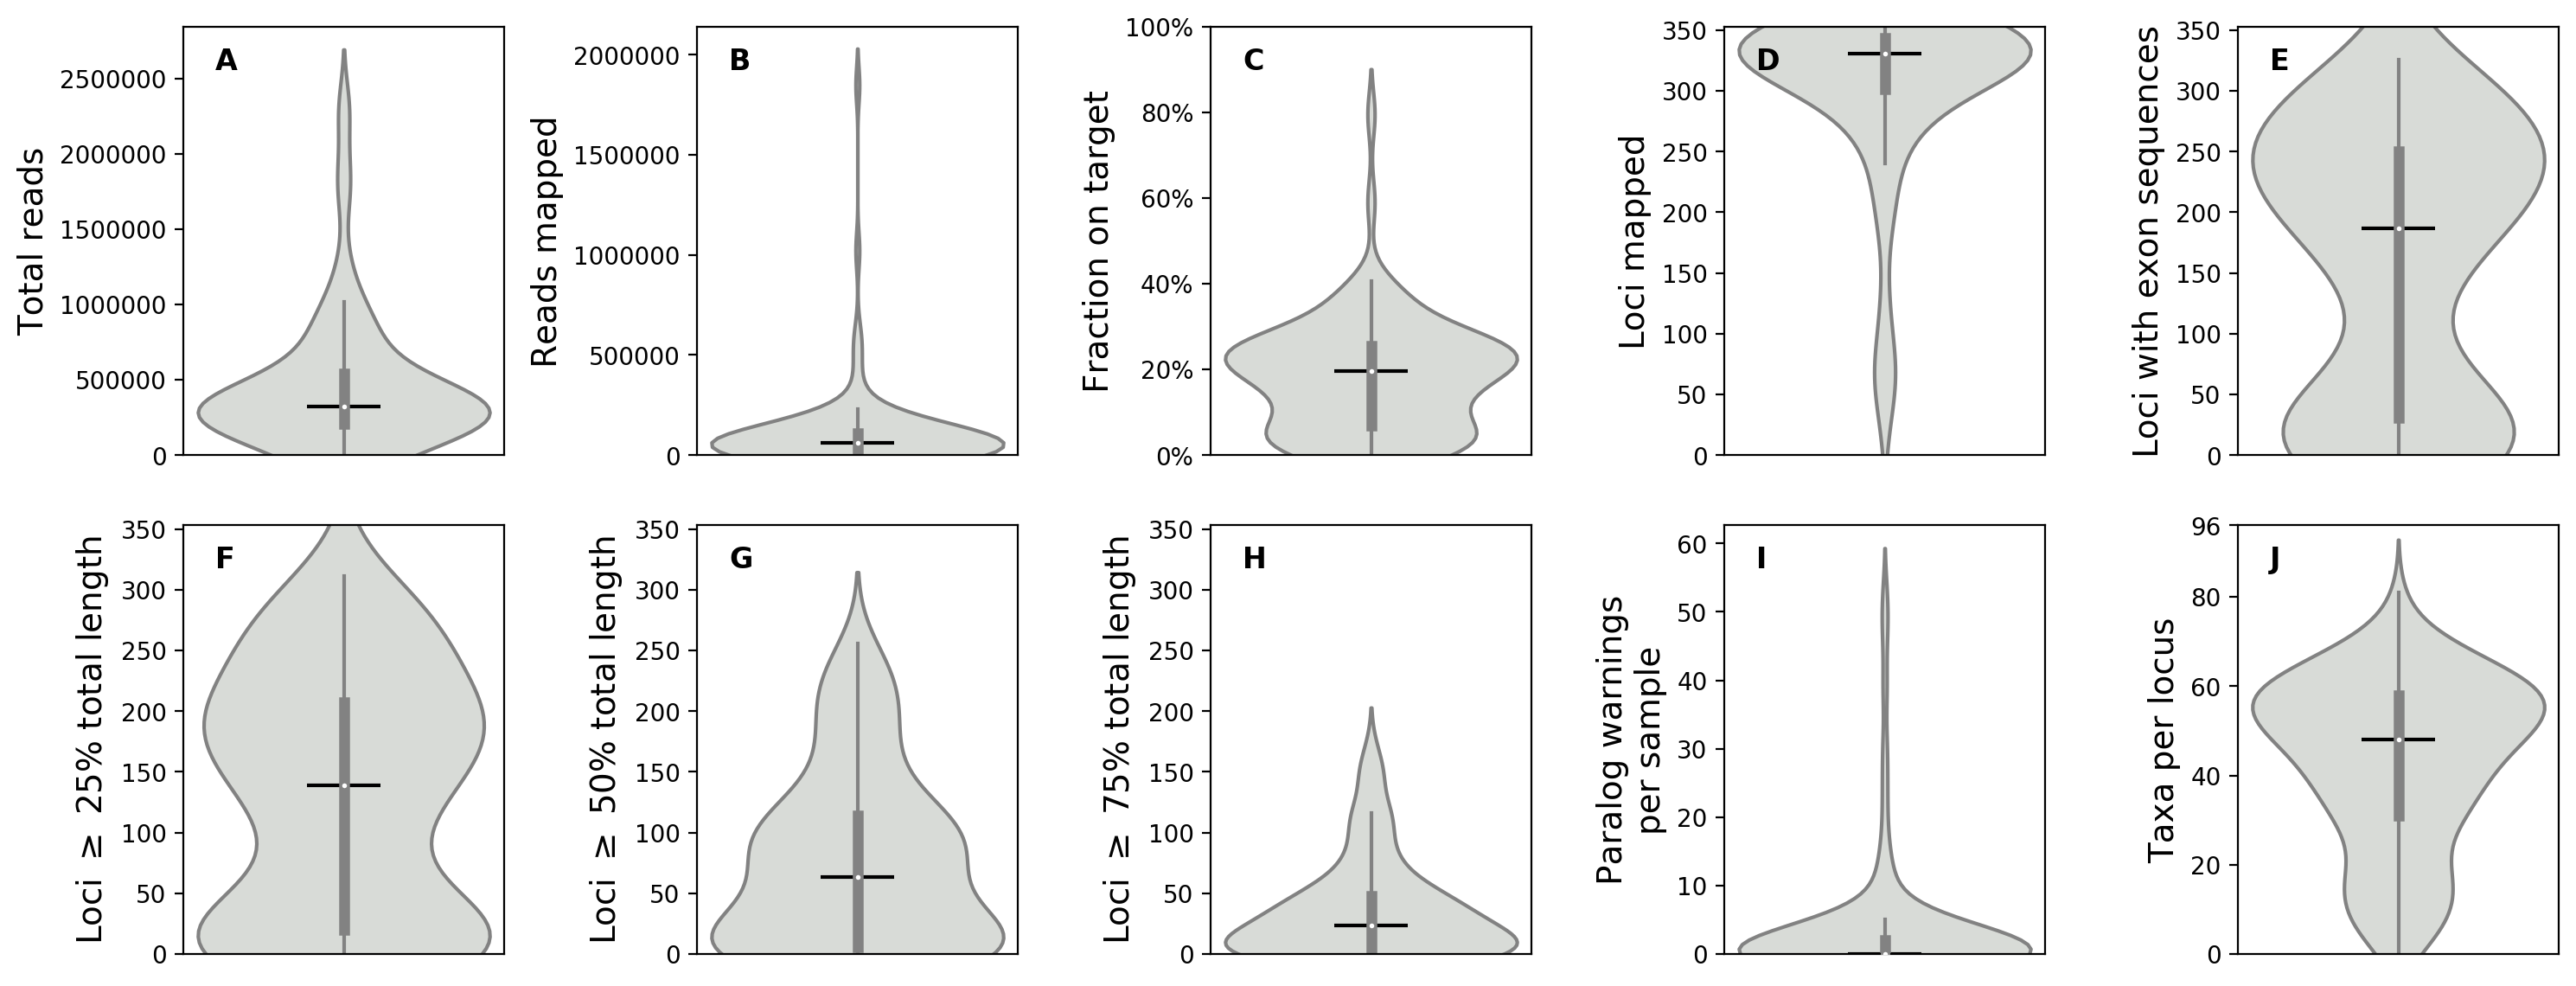

In [42]:
nrows = 2
ncols = 5

plt.style.use('default')
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols, 3*nrows))

j = 0
for i, col in enumerate(numeric_stats.columns):
    if col in ["pool", "Genesat150pct", "genus_factor", "cycles", "initial_ng_DNA", 
               "post_amp_ng_DNA", "initial_concentration", "GenesWithContigs"]:
        continue
    else:
        ax = axs.reshape(-1)[j]
        
        sns.violinplot(numeric_stats[col], inner='box', 
                       orient="v", ax = axs.reshape(-1)[j], color="xkcd:light grey")
        ax.hlines(y=numeric_stats[col].median(), xmin=-0.1, xmax=0.1, linestyle="-", color="black")
        ax.set_xticks([])

        if ax.get_ylim()[0] < 0:
            ax.set_ylim([0, ax.get_ylim()[1]])       

        if "GENES" in col.upper():
            ax.set_ylim([0, 353])
            
        if col.lower() == "numreads":
            ax.set_ylabel("Total reads", size=14)
        
        if col.lower() == "readsmapped":
            ax.set_ylabel("Reads mapped", size=14)
            
        if col.lower() == "pctontarget":
            ax.set_ylabel("Fraction on target", size=14)
            ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
            ax.set_yticklabels(["{}%".format(n) for n in [0, 20, 40, 60, 80, 100]])
        
        if col.lower() == "genesmapped":
            ax.set_ylabel("Loci mapped", size=14)
        
        if col.lower() == "geneswithcontigs":
            ax.set_ylabel("Loci with contigs", size=14)
        
        if col.lower() == "geneswithseqs":
            ax.set_ylabel("Loci with exon sequences", size=14)
            
        if col.upper().startswith("GENESAT"):
            ax.set_ylabel("Loci $\geq$ {}% total length".format(re.search("[\d]+", col)[0]), size=14)
            
        if col.lower() == "paralogwarnings":
            ax.set_ylabel("Paralog warnings\nper sample", size=14)

        j+=1

sns.violinplot(taxon_counts, inner='box', orient="v", ax = axs[1,4], color="xkcd:light grey")
axs[1,4].hlines(y=taxon_counts.median(), xmin=-0.1, xmax=0.1, linestyle="-", color="black")
axs[1,4].set_xticks([])
axs[1,4].set_ylim(0,96)
axs[1,4].set_yticks([0,20,40,60,80,96])
axs[1,4].set_yticklabels([0,20,40,60,80,96])
axs[1,4].set_ylabel("Taxa per locus", size=14)

for i, ax in enumerate(axs.flatten()):
    ax.annotate(string.ascii_uppercase[i], xy=(0.1, 0.9), xycoords="axes fraction",weight='bold', size=12)
    
plt.tight_layout()
plt.savefig('../Figures/Statistics/AppendixS2.recovery-violins.pdf', format='pdf', transparent=True, dpi=300, bbox_inches='tight')
plt.savefig('../Figures/Statistics/AppendixS2.recovery-violins.lowres.png', format='png', transparent=True, dpi=150, bbox_inches='tight')

In the figure above, violin plots show kernel density smoothed distributions with median (black horizontal bar), inner quartile range (thick vertical grey line), and 1.5x inner quartile range (thin grey line).

# Investigating differential success
It's clear that we had differential success in terms of locus recovery. To investigate why this might be, I'll first look into the correlation between sample/library prep and sequencing/recovery metrics. I'm dropping `Genesat150pct` because it was very low.

In [43]:
numeric_stats = numeric_stats.drop(labels=["Genesat150pct"], axis=1)

In [44]:
corrmat = numeric_stats.corr()

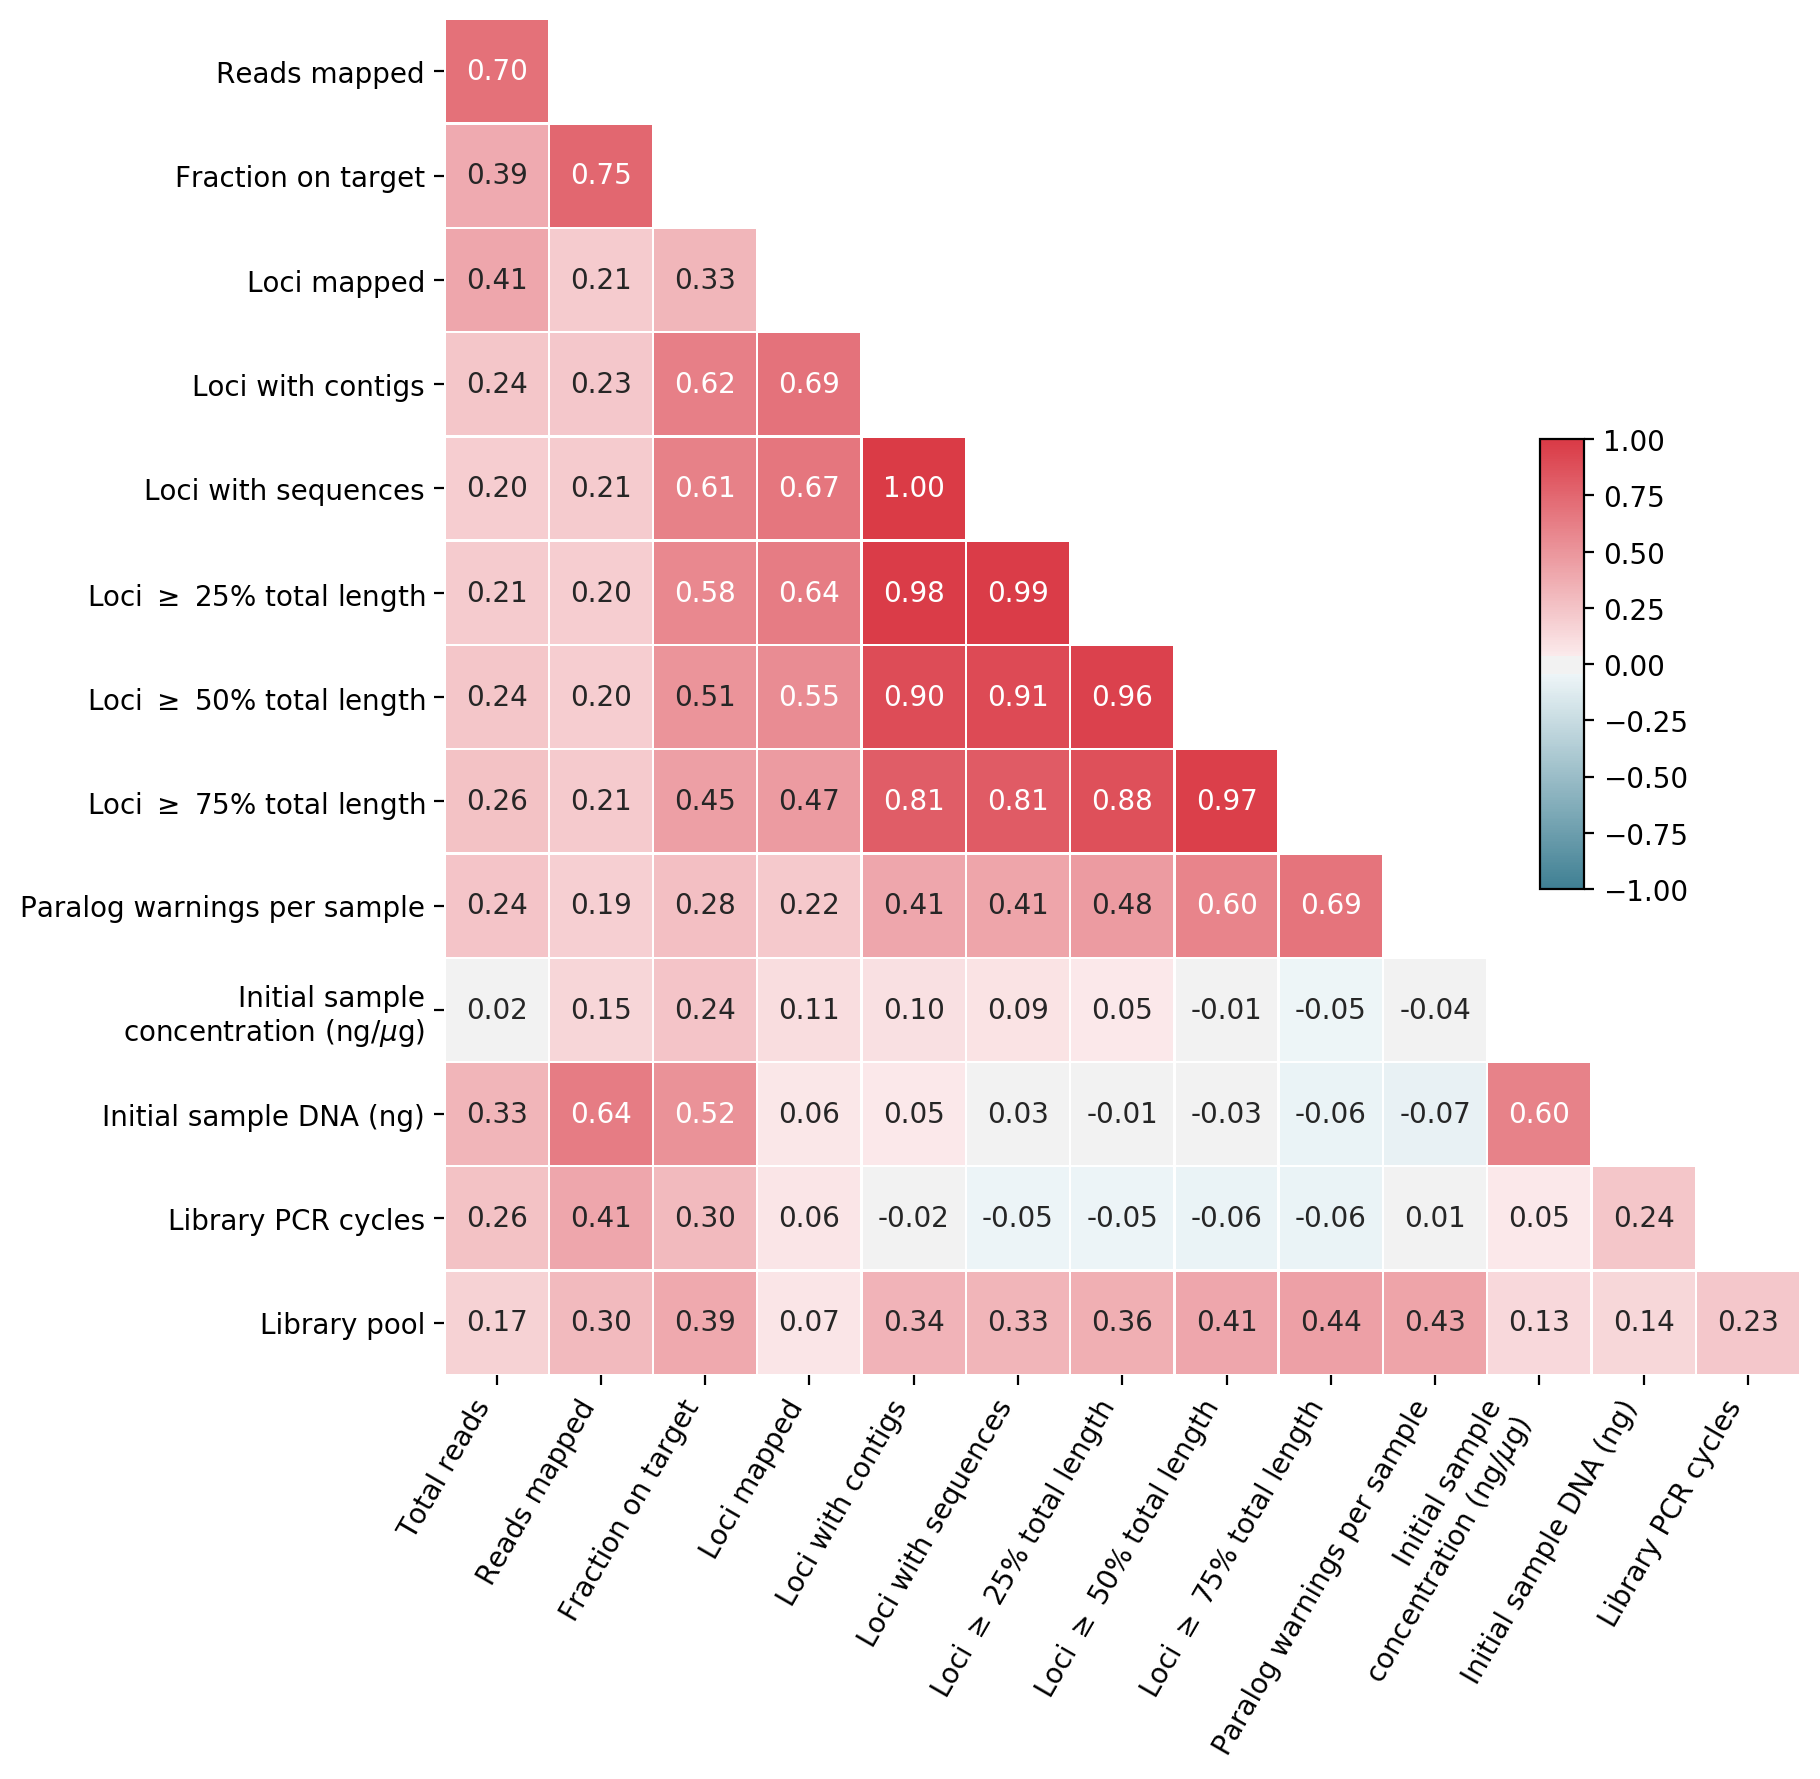

In [47]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corrmat, dtype=np.bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(h_neg=220, h_pos=10, as_cmap=True)

sns.heatmap(corrmat, mask=mask, cmap=cmap, vmin=-1.0, vmax=1.0, center=0, square=True, linewidths=.5, 
            cbar_kws={"shrink": .5}, annot=True, fmt=".2f", cbar=False)

ax.set_xticks(np.linspace(start=0.5, stop=15.5, num=16))
ax.set_yticks(np.linspace(start=0.5, stop=15.5, num=16))
ax.set_xticklabels([name_display_dict[c] for c in corrmat.columns][:-1], rotation=60, ha="right")
ax.set_yticklabels([name_display_dict[c] for c in corrmat.columns])

ax.set_xlim([0,13])
ax.set_ylim([14,1])

ax2 = fig.add_axes([0.75, 0.5, 0.02, 0.25])
norm = mcolors.Normalize(vmin=-1.0, vmax=1.0)
colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, orientation='vertical')

plt.tight_layout()

plt.savefig('../Figures/Statistics/Dipsacales-HybPiper-corrmat.pdf', format='pdf', transparent=True, dpi=300)
plt.savefig('../Figures/Statistics/Dipsacales-HybPiper-corrmat.lowres.png', format='png', transparent=True, dpi=300)

So it looks like there is maybe some relationship between the library pools and what we recovered, but I'll need to test this explicitly.

## Effects of library pooling

A useful guide to choosing tests is on the [`pingouin` site](https://pingouin-stats.org/guidelines.html). To test for pool differences we need to first establish whether or not these measurements are normally distributed. If they are normal, we can simply use one-way ANOVA to test for differences in pool means. If the data are *non*-normal, we'll use the [Kruskal-Wallis test](http://www.biostathandbook.com/kruskalwallis.html) to test if there are differences between library pools. However, as Dr. McDonald notes in his discussion of the Kruskal-Wall test, there are a few things we should make us cautious of using this over one-way ANOVA:

    - one-way ANOVA is not very sensitive to deviations from normality
    - the Kruskal-Wallis test will transform our data from nominal to ranked
    - the Kruskal-Wallis test assumes equal group variation (homoscedasticity)
        - Welch's ANOVA is an extension of ANOVA when data are hetroscedastic
    - non-parametric tests are usually less powerful than parametric tests

So using parametric, one-way ANOVA (or Welch's) may actually be a better choice than non-parametric tests if we are not severely violating assumptions. To decide which route to go I'll further test if the standard deviations within pools are similar enough under log-transformations.

In [48]:
log_numeric = pd.DataFrame([np.array(np.log10(numeric_stats["NumReads"])),
                            np.array(np.log10(numeric_stats["ReadsMapped"])),
                            np.array(np.log10(numeric_stats["PctOnTarget"]*100)),
                            np.array(np.log10(numeric_stats["initial_concentration"])),
                            np.array(np.log10(numeric_stats["initial_ng_DNA"])),
                            np.array(np.log10(numeric_stats["GenesWithSeqs"])),
                            numeric_stats["pool"]]).T
log_numeric.columns = ["NumReads", "ReadsMapped", "PctOnTarget", "initial_concentration", 
                       "initial_ng_DNA", "GenesWithSeqs", "pool"]
log_numeric = log_numeric.replace(-np.inf, 0)

### Reads per sample

In [49]:
print("Normality test")
normal_test(numeric_stats["NumReads"], alpha=0.01, log=False)

print("\nBarlett's test")
barlett = stats.bartlett(numeric_stats.loc[numeric_stats["pool"]==1]["NumReads"],
                         numeric_stats.loc[numeric_stats["pool"]==2]["NumReads"],
                         numeric_stats.loc[numeric_stats["pool"]==3]["NumReads"],
                         numeric_stats.loc[numeric_stats["pool"]==4]["NumReads"],
                         numeric_stats.loc[numeric_stats["pool"]==5]["NumReads"],
                         numeric_stats.loc[numeric_stats["pool"]==6]["NumReads"],
                         numeric_stats.loc[numeric_stats["pool"]==7]["NumReads"],
                         numeric_stats.loc[numeric_stats["pool"]==8]["NumReads"])
print(barlett)

print("\nLog-transformed normality test")
normal_test(log_numeric["NumReads"], alpha=0.01, log=False)

print("\nLog-transformed Barlett's test")
barlett = stats.bartlett(log_numeric.loc[log_numeric["pool"]==1]["NumReads"],
                         log_numeric.loc[log_numeric["pool"]==2]["NumReads"],
                         log_numeric.loc[log_numeric["pool"]==3]["NumReads"],
                         log_numeric.loc[log_numeric["pool"]==4]["NumReads"],
                         log_numeric.loc[log_numeric["pool"]==5]["NumReads"],
                         log_numeric.loc[log_numeric["pool"]==6]["NumReads"],
                         log_numeric.loc[log_numeric["pool"]==7]["NumReads"],
                         log_numeric.loc[log_numeric["pool"]==8]["NumReads"])
print(barlett)

print("\nLog-transformed Welch's ANOVA")
pg.print_table(pg.welch_anova(dv="NumReads", between="pool", data=log_numeric))

print("\nLog-transformed Krusckal-Wallis test")
pg.print_table(pg.kruskal(data=log_numeric, dv="NumReads", between="pool"))

Normality test
p = 7.51003e-14
The null hypothesis can be rejected. Data are not-normal.

Barlett's test
BartlettResult(statistic=28.732798779925478, pvalue=0.00016185003304008798)

Log-transformed normality test
p = 7.75627e-11
The null hypothesis can be rejected. Data are not-normal.

Log-transformed Barlett's test
BartlettResult(statistic=20.67000427821876, pvalue=0.004290530449345268)

Log-transformed Welch's ANOVA

ANOVA SUMMARY

Source      ddof1    ddof2      F    p-unc    np2
--------  -------  -------  -----  -------  -----
pool            7   37.163  0.412    0.889  0.041


Log-transformed Krusckal-Wallis test
Source      ddof1       H    p-unc
--------  -------  ------  -------
pool            7  10.529    0.161



- Read counts are **non-normally** distributed, whether raw or transformed
- The pools have **unequal variances** and variance is smaller when data are **log-transformed**
- **Welch's ANOVA** and **KW test** using **log-transformed** are both **non-significant**

**Therefore is does not appear that pools received unequal numbers of reads per individual.**

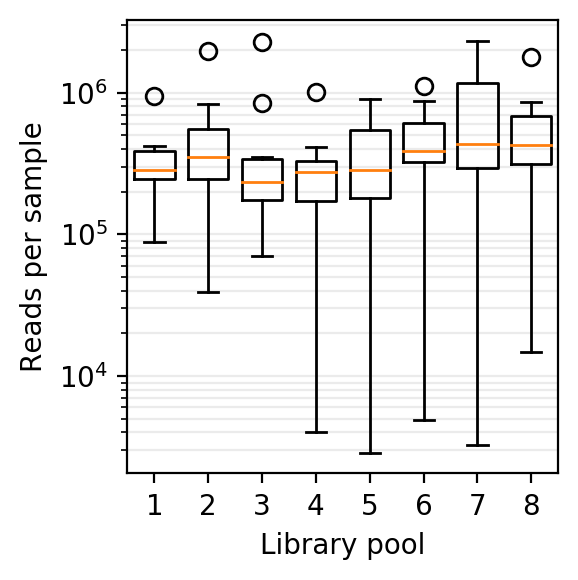

In [58]:
fig, ax = plt.subplots(figsize=(3,3))

for i in range(1,9):
    ax.boxplot(numeric_stats.loc[numeric_stats["pool"]==i]["NumReads"], widths=[0.75],
               bootstrap=100, positions=[i])

ax.semilogy()
ax.set_xlabel("Library pool")
ax.set_ylabel("Reads per sample")
ax.grid(axis='y', which='both', alpha=0.25)
plt.tight_layout()

### Reads mapped

In [51]:
print("Normality test")
normal_test(numeric_stats["ReadsMapped"], alpha=0.01, log=False)

print("\nBarlett's test")
barlett = stats.bartlett(numeric_stats.loc[numeric_stats["pool"]==1]["ReadsMapped"],
                         numeric_stats.loc[numeric_stats["pool"]==2]["ReadsMapped"],
                         numeric_stats.loc[numeric_stats["pool"]==3]["ReadsMapped"],
                         numeric_stats.loc[numeric_stats["pool"]==4]["ReadsMapped"],
                         numeric_stats.loc[numeric_stats["pool"]==5]["ReadsMapped"],
                         numeric_stats.loc[numeric_stats["pool"]==6]["ReadsMapped"],
                         numeric_stats.loc[numeric_stats["pool"]==7]["ReadsMapped"],
                         numeric_stats.loc[numeric_stats["pool"]==8]["ReadsMapped"])
print(barlett)

print("\nLog-transformed normality test")
normal_test(log_numeric["ReadsMapped"], alpha=0.01, log=False)

print("\nLog-transformed Barlett's test")
barlett = stats.bartlett(log_numeric.loc[log_numeric["pool"]==1]["ReadsMapped"],
                         log_numeric.loc[log_numeric["pool"]==2]["ReadsMapped"],
                         log_numeric.loc[log_numeric["pool"]==3]["ReadsMapped"],
                         log_numeric.loc[log_numeric["pool"]==4]["ReadsMapped"],
                         log_numeric.loc[log_numeric["pool"]==5]["ReadsMapped"],
                         log_numeric.loc[log_numeric["pool"]==6]["ReadsMapped"],
                         log_numeric.loc[log_numeric["pool"]==7]["ReadsMapped"],
                         log_numeric.loc[log_numeric["pool"]==8]["ReadsMapped"])
print(barlett)

print("\nLog-transformed Welch's ANOVA")
pg.print_table(pg.welch_anova(dv="ReadsMapped", between="pool", data=log_numeric))

print("\nLog-transformed Krusckal-Wallis test")
pg.print_table(pg.kruskal(data=log_numeric, dv="ReadsMapped", between="pool"))

Normality test
p = 8.58714e-33
The null hypothesis can be rejected. Data are not-normal.

Barlett's test
BartlettResult(statistic=192.82647434195218, pvalue=3.787197387259738e-38)

Log-transformed normality test
p = 0.00286345
The null hypothesis can be rejected. Data are not-normal.

Log-transformed Barlett's test
BartlettResult(statistic=22.486163351137964, pvalue=0.002093539722382008)

Log-transformed Welch's ANOVA

ANOVA SUMMARY

Source      ddof1    ddof2      F    p-unc    np2
--------  -------  -------  -----  -------  -----
pool            7   36.816  8.211    0.000  0.252


Log-transformed Krusckal-Wallis test
Source      ddof1       H    p-unc
--------  -------  ------  -------
pool            7  33.419    0.000



- Reads mapped are **non-normally** distributed, whether raw or transformed
- The pools have **unequal variances** and variance is much smaller when data are **log-transformed**
- **Welch's ANOVA** and **KW test** using **log-transformed** are both **highly significant**

**Therefore, the number of mapped reads per individual is significantly different between pools.** I expect this pattern to extend to the percent of reads on target.

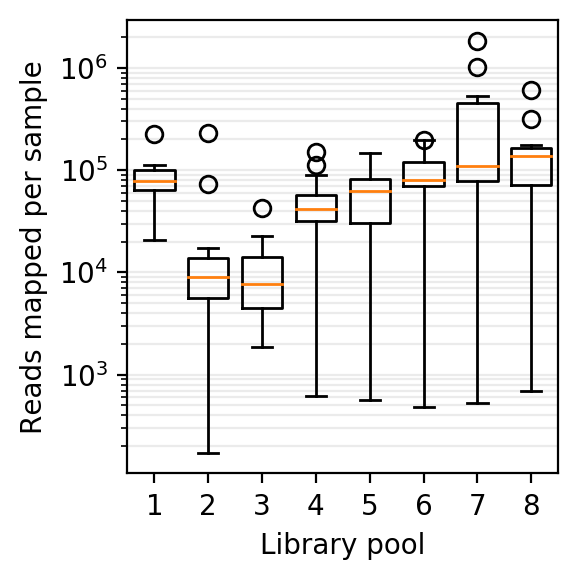

In [57]:
fig, ax = plt.subplots(figsize=(3,3))

for i in range(1,9):
    ax.boxplot(numeric_stats.loc[numeric_stats["pool"]==i]["ReadsMapped"], widths=[0.75],
               bootstrap=100, positions=[i])

ax.semilogy()
ax.set_xlabel("Library pool")
ax.set_ylabel("Reads mapped per sample")
ax.grid(axis='y', which='both', alpha=0.25)
plt.tight_layout()

### Fraction of reads on target

In [55]:
print("Normality test")
normal_test(numeric_stats["PctOnTarget"], alpha=0.01, log=False)

print("\nBarlett's test")
barlett = stats.bartlett(numeric_stats.loc[numeric_stats["pool"]==1]["PctOnTarget"],
                         numeric_stats.loc[numeric_stats["pool"]==2]["PctOnTarget"],
                         numeric_stats.loc[numeric_stats["pool"]==3]["PctOnTarget"],
                         numeric_stats.loc[numeric_stats["pool"]==4]["PctOnTarget"],
                         numeric_stats.loc[numeric_stats["pool"]==5]["PctOnTarget"],
                         numeric_stats.loc[numeric_stats["pool"]==6]["PctOnTarget"],
                         numeric_stats.loc[numeric_stats["pool"]==7]["PctOnTarget"],
                         numeric_stats.loc[numeric_stats["pool"]==8]["PctOnTarget"])
print(barlett)

print("\nLog-transformed normality test")
normal_test(log_numeric["PctOnTarget"], alpha=0.01, log=False)

print("\nLog-transformed Barlett's test")
barlett = stats.bartlett(log_numeric.loc[log_numeric["pool"]==1]["PctOnTarget"],
                         log_numeric.loc[log_numeric["pool"]==2]["PctOnTarget"],
                         log_numeric.loc[log_numeric["pool"]==3]["PctOnTarget"],
                         log_numeric.loc[log_numeric["pool"]==4]["PctOnTarget"],
                         log_numeric.loc[log_numeric["pool"]==5]["PctOnTarget"],
                         log_numeric.loc[log_numeric["pool"]==6]["PctOnTarget"],
                         log_numeric.loc[log_numeric["pool"]==7]["PctOnTarget"],
                         log_numeric.loc[log_numeric["pool"]==8]["PctOnTarget"])
print(barlett)

print("\nLog-transformed Welch's ANOVA")
pg.print_table(pg.welch_anova(dv="PctOnTarget", between="pool", data=log_numeric))

print("\nLog-transformed Krusckal-Wallis test")
pg.print_table(pg.kruskal(data=log_numeric, dv="PctOnTarget", between="pool"))

Normality test
p = 5.54648e-08
The null hypothesis can be rejected. Data are not-normal.

Barlett's test
BartlettResult(statistic=86.83575306924652, pvalue=5.515560749085978e-16)

Log-transformed normality test
p = 0.000795709
The null hypothesis can be rejected. Data are not-normal.

Log-transformed Barlett's test
BartlettResult(statistic=54.80953300460032, pvalue=1.6262326017238918e-09)

Log-transformed Welch's ANOVA

ANOVA SUMMARY

Source      ddof1    ddof2       F    p-unc    np2
--------  -------  -------  ------  -------  -----
pool            7   34.544  50.564    0.000  0.758


Log-transformed Krusckal-Wallis test
Source      ddof1       H    p-unc
--------  -------  ------  -------
pool            7  59.764    0.000



- Mapping efficiency is **non-normally** distributed, whether raw or transformed
- The pools have **unequal variances** and variance is smaller when data are **log-transformed**
- **Welch's ANOVA** and **KW test** using **log-transformed** are both **highly significant**

**Therefore, the fraction of reads on target per individual is significantly different between pools.**

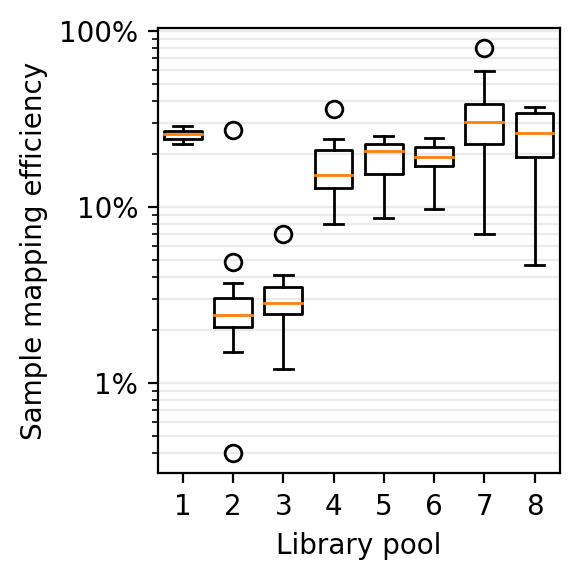

In [56]:
fig, ax = plt.subplots(figsize=(3,3))

for i in range(1,9):
    ax.boxplot(numeric_stats.loc[numeric_stats["pool"]==i]["PctOnTarget"], widths=[0.75],
               bootstrap=100, positions=[i])

ax.semilogy()
ax.set_xlabel("Library pool")
ax.set_ylabel("Sample mapping efficiency")
ax.set_yticks([0.01, 0.1, 1.0])
ax.set_yticklabels(["1%", "10%", "100%"])
ax.grid(axis='y', which='both', alpha=0.25)
plt.tight_layout()

### Genes with exon sequences

In [59]:
print("Normality test")
normal_test(numeric_stats["GenesWithSeqs"], alpha=0.01, log=False)

print("\nBarlett's test")
barlett = stats.bartlett(numeric_stats.loc[numeric_stats["pool"]==1]["GenesWithSeqs"],
                         numeric_stats.loc[numeric_stats["pool"]==2]["GenesWithSeqs"],
                         numeric_stats.loc[numeric_stats["pool"]==3]["GenesWithSeqs"],
                         numeric_stats.loc[numeric_stats["pool"]==4]["GenesWithSeqs"],
                         numeric_stats.loc[numeric_stats["pool"]==5]["GenesWithSeqs"],
                         numeric_stats.loc[numeric_stats["pool"]==6]["GenesWithSeqs"],
                         numeric_stats.loc[numeric_stats["pool"]==7]["GenesWithSeqs"],
                         numeric_stats.loc[numeric_stats["pool"]==8]["GenesWithSeqs"])
print(barlett)

print("\nLog-transformed normality test")
normal_test(log_numeric["GenesWithSeqs"], alpha=0.01, log=False)

print("\nLog-transformed Barlett's test")
barlett = stats.bartlett(log_numeric.loc[log_numeric["pool"]==1]["GenesWithSeqs"],
                         log_numeric.loc[log_numeric["pool"]==2]["GenesWithSeqs"],
                         log_numeric.loc[log_numeric["pool"]==3]["GenesWithSeqs"],
                         log_numeric.loc[log_numeric["pool"]==4]["GenesWithSeqs"],
                         log_numeric.loc[log_numeric["pool"]==5]["GenesWithSeqs"],
                         log_numeric.loc[log_numeric["pool"]==6]["GenesWithSeqs"],
                         log_numeric.loc[log_numeric["pool"]==7]["GenesWithSeqs"],
                         log_numeric.loc[log_numeric["pool"]==8]["GenesWithSeqs"])
print(barlett)

print("\nLog-transformed Welch's ANOVA")
pg.print_table(pg.welch_anova(dv="GenesWithSeqs", between="pool", data=log_numeric))

print("\nKrusckal-Wallis test")
pg.print_table(pg.kruskal(data=numeric_stats, dv="GenesWithSeqs", between="pool"))

Normality test
p = 6.51721e-47
The null hypothesis can be rejected. Data are not-normal.

Barlett's test
BartlettResult(statistic=29.9067871939113, pvalue=9.877160785385423e-05)

Log-transformed normality test
p = 4.41935e-05
The null hypothesis can be rejected. Data are not-normal.

Log-transformed Barlett's test
BartlettResult(statistic=49.314547650618884, pvalue=1.968715779621416e-08)

Log-transformed Welch's ANOVA

ANOVA SUMMARY

Source      ddof1    ddof2       F    p-unc    np2
--------  -------  -------  ------  -------  -----
pool            7   33.590  15.360    0.000  0.279


Krusckal-Wallis test
Source      ddof1       H    p-unc
--------  -------  ------  -------
pool            7  37.959    0.000



- The number of genes with exon sequence is **non-normally** distributed, whether raw or transformed
    - It is closer to normal when raw
- The pools have **unequal variances** and variance is smaller when data are **log-transformed**
    - Pools are more homoscedastic when log transformed
- **Welch's ANOVA** using **log-transformed** data and **KW test** using **raw** data are both **highly significant**

**Therefore, the number of genes with contigs per individual is significantly different between pools.**

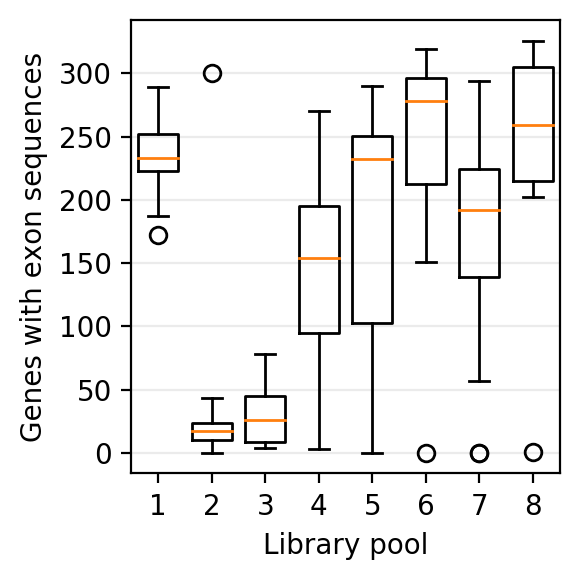

In [61]:
fig, ax = plt.subplots(figsize=(3,3))

for i in range(1,9):
    ax.boxplot(numeric_stats.loc[numeric_stats["pool"]==i]["GenesWithSeqs"], widths=[0.75],
               bootstrap=100, positions=[i])

ax.set_xlabel("Library pool")
ax.set_ylabel("Genes with exon sequences")
ax.grid(axis='y', which='both', alpha=0.25)

plt.tight_layout()

In summary, we found the `ReadsMapped`, `PctOnTarget`, and `GenesWithContigs` varied between pools. Now we can run a Dunn's test to find where population means differ.

In [62]:
dunn_readsmapped = skph.posthoc_dunn(log_numeric, val_col='ReadsMapped', group_col="pool", p_adjust=None, sort=True)
dunn_ontarget = skph.posthoc_dunn(log_numeric, val_col='PctOnTarget', group_col="pool", p_adjust=None, sort=True)
dunn_gwc = skph.posthoc_dunn(numeric_stats, val_col='GenesWithSeqs', group_col="pool", p_adjust=None, sort=True)

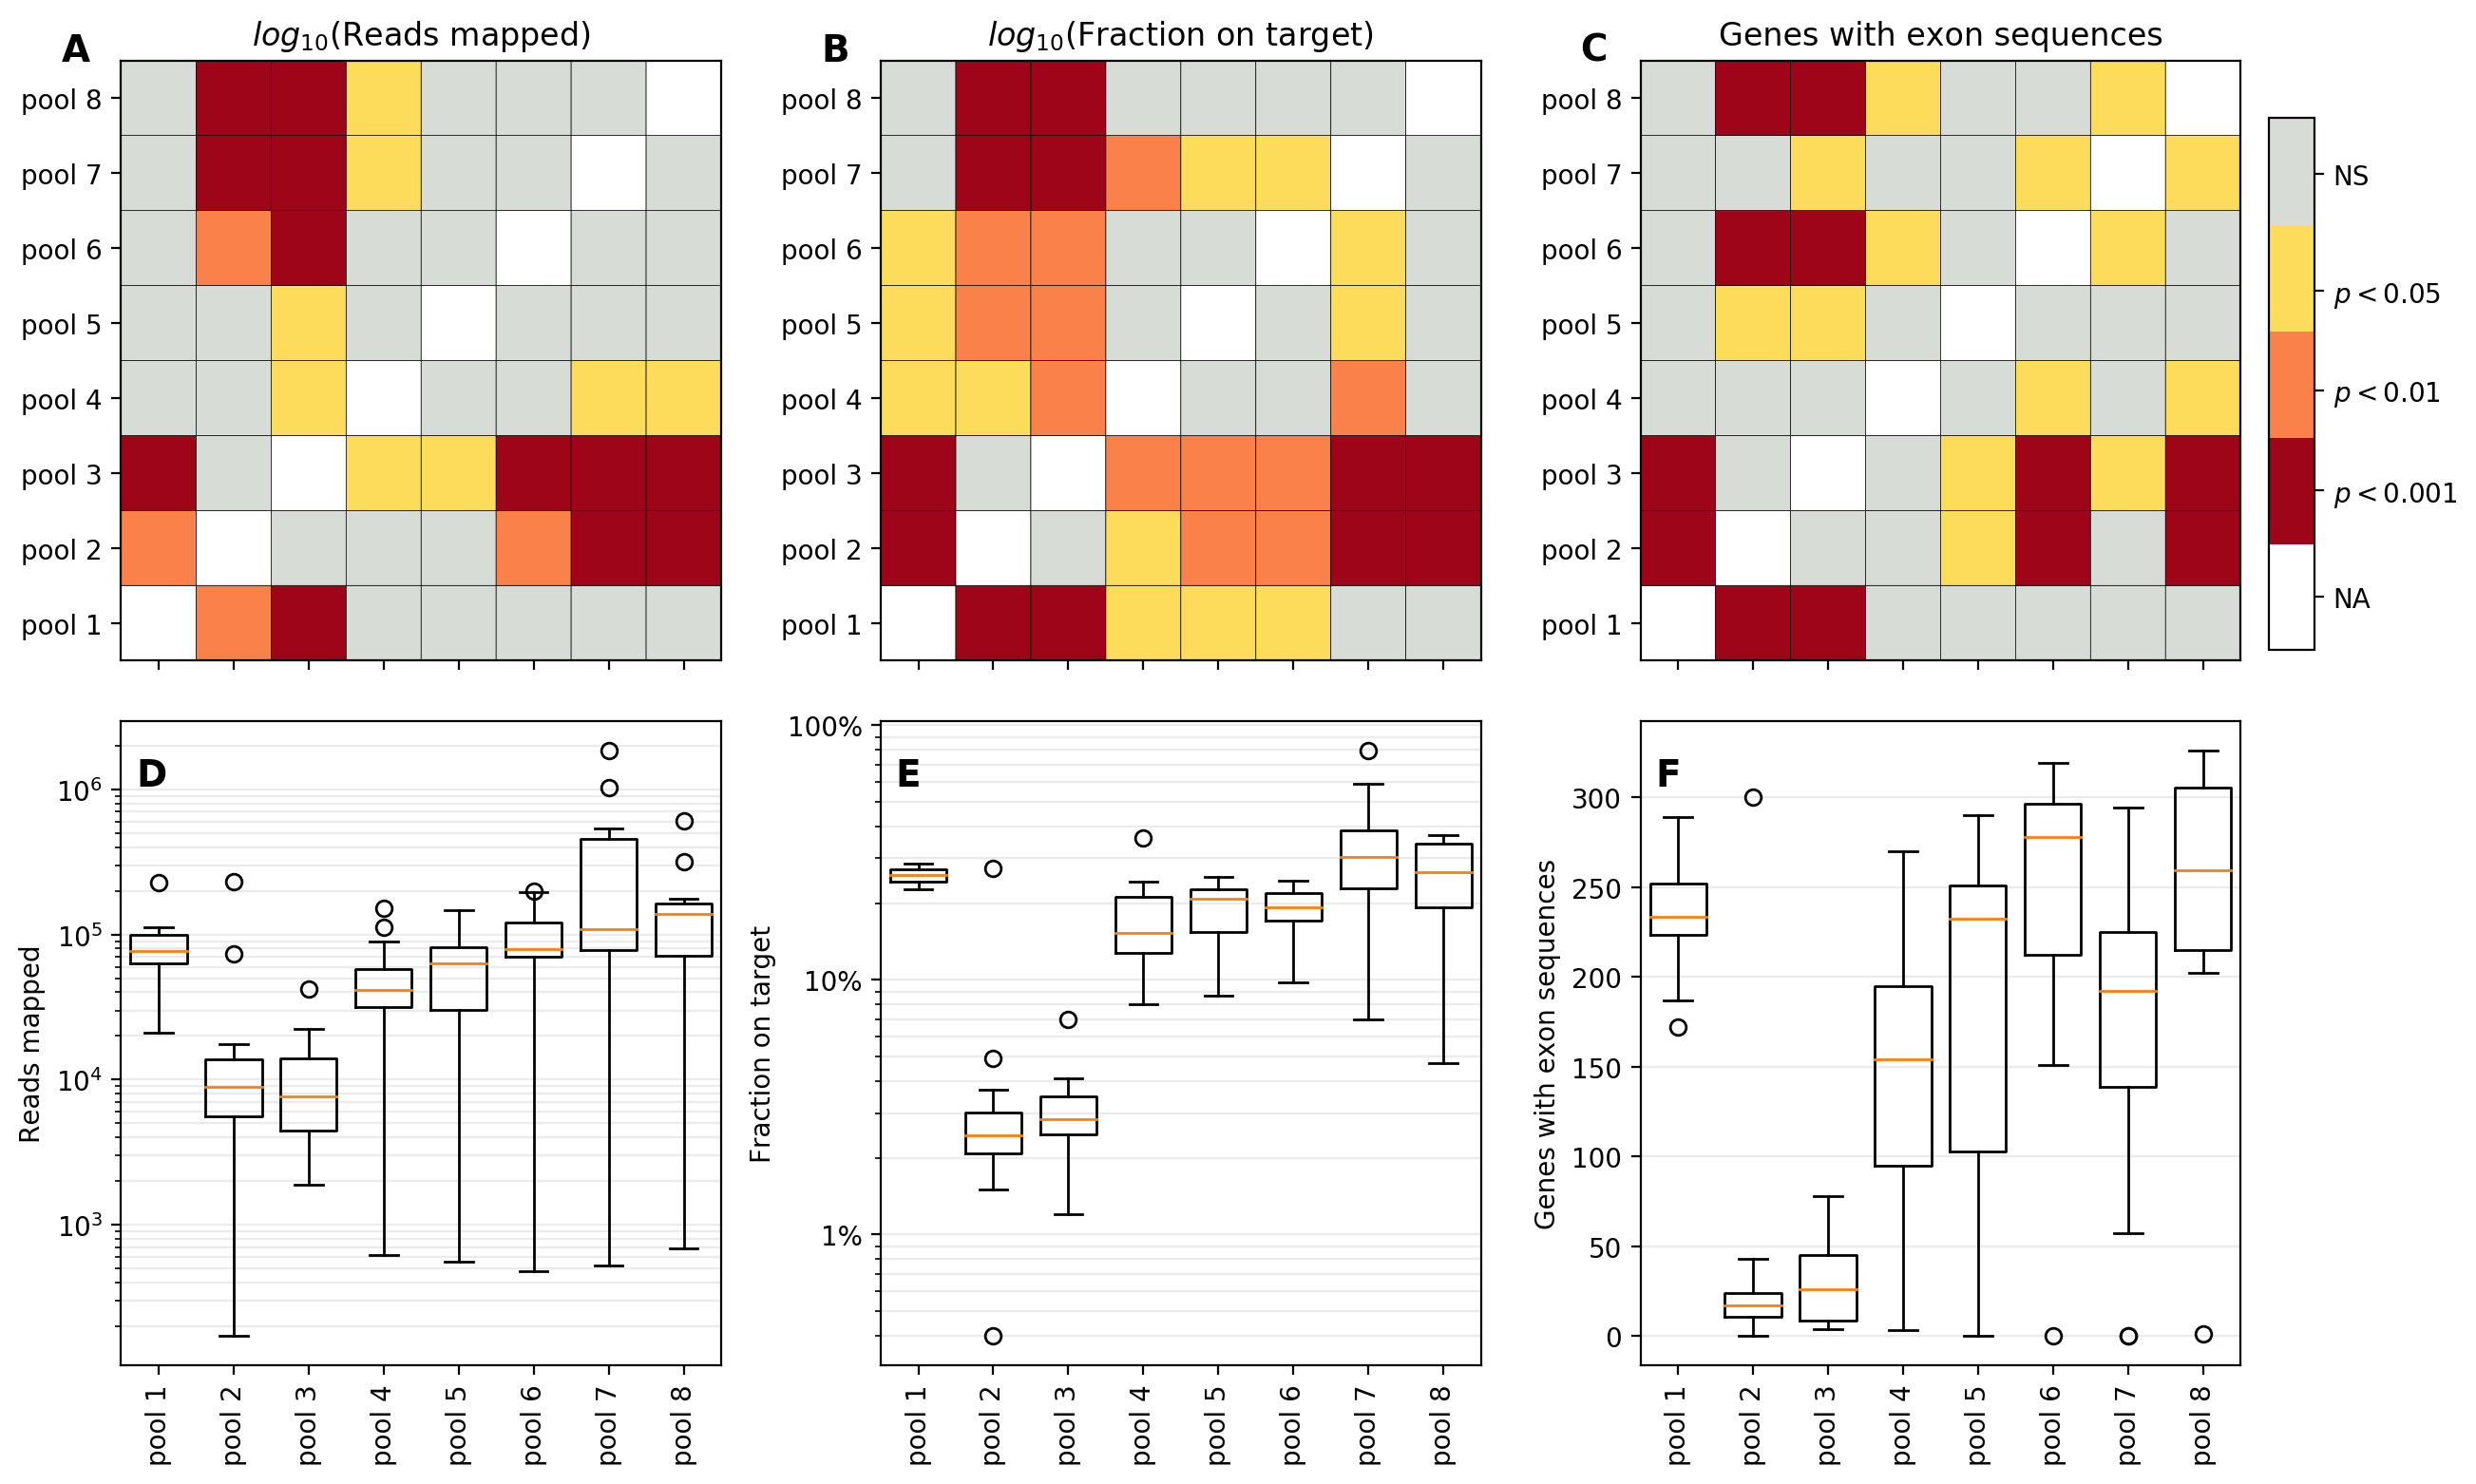

In [65]:
plt.style.use('default')
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12,8), sharex=True)

cmaplist = ["white", "xkcd:carmine", "xkcd:orangish", "xkcd:light gold", "xkcd:light grey"]
cmap = mcolors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)
bounds = [-1, 0.0, 0.001, 0.01, 0.05, 1.0]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

pmap_rm = ax[0,0].pcolor(dunn_readsmapped, cmap=cmap, norm=norm, edgecolors="black")
pmap_ot = ax[0,1].pcolor(dunn_ontarget, cmap=cmap, norm=norm, edgecolors="black")
pmap_gwc = ax[0,2].pcolor(dunn_gwc, cmap=cmap, norm=norm, edgecolors="black")

cax = fig.add_axes([ax[0,-1].get_position().x1+0.1, ax[0,-1].get_position().y0+0.025, 
                    0.02, ax[0,-1].get_position().height])
cbar = plt.colorbar(pmap_gwc, cax=cax, cmap=cmap, norm=norm, boundaries=bounds, ticks=[-0.5, 0.0005, 0.005, 0.025, 0.5])
cbar.ax.set_yticklabels(["NA", "$p<0.001$", "$p<0.01$", "$p<0.05$", "NS"])

for i in range(1,9):
    ax[1,0].boxplot(numeric_stats.loc[numeric_stats["pool"]==i]["ReadsMapped"], widths=[0.75],
               bootstrap=1000, positions=[i-0.5])
    ax[1,1].boxplot(numeric_stats.loc[numeric_stats["pool"]==i]["PctOnTarget"], widths=[0.75],
               bootstrap=1000, positions=[i-0.5])
    ax[1,2].boxplot(numeric_stats.loc[numeric_stats["pool"]==i]["GenesWithSeqs"], widths=[0.75],
               bootstrap=1000, positions=[i-0.5])

ax[0,0].set_title("$log_{10}($Reads mapped$)$")
ax[0,1].set_title("$log_{10}($Fraction on target$)$")
ax[0,2].set_title("Genes with exon sequences")

for i in range(3):
    ax[0,i].set_aspect('equal','box')

    ax[0,i].set_yticks(np.linspace(0.5, 7.5, 8))
    ax[0,i].set_yticklabels(["pool {}".format(i) for i in range(1,9)])
    
    ax[1,i].grid(axis="y", which="both", alpha=0.25)
    ax[1,i].set_xticks(np.linspace(0.5, 7.5, 8))
    ax[1,i].set_xticklabels(["pool {}".format(i) for i in range(1,9)], rotation=90)

for i, axis in enumerate(ax.flatten()):
    if i<3:
        axis.annotate(string.ascii_uppercase[i], xy=(-0.1, 1.), xycoords="axes fraction", 
                        weight='bold', size=14)
    else:
        axis.annotate(string.ascii_uppercase[i], xy=(0.025, 0.90), xycoords="axes fraction", 
                        weight='bold', size=14)

ax[1,0].semilogy()
ax[1,1].semilogy()
ax[1,1].set_yticks([0.01, 0.1, 1.0])
ax[1,1].set_yticklabels(["1%", "10%", "100%"])

ax[1,0].set_ylabel("Reads mapped")
ax[1,1].set_ylabel("Fraction on target")
ax[1,2].set_ylabel("Genes with exon sequences")

plt.tight_layout()
plt.savefig("../Figures/Statistics/AppendixS3-Pooling-Read-Stats.pdf", format='pdf', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig("../Figures/Statistics/AppendixS3-Pooling-Read-Stats.lowres.png", format="png", dpi=150, transparent=True, bbox_inches="tight")

As a reminder, orange bars show medians, boxes show IQR, whiskers show 1.5\*IQR, and open points are outliers. 

## Effects of sample quality
We were able to detect batch effects in our enrichment and recovery. Now I'll see if there are similar patterns in sample quality that may be responsible for the lower success in pools 2 and 3. Namely, I'll be looking at in initial sample concentration and DNA mass. Low concentration samples are likely lower quality extractions, and the library preparation required a minimum of 200ng DNA. 

### Initial sample concentration

In [66]:
print("Normality test")
normal_test(numeric_stats["initial_concentration"], alpha=0.01, log=False)

print("\nBarlett's test")
barlett = stats.bartlett(numeric_stats.loc[numeric_stats["pool"]==1]["initial_concentration"],
                         numeric_stats.loc[numeric_stats["pool"]==2]["initial_concentration"],
                         numeric_stats.loc[numeric_stats["pool"]==3]["initial_concentration"],
                         numeric_stats.loc[numeric_stats["pool"]==4]["initial_concentration"],
                         numeric_stats.loc[numeric_stats["pool"]==5]["initial_concentration"],
                         numeric_stats.loc[numeric_stats["pool"]==6]["initial_concentration"],
                         numeric_stats.loc[numeric_stats["pool"]==7]["initial_concentration"],
                         numeric_stats.loc[numeric_stats["pool"]==8]["initial_concentration"])
print(barlett)

print("\nLog-transformed normality test")
normal_test(log_numeric["initial_concentration"], alpha=0.01, log=False)

print("\nLog-transformed Barlett's test")
barlett = stats.bartlett(log_numeric.loc[log_numeric["pool"]==1]["initial_concentration"],
                         log_numeric.loc[log_numeric["pool"]==2]["initial_concentration"],
                         log_numeric.loc[log_numeric["pool"]==3]["initial_concentration"],
                         log_numeric.loc[log_numeric["pool"]==4]["initial_concentration"],
                         log_numeric.loc[log_numeric["pool"]==5]["initial_concentration"],
                         log_numeric.loc[log_numeric["pool"]==6]["initial_concentration"],
                         log_numeric.loc[log_numeric["pool"]==7]["initial_concentration"],
                         log_numeric.loc[log_numeric["pool"]==8]["initial_concentration"])
print(barlett)

print("\nLog-transformed one-way ANOVA")
pg.print_table(pg.anova(dv="initial_concentration", between="pool", data=log_numeric))

Normality test
p = 1.1734e-25
The null hypothesis can be rejected. Data are not-normal.

Barlett's test
BartlettResult(statistic=111.83472705722245, pvalue=3.821079293201155e-21)

Log-transformed normality test
p = 0.140895
The null hypothesis cannot be rejected. Data are normal.

Log-transformed Barlett's test
BartlettResult(statistic=9.318020931532134, pvalue=0.23062263124918805)

Log-transformed one-way ANOVA

ANOVA SUMMARY

Source      ddof1    ddof2      F    p-unc    np2
--------  -------  -------  -----  -------  -----
pool            7       88  2.976    0.008  0.191



The **log-transformed data are normal with relatively equal variances**, so I applied a standard **one-way ANOVA** on the log-transformed data. This showed that there are indeed **differences in group means**.

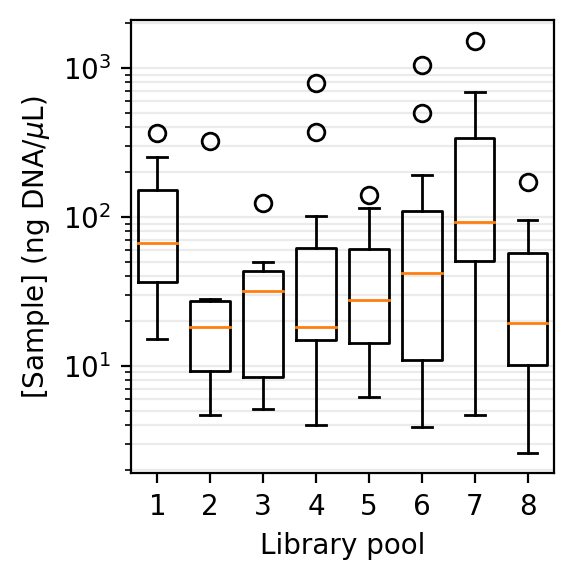

In [67]:
fig, ax = plt.subplots(figsize=(3,3))

for i in range(1,9):
    ax.boxplot(numeric_stats.loc[numeric_stats["pool"]==i]["initial_concentration"], widths=[0.75],
               bootstrap=100, positions=[i])
ax.semilogy()
ax.set_xlabel("Library pool")
ax.set_ylabel("[Sample] (ng DNA/$\mu$L)")
ax.grid(axis='y', which='both', alpha=0.25)

plt.tight_layout()

In [68]:
print("Normality test")
normal_test(numeric_stats["initial_ng_DNA"], alpha=0.01, log=False)

print("\nBarlett's test")
barlett = stats.bartlett(numeric_stats.loc[numeric_stats["pool"]==1]["initial_ng_DNA"],
                         numeric_stats.loc[numeric_stats["pool"]==2]["initial_ng_DNA"],
                         numeric_stats.loc[numeric_stats["pool"]==3]["initial_ng_DNA"],
                         numeric_stats.loc[numeric_stats["pool"]==4]["initial_ng_DNA"],
                         numeric_stats.loc[numeric_stats["pool"]==5]["initial_ng_DNA"],
                         numeric_stats.loc[numeric_stats["pool"]==6]["initial_ng_DNA"],
                         numeric_stats.loc[numeric_stats["pool"]==7]["initial_ng_DNA"],
                         numeric_stats.loc[numeric_stats["pool"]==8]["initial_ng_DNA"])
print(barlett)

print("\nLog-transformed normality test")
normal_test(log_numeric["initial_ng_DNA"], alpha=0.01, log=False)

print("\nLog-transformed Barlett's test")
barlett = stats.bartlett(log_numeric.loc[log_numeric["pool"]==1]["initial_ng_DNA"],
                         log_numeric.loc[log_numeric["pool"]==2]["initial_ng_DNA"],
                         log_numeric.loc[log_numeric["pool"]==3]["initial_ng_DNA"],
                         log_numeric.loc[log_numeric["pool"]==4]["initial_ng_DNA"],
                         log_numeric.loc[log_numeric["pool"]==5]["initial_ng_DNA"],
                         log_numeric.loc[log_numeric["pool"]==6]["initial_ng_DNA"],
                         log_numeric.loc[log_numeric["pool"]==7]["initial_ng_DNA"],
                         log_numeric.loc[log_numeric["pool"]==8]["initial_ng_DNA"])
print(barlett)

print("\nLog-transformed one-way ANOVA")
pg.print_table(pg.anova(dv="initial_ng_DNA", between="pool", data=log_numeric))

Normality test
p = 1.19722e-24
The null hypothesis can be rejected. Data are not-normal.

Barlett's test
BartlettResult(statistic=226.92822669808749, pvalue=2.23008372289206e-45)

Log-transformed normality test
p = 0.166484
The null hypothesis cannot be rejected. Data are normal.

Log-transformed Barlett's test
BartlettResult(statistic=14.431658708033844, pvalue=0.04401539741014799)

Log-transformed one-way ANOVA

ANOVA SUMMARY

Source      ddof1    ddof2      F    p-unc    np2
--------  -------  -------  -----  -------  -----
pool            7       88  4.532    0.000  0.265



The **log-transformed data are normal with relatively equal variances** ($p>0.01$), so I applied a standard **one-way ANOVA** on the log-transformed data. This showed that there are indeed **differences in group means**.

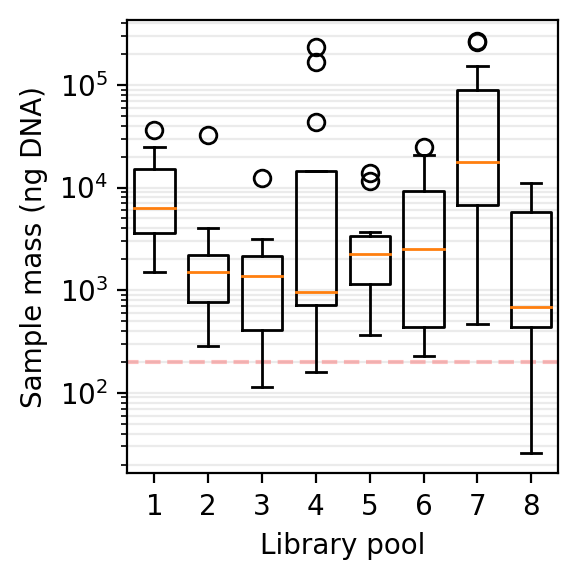

In [69]:
fig, ax = plt.subplots(figsize=(3,3))

for i in range(1,9):
    ax.boxplot(numeric_stats.loc[numeric_stats["pool"]==i]["initial_ng_DNA"], widths=[0.75],
               bootstrap=100, positions=[i])
ax.semilogy()
ax.hlines(y=200, xmin=0, xmax=10, color="red", alpha=0.25, linestyle="--")
ax.set_xlabel("Library pool")
ax.set_ylabel("Sample mass (ng DNA)")
ax.grid(axis='y', which='both', alpha=0.25)
ax.set_xlim(0.5, 8.5)

plt.tight_layout()

The red, dashed line in the figure above shows the 200 ng DNA threshold that the KAPA kit suggests.

Since we used standard ANOVAs, we can apply post-hoc Tukey HSD to identify group differences rather than Dunn's test.

In [70]:
tukey_conc = skph.posthoc_tukey(a=log_numeric, val_col="initial_concentration", group_col="pool", sort=True)
tukey_mass = skph.posthoc_tukey(a=log_numeric, val_col="initial_ng_DNA", group_col="pool", sort=True)

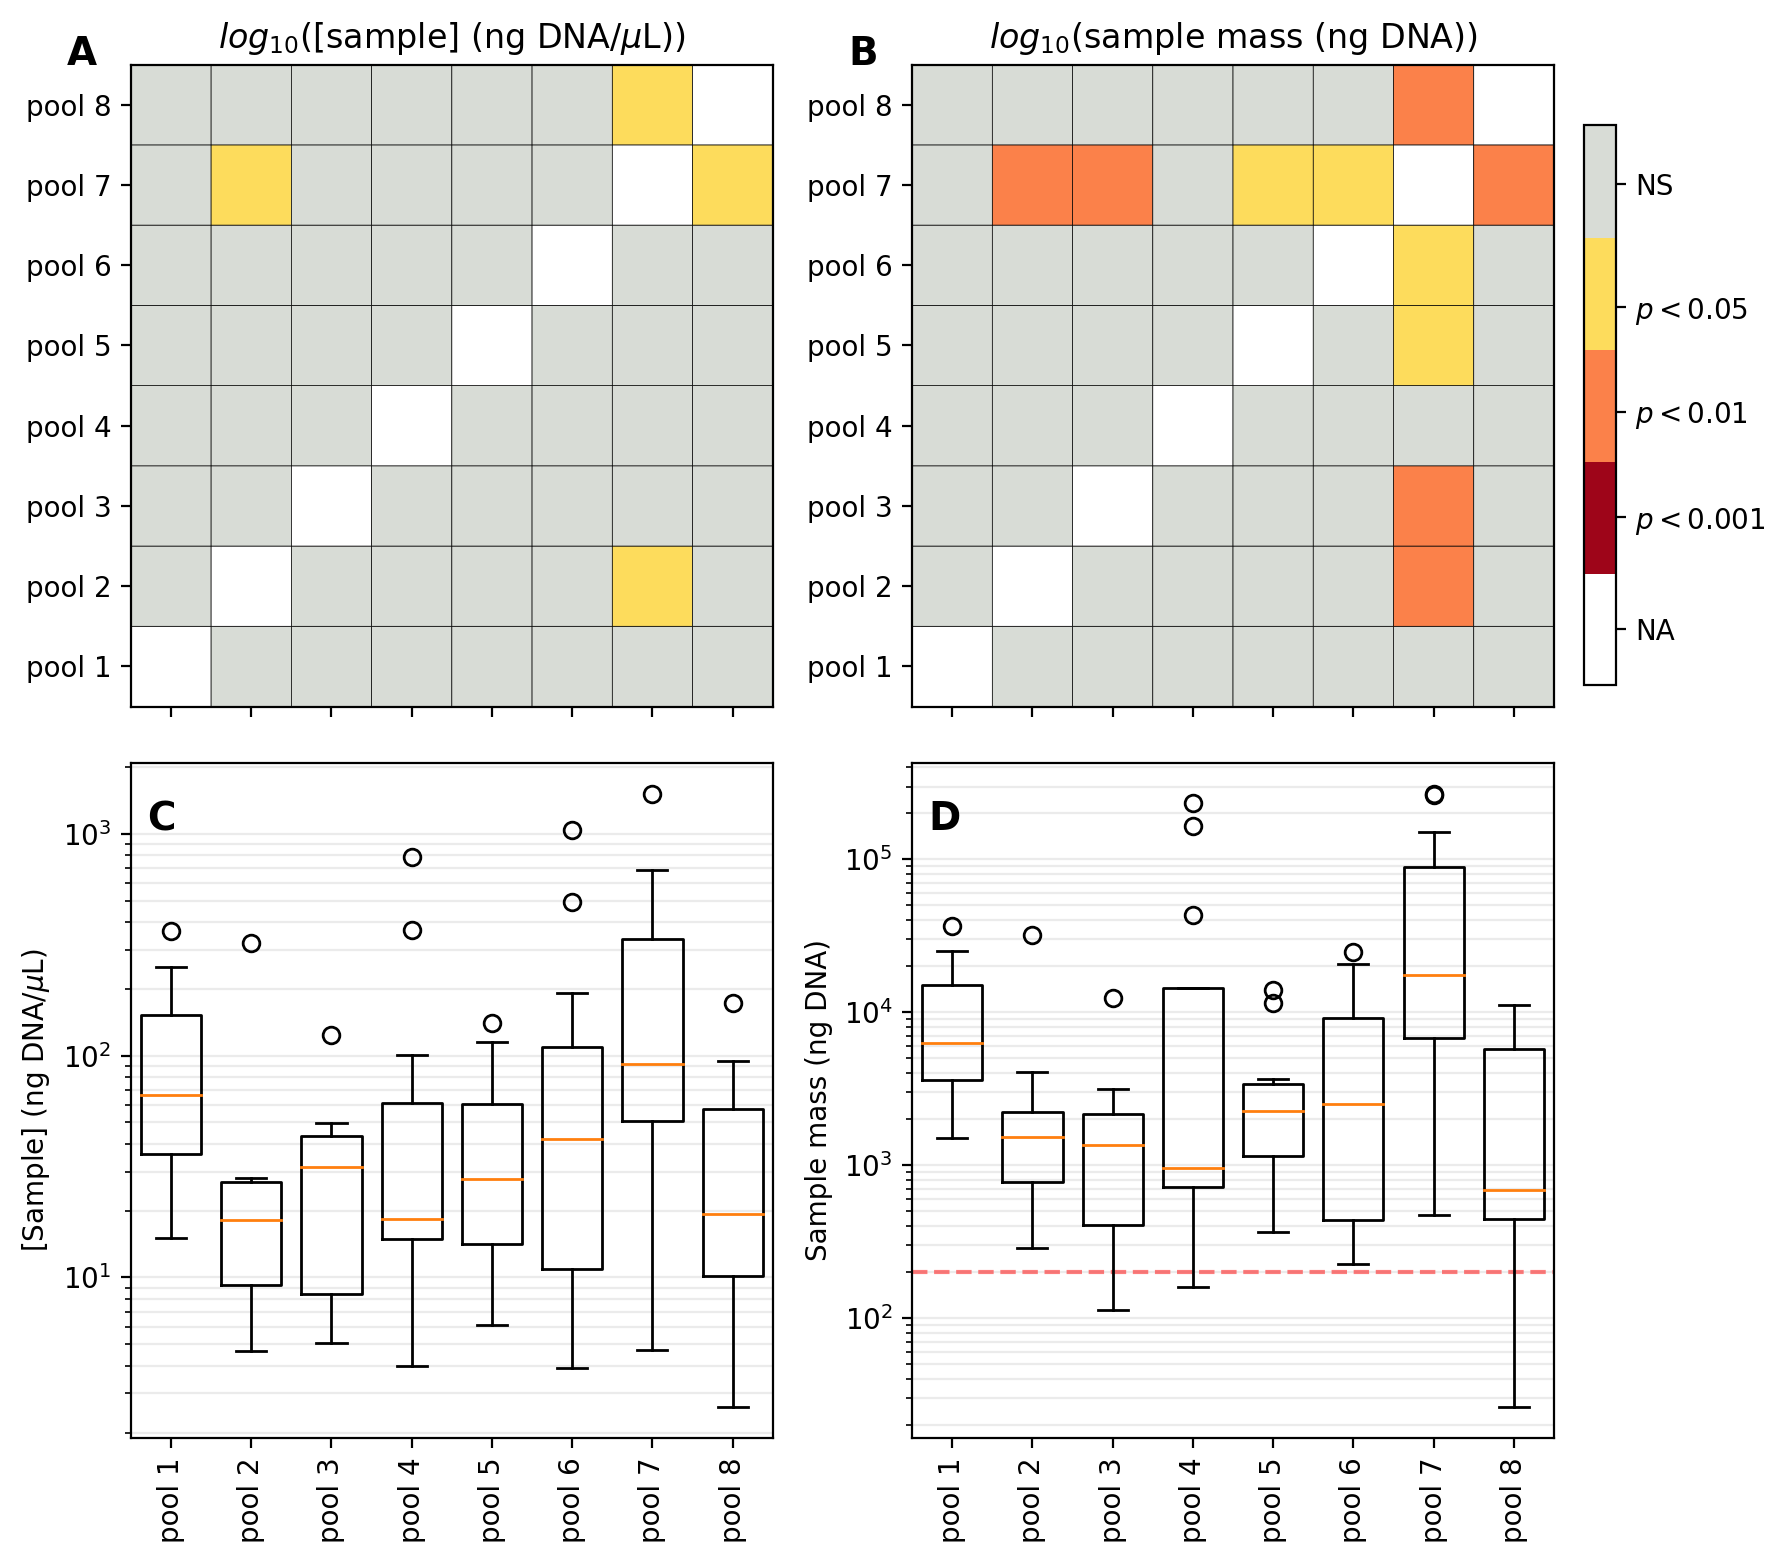

In [71]:
plt.style.use('default')
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,8), sharex=True)

cmaplist = ["white", "xkcd:carmine", "xkcd:orangish", "xkcd:light gold", "xkcd:light grey"]
cmap = mcolors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)
bounds = [-1, 0.0, 0.001, 0.01, 0.05, 1.0]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

pmap_conc = ax[0,0].pcolor(tukey_conc, cmap=cmap, norm=norm, edgecolors="black")
pmap_mass = ax[0,1].pcolor(tukey_mass, cmap=cmap, norm=norm, edgecolors="black")

cax = fig.add_axes([ax[0,-1].get_position().x1+0.1, ax[0,-1].get_position().y0+0.025, 
                    0.02, ax[0,-1].get_position().height])
cbar = plt.colorbar(pmap_mass, cax=cax, cmap=cmap, norm=norm, boundaries=bounds, 
                    ticks=[-0.5, 0.0005, 0.005, 0.025, 0.5])
cbar.ax.set_yticklabels(["NA", "$p<0.001$", "$p<0.01$", "$p<0.05$", "NS"])

for i in range(1,9):
    ax[1,0].boxplot(numeric_stats.loc[numeric_stats["pool"]==i]["initial_concentration"], widths=[0.75],
               bootstrap=100, positions=[i-0.5])
    ax[1,1].boxplot(numeric_stats.loc[numeric_stats["pool"]==i]["initial_ng_DNA"], widths=[0.75],
               bootstrap=100, positions=[i-0.5])
ax[1,1].hlines(y=200, xmin=0, xmax=10, color="red", alpha=0.5, linestyle="--")

ax[0,0].set_title("$log_{10}$([sample] (ng DNA/$\mu$L))")
ax[0,1].set_title("$log_{10}$(sample mass (ng DNA))")

for i in range(2):
    ax[0,i].set_aspect('equal','box')

    ax[0,i].set_yticks(np.linspace(0.5, 7.5, 8))
    ax[0,i].set_yticklabels(["pool {}".format(i) for i in range(1,9)])
    
    ax[1,i].grid(axis="y", which="both", alpha=0.25)
    ax[1,i].set_xticks(np.linspace(0.5, 7.5, 8))
    ax[1,i].set_xticklabels(["pool {}".format(i) for i in range(1,9)], rotation=90)
    ax[1,i].set_xlim(0, 8)

for i, axis in enumerate(ax.flatten()):
    if i<2:
        axis.annotate(string.ascii_uppercase[i], xy=(-0.1, 1.), xycoords="axes fraction", weight='bold', size=14)
    else:
        axis.annotate(string.ascii_uppercase[i], xy=(0.025, 0.90), xycoords="axes fraction", weight='bold', size=14)
ax[1,0].semilogy()
ax[1,1].semilogy()

ax[1,0].set_ylabel("[Sample] (ng DNA/$\mu$L)")
ax[1,1].set_ylabel("Sample mass (ng DNA)")

plt.tight_layout()
plt.savefig("../Figures/Statistics/AppendixS4-Pooling-Quality-Stats.pdf", format='pdf', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig("../Figures/Statistics/AppendixS4-Pooling-Quality-Stats.lowres.png", format='png', dpi=150, transparent=True, bbox_inches="tight")

So there are only a few pools that differ in sample quality, and those differences are only found when comparing to the highest quality pool (pool 7). It seems unlikely, but perhaps the differences in sample mass are related the differential success of some of the library pools. If this is the case, we should expect there to be a relationship between sample quality and read statistics that lead to overall lower or higher performance of particular libraries. To do this, I'll run a few regressions.

In [72]:
X = log_numeric["initial_concentration"]
y = log_numeric["ReadsMapped"]
X = sm.add_constant(X)

mod_ic = sm.OLS(y, X).fit()
mod_ic = mod_ic.get_robustcov_results()
print(mod_ic.summary())

                            OLS Regression Results                            
Dep. Variable:            ReadsMapped   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     3.875
Date:                Fri, 16 Oct 2020   Prob (F-statistic):             0.0520
Time:                        10:28:13   Log-Likelihood:                -110.50
No. Observations:                  96   AIC:                             225.0
Df Residuals:                      94   BIC:                             230.1
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     4.20

So it doesn't look like the number of reads mapped is related to the initial concentration because the slope is not significantly different from 0.

### Initial sample mass

In [73]:
print("Normality test")
normal_test(numeric_stats["initial_ng_DNA"], alpha=0.01, log=False)

print("\nLog-transformed normality test")
normal_test(log_numeric["initial_ng_DNA"], alpha=0.01, log=False)

Normality test
p = 1.19722e-24
The null hypothesis can be rejected. Data are not-normal.

Log-transformed normality test
p = 0.166484
The null hypothesis cannot be rejected. Data are normal.


(3.5857142578455, 0.16648382375222465)

Again, we'll go ahead with the log-transformed data.

In [74]:
X = log_numeric["initial_ng_DNA"]
X = sm.add_constant(X)

y_nr = log_numeric["NumReads"]
y_rm = log_numeric["ReadsMapped"]
y_ot = log_numeric["PctOnTarget"]
y_gwc = log_numeric["GenesWithSeqs"]

nr_mass = sm.OLS(y_nr, X).fit().get_robustcov_results()
rm_mass = sm.OLS(y_rm, X).fit().get_robustcov_results()
ot_mass = sm.OLS(y_ot, X).fit().get_robustcov_results()
gwc_mass = sm.OLS(y_gwc, X).fit().get_robustcov_results()

In [75]:
print(nr_mass.summary2())
print(rm_mass.summary2())
print(ot_mass.summary2())
print(gwc_mass.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     -0.011  
Dependent Variable: NumReads         AIC:                168.6545
Date:               2020-10-16 10:28 BIC:                173.7832
No. Observations:   96               Log-Likelihood:     -82.327 
Df Model:           1                F-statistic:        0.008847
Df Residuals:       94               Prob (F-statistic): 0.925   
R-squared:          0.000            Scale:              0.33231 
------------------------------------------------------------------
                Coef.   Std.Err.     t     P>|t|    [0.025  0.975]
------------------------------------------------------------------
const           5.4189    0.2499  21.6804  0.0000   4.9226  5.9151
initial_ng_DNA  0.0068    0.0727   0.0941  0.9253  -0.1376  0.1512
-----------------------------------------------------------------
Omnibus:             46.663       Durbin-Watson:          1.812  
Prob(Omnibus):       0

### Initial sample concentration

In [76]:
X = log_numeric["initial_concentration"]
X = sm.add_constant(X)

y_nr = log_numeric["NumReads"]
y_rm = log_numeric["ReadsMapped"]
y_ot = log_numeric["PctOnTarget"]
y_gwc = log_numeric["GenesWithSeqs"]

nr_conc = sm.OLS(y_nr, X).fit().get_robustcov_results()
rm_conc = sm.OLS(y_rm, X).fit().get_robustcov_results()
ot_conc = sm.OLS(y_ot, X).fit().get_robustcov_results()
gwc_conc = sm.OLS(y_gwc, X).fit().get_robustcov_results()

Finally, plot all this stuff.

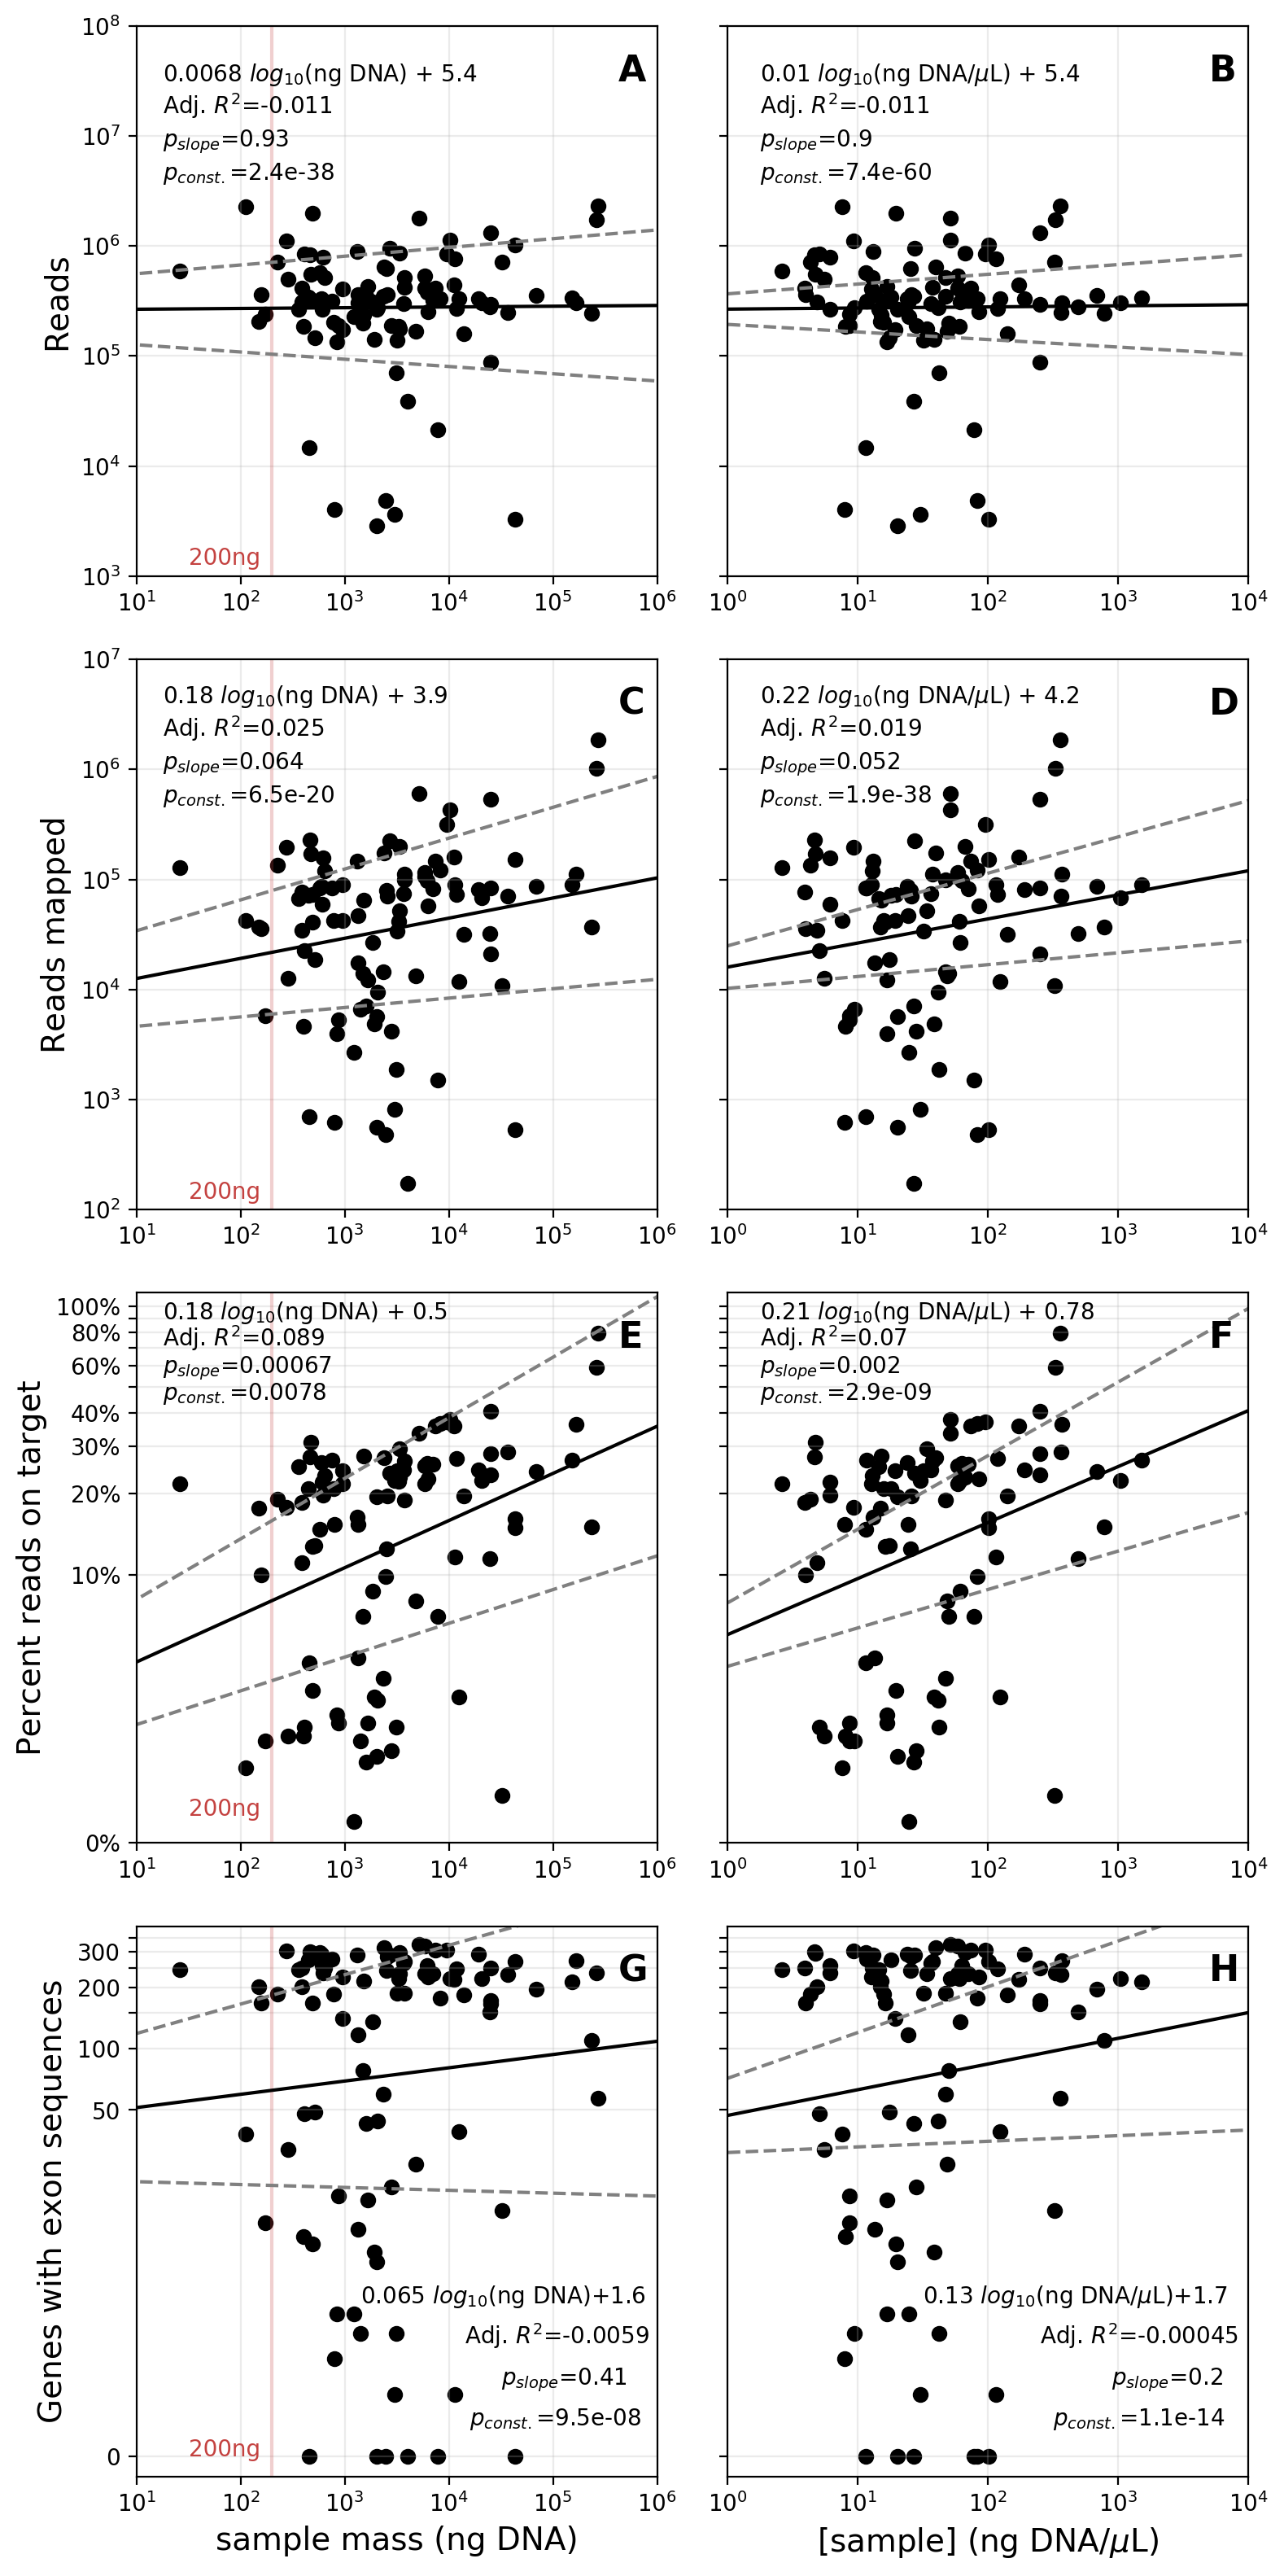

In [77]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(8,16), sharey='row')

intercept, slope = nr_mass.params
intercept_stderr, slope_stderr = nr_mass.bse
intercept_p, slope_p = nr_mass.pvalues
adjRsq = nr_mass.rsquared_adj
domain=np.linspace(0, 10, 1000)
ax[0,0].scatter(x=log_numeric["initial_ng_DNA"], y=log_numeric["NumReads"], color="black")
ax[0,0].plot(domain, intercept + (slope*domain), color="black")
ax[0,0].plot(domain, (intercept + intercept_stderr) + ((slope+slope_stderr)*domain), color="grey", linestyle="--")
ax[0,0].plot(domain, (intercept - intercept_stderr) + ((slope-slope_stderr)*domain), color="grey", linestyle="--")

ax[0,0].text(x=1.25, y=7.5, s="{:1.2} {} + {:1.2}".format(slope, "$log_{10}$(ng DNA)", intercept))
ax[0,0].text(x=1.25, y=7.2, s="Adj. {}={:1.2}".format("$R^2$", adjRsq))
ax[0,0].text(x=1.25, y=6.9, s="{}={:1.2}".format("$p_{slope}$", slope_p))
ax[0,0].text(x=1.25, y=6.6, s="{}={:1.2}".format("$p_{const.}$", intercept_p))

intercept, slope = rm_mass.params
intercept_stderr, slope_stderr = rm_mass.bse
intercept_p, slope_p = rm_mass.pvalues
adjRsq = rm_mass.rsquared_adj
ax[1,0].scatter(x=log_numeric["initial_ng_DNA"], y=log_numeric["ReadsMapped"], color="black")
ax[1,0].plot(domain, intercept + (slope*domain), color="black")
ax[1,0].plot(domain, (intercept + intercept_stderr) + ((slope+slope_stderr)*domain), color="grey", linestyle="--")
ax[1,0].plot(domain, (intercept - intercept_stderr) + ((slope-slope_stderr)*domain), color="grey", linestyle="--")

ax[1,0].text(x=1.25, y=6.6, s="{:1.2} {} + {:1.2}".format(slope, "$log_{10}$(ng DNA)", intercept))
ax[1,0].text(x=1.25, y=6.3, s="Adj. {}={:1.2}".format("$R^2$", adjRsq))
ax[1,0].text(x=1.25, y=6.0, s="{}={:1.2}".format("$p_{slope}$", slope_p))
ax[1,0].text(x=1.25, y=5.7, s="{}={:1.2}".format("$p_{const.}$", intercept_p))

intercept, slope = ot_mass.params
intercept_stderr, slope_stderr = ot_mass.bse
intercept_p, slope_p = ot_mass.pvalues
adjRsq = ot_mass.rsquared_adj
ax[2,0].scatter(x=log_numeric["initial_ng_DNA"], y=log_numeric["PctOnTarget"], color="black")
ax[2,0].plot(domain, intercept + (slope*domain), color="black")
ax[2,0].plot(domain, (intercept + intercept_stderr) + ((slope+slope_stderr)*domain), color="grey", linestyle="--")
ax[2,0].plot(domain, (intercept - intercept_stderr) + ((slope-slope_stderr)*domain), color="grey", linestyle="--")

ax[2,0].text(x=1.25, y=1.95, s="{:1.2} {} + {:1.2}".format(slope, "$log_{10}$(ng DNA)", intercept))
ax[2,0].text(x=1.25, y=1.85, s="Adj. {}={:1.2}".format("$R^2$", adjRsq))
ax[2,0].text(x=1.25, y=1.75, s="{}={:1.2}".format("$p_{slope}$", slope_p))
ax[2,0].text(x=1.25, y=1.65, s="{}={:1.2}".format("$p_{const.}$", intercept_p))

intercept, slope = gwc_mass.params
intercept_stderr, slope_stderr = gwc_mass.bse
intercept_p, slope_p = gwc_mass.pvalues
adjRsq = gwc_mass.rsquared_adj
ax[3,0].scatter(x=log_numeric["initial_ng_DNA"], y=log_numeric["GenesWithSeqs"], color="black")
ax[3,0].plot(domain, intercept + (slope*domain), color="black")
ax[3,0].plot(domain, (intercept + intercept_stderr) + ((slope+slope_stderr)*domain), color="grey", linestyle="--")
ax[3,0].plot(domain, (intercept - intercept_stderr) + ((slope-slope_stderr)*domain), color="grey", linestyle="--")

ax[3,0].text(x=3.15, y=0.75, s="{:1.2} {}+{:1.2}".format(slope, "$log_{10}$(ng DNA)", intercept))
ax[3,0].text(x=4.15, y=0.55, s="Adj. {}={:1.2}".format("$R^2$", adjRsq))
ax[3,0].text(x=4.5, y=0.35, s="{}={:1.2}".format("$p_{slope}$", slope_p))
ax[3,0].text(x=4.2, y=0.15, s="{}={:1.2}".format("$p_{const.}$", intercept_p))

intercept, slope = nr_conc.params
intercept_stderr, slope_stderr = nr_conc.bse
intercept_p, slope_p = nr_conc.pvalues
adjRsq = nr_conc.rsquared_adj
domain=np.linspace(0, 10, 1000)
ax[0,1].scatter(x=log_numeric["initial_concentration"], y=log_numeric["NumReads"], color="black")
ax[0,1].plot(domain, intercept + (slope*domain), color="black")
ax[0,1].plot(domain, (intercept + intercept_stderr) + ((slope+slope_stderr)*domain), color="grey", linestyle="--")
ax[0,1].plot(domain, (intercept - intercept_stderr) + ((slope-slope_stderr)*domain), color="grey", linestyle="--")

ax[0,1].text(x=0.25, y=7.5, s="{:1.2} {} + {:1.2}".format(slope, "$log_{10}$(ng DNA/$\mu$L)", intercept))
ax[0,1].text(x=0.25, y=7.2, s="Adj. {}={:1.2}".format("$R^2$", adjRsq))
ax[0,1].text(x=0.25, y=6.9, s="{}={:1.2}".format("$p_{slope}$", slope_p))
ax[0,1].text(x=0.25, y=6.6, s="{}={:1.2}".format("$p_{const.}$", intercept_p))

intercept, slope = rm_conc.params
intercept_stderr, slope_stderr = rm_conc.bse
intercept_p, slope_p = rm_conc.pvalues
adjRsq = rm_conc.rsquared_adj
ax[1,1].scatter(x=log_numeric["initial_concentration"], y=log_numeric["ReadsMapped"], color="black")
ax[1,1].plot(domain, intercept + (slope*domain), color="black")
ax[1,1].plot(domain, (intercept + intercept_stderr) + ((slope+slope_stderr)*domain), color="grey", linestyle="--")
ax[1,1].plot(domain, (intercept - intercept_stderr) + ((slope-slope_stderr)*domain), color="grey", linestyle="--")

ax[1,1].text(x=0.25, y=6.6, s="{:1.2} {} + {:1.2}".format(slope, "$log_{10}$(ng DNA/$\mu$L)", intercept))
ax[1,1].text(x=0.25, y=6.3, s="Adj. {}={:1.2}".format("$R^2$", adjRsq))
ax[1,1].text(x=0.25, y=6.0, s="{}={:1.2}".format("$p_{slope}$", slope_p))
ax[1,1].text(x=0.25, y=5.7, s="{}={:1.2}".format("$p_{const.}$", intercept_p))

intercept, slope = ot_conc.params
intercept_stderr, slope_stderr = ot_conc.bse
intercept_p, slope_p = ot_conc.pvalues
adjRsq = ot_conc.rsquared_adj
ax[2,1].scatter(x=log_numeric["initial_concentration"], y=log_numeric["PctOnTarget"], color="black")
ax[2,1].plot(domain, intercept + (slope*domain), color="black")
ax[2,1].plot(domain, (intercept + intercept_stderr) + ((slope+slope_stderr)*domain), color="grey", linestyle="--")
ax[2,1].plot(domain, (intercept - intercept_stderr) + ((slope-slope_stderr)*domain), color="grey", linestyle="--")

ax[2,1].text(x=0.25, y=1.95, s="{:1.2} {} + {:1.2}".format(slope, "$log_{10}$(ng DNA/$\mu$L)", intercept))
ax[2,1].text(x=0.25, y=1.85, s="Adj. {}={:1.2}".format("$R^2$", adjRsq))
ax[2,1].text(x=0.25, y=1.75, s="{}={:1.2}".format("$p_{slope}$", slope_p))
ax[2,1].text(x=0.25, y=1.65, s="{}={:1.2}".format("$p_{const.}$", intercept_p))

intercept, slope = gwc_conc.params
intercept_stderr, slope_stderr = gwc_conc.bse
intercept_p, slope_p = gwc_conc.pvalues
adjRsq = gwc_conc.rsquared_adj
ax[3,1].scatter(x=log_numeric["initial_concentration"], y=log_numeric["GenesWithSeqs"], color="black")
ax[3,1].plot(domain, intercept + (slope*domain), color="black")
ax[3,1].plot(domain, (intercept + intercept_stderr) + ((slope+slope_stderr)*domain), color="grey", linestyle="--")
ax[3,1].plot(domain, (intercept - intercept_stderr) + ((slope-slope_stderr)*domain), color="grey", linestyle="--")

ax[3,1].text(x=1.5, y=0.75, s="{:1.2} {}+{:1.2}".format(slope, "$log_{10}$(ng DNA/$\mu$L)", intercept))
ax[3,1].text(x=2.4, y=0.55, s="Adj. {}={:1.2}".format("$R^2$", adjRsq))
ax[3,1].text(x=2.95, y=0.35, s="{}={:1.2}".format("$p_{slope}$", slope_p))
ax[3,1].text(x=2.5, y=0.15, s="{}={:1.2}".format("$p_{const.}$", intercept_p))

ax[0,0].set_ylim(3, 8)
ax[1,0].set_ylim(2, 7)
ax[2,0].set_ylim(0, 2.05)
ax[3,0].set_ylim(-.1, np.log10(400))

for i in range(4):
    ax[i,0].set_xlim(1, 6)
    ax[i,0].set_xticks(range(1,7))
    ax[i,0].set_xticklabels(["$10^{}$".format(j) for j in range(1,7)])
    
    ax[i,1].set_xlim(0, 4)
    ax[i,1].set_xticks(range(5))
    ax[i,1].set_xticklabels(["$10^{}$".format(j) for j in range(5)])
    
    ax[i,0].text(x=1.5, y=ax[i,0].get_ylim()[0]+0.1, s="200ng", color="xkcd:reddish")
    
    
ax[0,0].set_yticks(range(3,9))
ax[0,0].set_yticklabels(["$10^{}$".format(j) for j in range(3,9)])   
ax[1,0].set_yticks(range(2,8))
ax[1,0].set_yticklabels(["$10^{}$".format(j) for j in range(2,8)])
ax[2,0].set_yticks([0]+[np.log10(d) for d in np.linspace(10,100,10)])
ax[2,0].set_yticklabels(['0%','10%','20%','30%','40%','','60%','','80%','','100%'])
ax[3,0].set_yticks([0]+[np.log10(d) for d in np.linspace(50, 350, 7)])
ax[3,0].set_yticklabels([0, 50, 100, '', 200, '', 300, ''])
    
ax[3,0].set_xlabel("sample mass (ng DNA)", size=14)
ax[3,1].set_xlabel("[sample] (ng DNA/$\mu$L)", size=14)

ax[0,0].set_ylabel("Reads", size=14)
ax[1,0].set_ylabel("Reads mapped", size=14)
ax[2,0].set_ylabel("Percent reads on target", size=14)
ax[3,0].set_ylabel("Genes with exon sequences", size=14)


for i, axis in enumerate(ax.flatten()):
    axis.annotate(string.ascii_uppercase[i], xy=(0.925, 0.90), xycoords="axes fraction", 
                    weight='bold', size=16)

for i in range(4):
    ax[i,0].grid(axis='both', which='major', alpha=0.25)
    ax[i,1].grid(axis='both', which='major', alpha=0.25)
    ax[i,0].vlines(x=np.log10(200), ymin=-0.5, ymax=8, color="xkcd:reddish", alpha=0.25)
    
plt.tight_layout()
plt.savefig("../Figures/Statistics/AppendixS5-SampleQualityRegression.pdf", format='pdf', dpi=300, transparent=True, bbox_inches='tight')
plt.savefig("../Figures/Statistics/AppendixS5-SampleQualityRegression.lowres.png", format='png', dpi=150, transparent=True, bbox_inches='tight')

We can see in the plots above that adjusted $R^2$ values are generally low, so initial sample quality does not explain much of the total variance, albeit the relationships with enrichment are likely important. They suggest that increased sample quality does slighlty increase the fraction of reads on target, but this does not appear to translate to more recovered loci. In summary, we believe that while sample quality may impact enrichment, it likely does not greatly decrease the efficacy of the baits. 